# Connection probability model building of the whole SSCx circuit

In [1]:
# Global imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse as sps
import os
import sys
import logging
import pickle

# Local imports
sys.path.append('../../library')
import modelling

## Local connectivity

In [2]:
data_path = '/gpfs/bbp.cscs.ch/project/proj102/scratch/SSCX_BioM/matrices'
conn_fn = 'local_connectivity.npz'
nrn_fn = 'neuron_info.feather'

In [3]:
# Load connectivity matrix and neuron table
adj_matrix = sps.load_npz(os.path.join(data_path, conn_fn))
nrn_table = pd.read_feather(os.path.join(data_path, nrn_fn))
assert adj_matrix.shape[0] == adj_matrix.shape[1] == nrn_table.shape[0], 'ERROR: Data size mismatch!'
print(f'INFO: Loaded connectivity and properties of {nrn_table.shape[0]} neurons')

INFO: Loaded connectivity and properties of 4234929 neurons


In [4]:
# Configure model building
config_dict = {'model_name': 'LocalConnProb2ndOrder', # Name of the model (to be used in file names, ...)
               'model_order': 2,                      # Model order
               'bin_size_um': 100,                    # Bin size (um) for depth binning
               'max_range_um': 1000,                  # Max. distance (um) range to consider (None to use full distance range)
               'sample_size': 30000,                  # Size of random subset of neurons to consider (0 or None to disable subsampling)
               'sample_seed': 1234,                   # Seed for selecting random subset of neurons
               'model_dir': './modelling/models',     # Output directory where to save the model (None to disable saving)
               'data_dir': './modelling/data',        # Output directory where to save the extracted data (None to disable saving)
               'do_plot': True,                       # Enable/disable output plotting
               'plot_dir': './modelling/figs',        # Output directory where to save the plots (None to disable saving)
               'N_split': None}                       # Number of data splits to sequentially run computations on, reducing memory consumption (None to disable splitting)

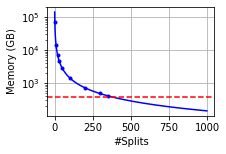

In [121]:
# # Estimation of memory requirements
# splits = [1, 10, 20, 30, 50, 100, 200, 300, 350]
# memory_TiB = [65.2, 13.0, 6.52, 4.35, 2.61, 1.30, 0.668, 0.445, 0.382]
# memory_GB = np.array(memory_TiB) * 2**40 / 10**9

# import scipy.optimize as opt
# f = lambda x, scale, exponent: scale / x**exponent
# (scale_opt, exp_opt), _ = opt.curve_fit(f, splits[1:], memory_GB[1:])

# plt.figure(figsize=(3, 2))
# x = np.arange(1, 1000)
# plt.plot(x, f(x, scale_opt, exp_opt), '-b')
# plt.plot(splits, memory_GB, '.b')
# plt.xlim(plt.xlim())
# plt.plot(plt.xlim(), np.full(2, 384), '--r')
# plt.yscale('log')
# plt.grid()
# plt.xlabel('#Splits')
# plt.ylabel('Memory (GB)')
# plt.show()

[2021-12-16 10:29:34,461] INFO: Running order-2 model building {'bin_size_um': 100, 'max_range_um': 1000, 'sample_size': 30000, 'sample_seed': 1234, 'model_dir': './modelling/models', 'data_dir': './modelling/data', 'do_plot': True, 'plot_dir': './modelling/figs', 'N_split': None}...
[2021-12-16 10:29:34,463] INFO: Subsampling to 30000 of 4234929 neurons (seed=1234)
[2021-12-16 10:29:45,801] INFO: Extracting 1-dimensional (10) connection probabilities...


[2021-12-16 10:30:53,740] INFO: Pickled dict written to ./modelling/data/LocalConnProb2ndOrder__data.pickle


[2021-12-16 10:30:54,009] INFO: MODEL FIT: f(x) = 0.116 * exp(-0.008 * x)
[2021-12-16 10:30:54,013] INFO: Pickled dict written to ./modelling/models/LocalConnProb2ndOrder__model.pickle
[2021-12-16 10:30:55,551] INFO: Figure saved to /gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/connectome_analysis/data_analysis/pokorny/modelling/figs/LocalConnProb2ndOrder__data_vs_model.png
[2021-12-16 10:30:56,386] INFO: Figure saved to /gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/connectome_analysis/data_analysis/pokorny/modelling/figs/LocalConnProb2ndOrder__data_counts.png


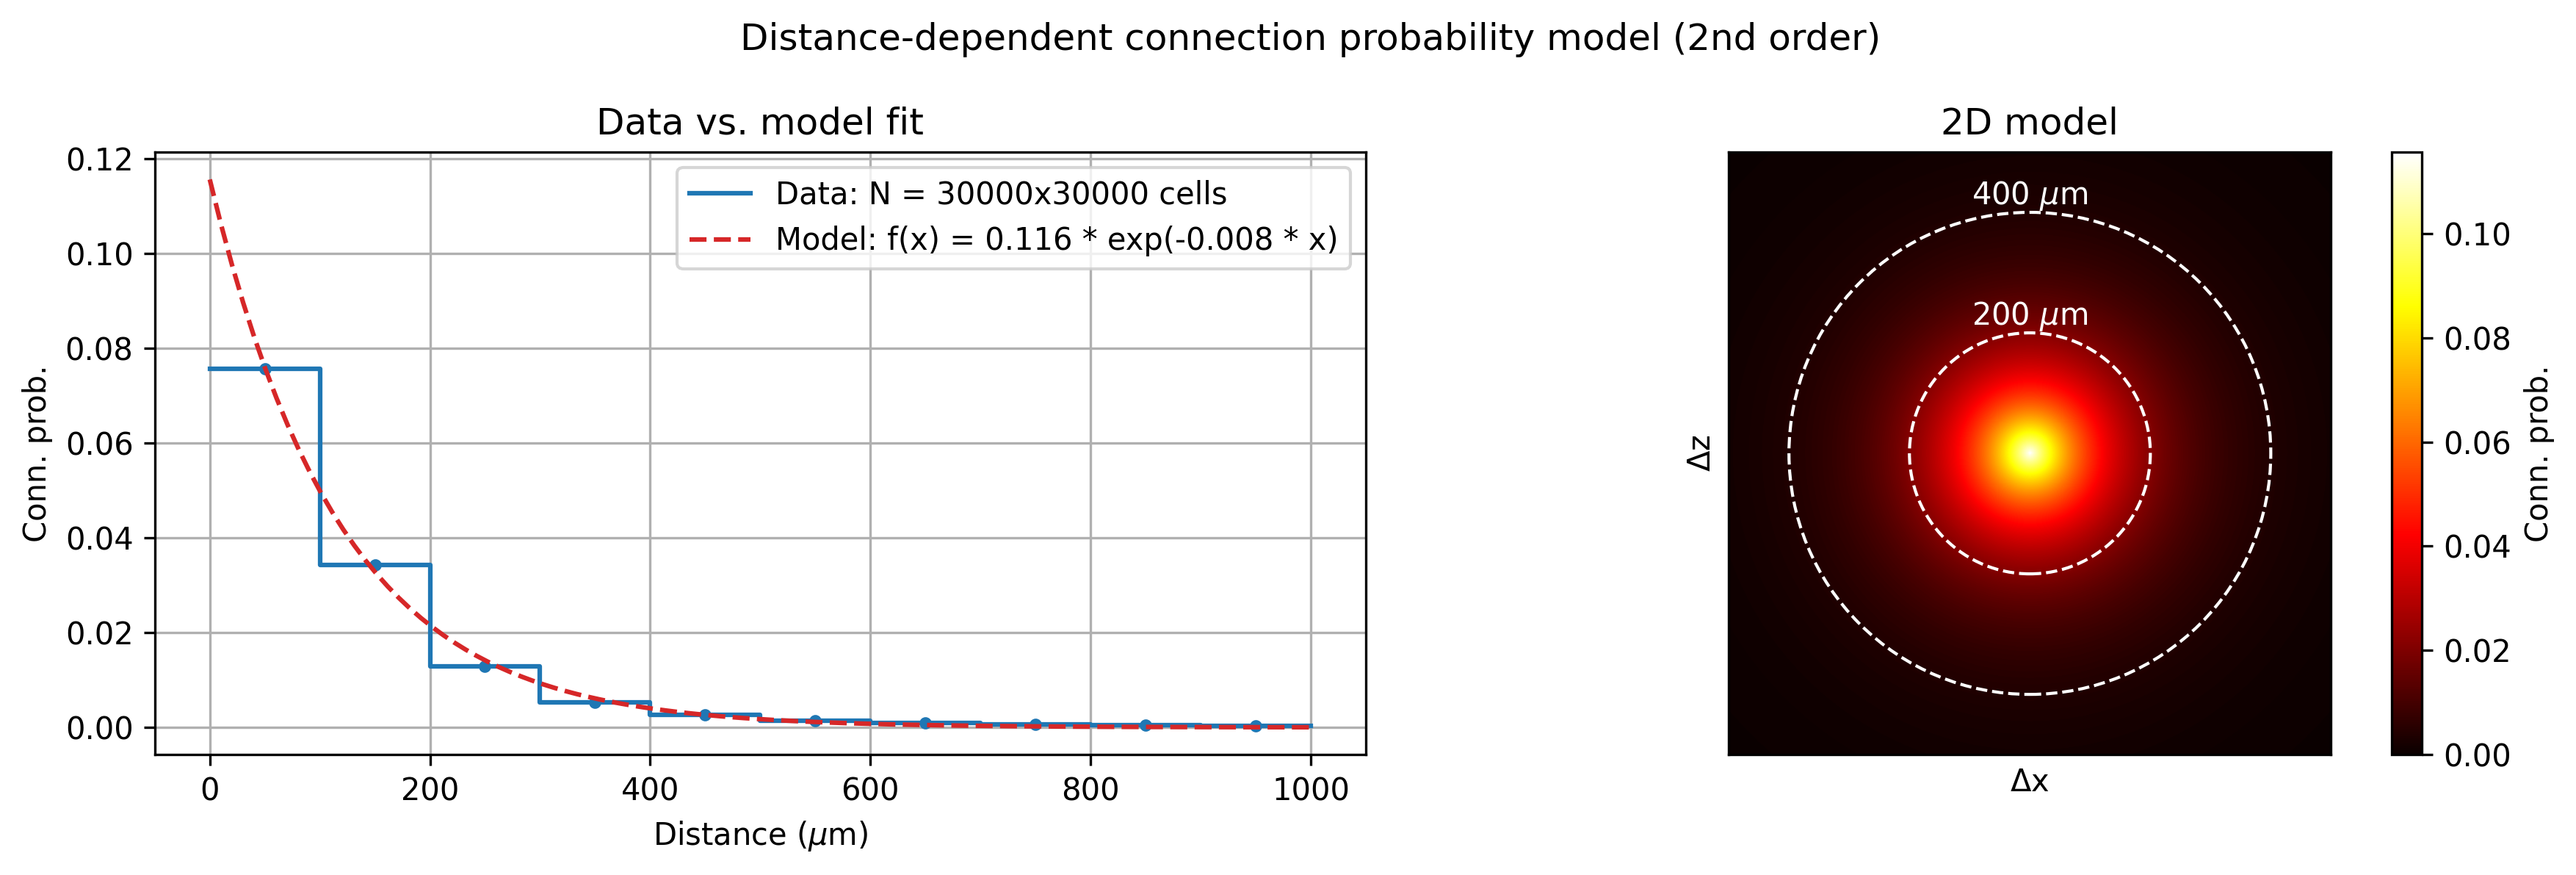

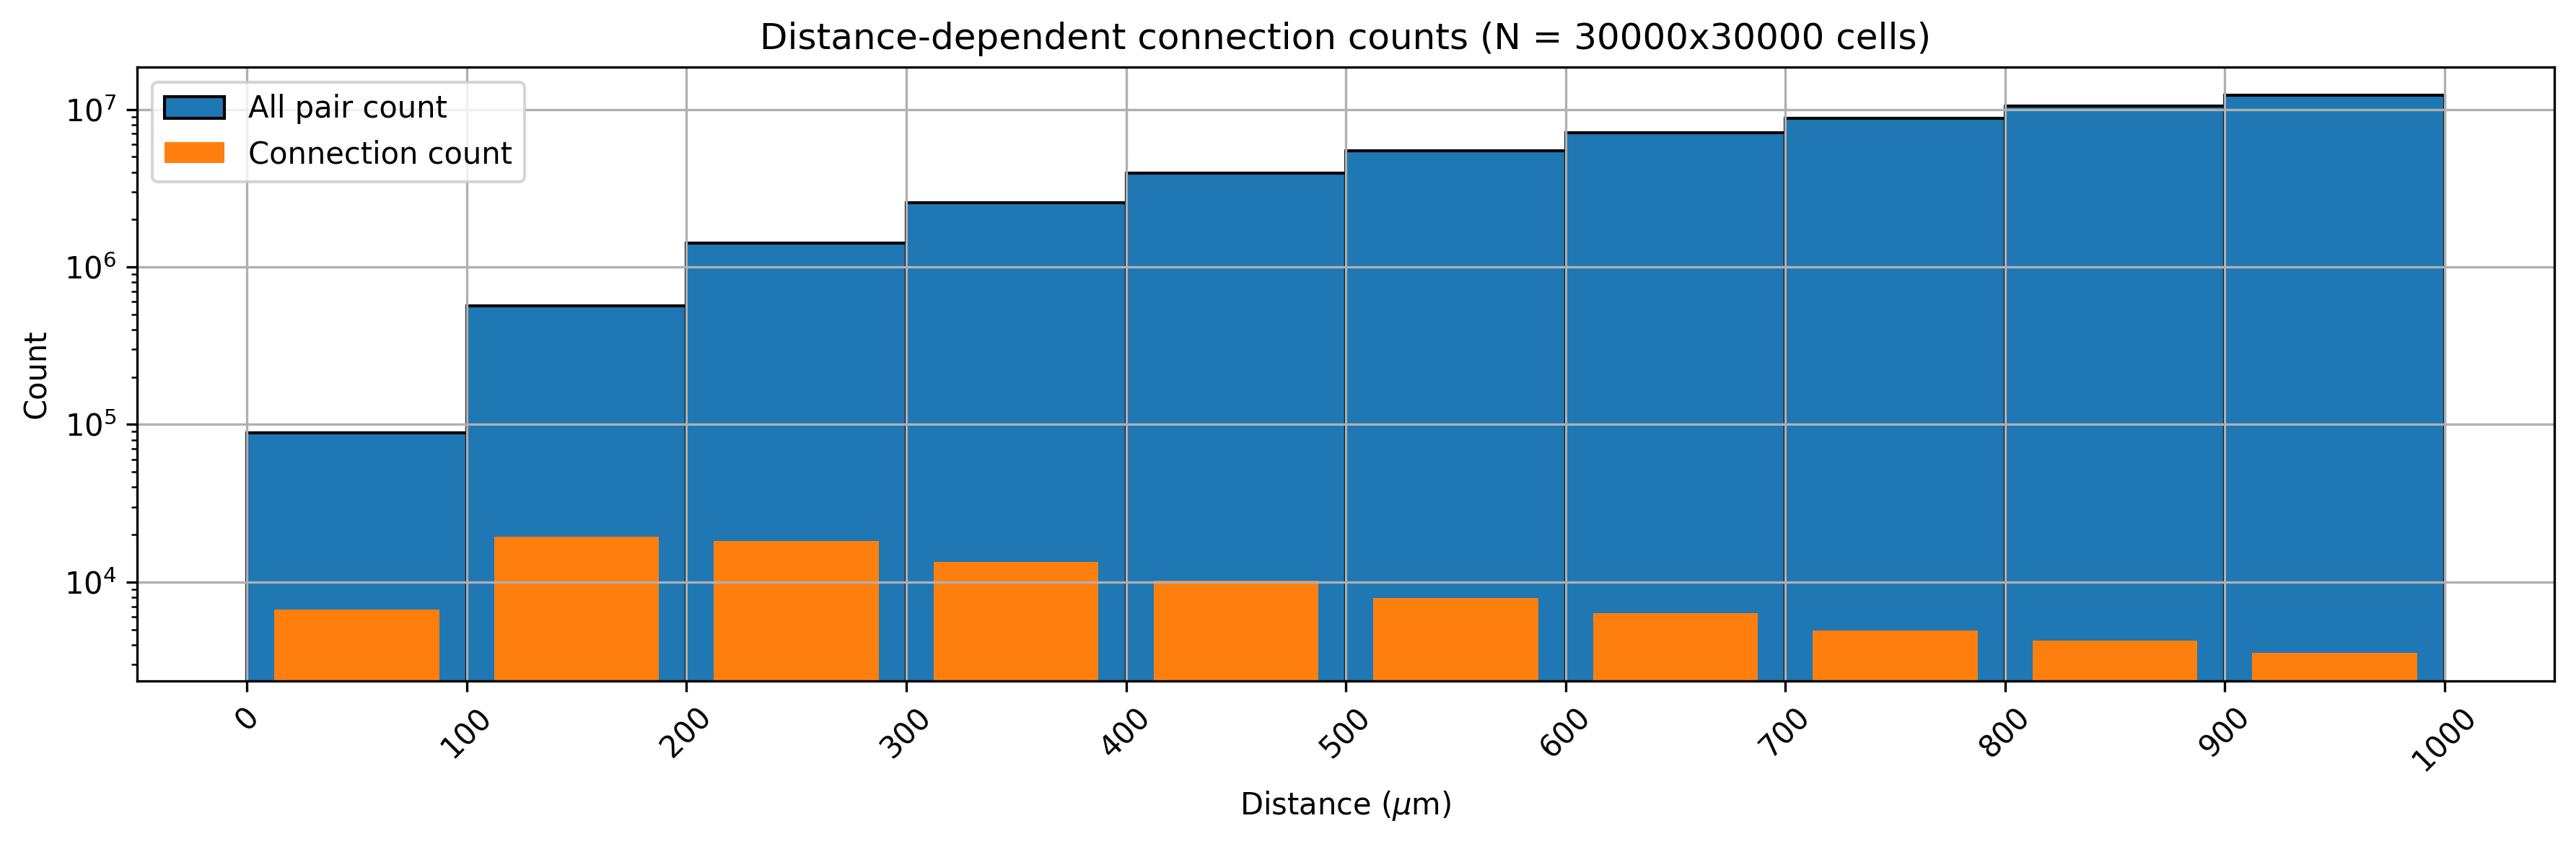

In [5]:
# Run model building
data_dict, model_dict = modelling.run_model_building(adj_matrix, nrn_table, **config_dict)

### Building multiple 2nd-order models using different random subsets of neurons

In [9]:
num_samples = 10
sample_sizes = [1000, 5000, 10000, 25000, 50000, 75000, 100000]
save_path = './modelling/tables'
if not os.path.exists(save_path):
    os.makedirs(save_path)

logging.getLogger().setLevel(logging.WARNING) # Global control of logging level (default: INFO; WARNING to disable outputs)

model_params_2 = []
config_dict = {'bin_size_um': 100, 'max_range_um': 1000, 'sample_size': None, 'sample_seeds': num_samples}
for idx, sample_size in enumerate(sample_sizes):
    print(f'Step {idx + 1} of {len(sample_sizes)}: Sampling {num_samples} x {sample_size} neurons')
    config_dict.update({'sample_size': sample_size})
    model_params_2.append(modelling.conn_prob_2nd_order_model(adj_matrix, nrn_table, **config_dict))
    model_params_2[idx].to_hdf(os.path.join(save_path, 'model_params_order-2_local.h5'), key=f'sub{sample_sizes[idx]}', mode='r+' if idx else 'w') # Save to .h5 (appending)

Step 1 of 7: Sampling 10 x 1000 neurons


100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|


Step 2 of 7: Sampling 10 x 5000 neurons


100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|


Step 3 of 7: Sampling 10 x 10000 neurons


100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|


Step 4 of 7: Sampling 10 x 25000 neurons


100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|


Step 5 of 7: Sampling 10 x 50000 neurons


100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|


Step 6 of 7: Sampling 10 x 75000 neurons


100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|


Step 7 of 7: Sampling 10 x 100000 neurons


100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|


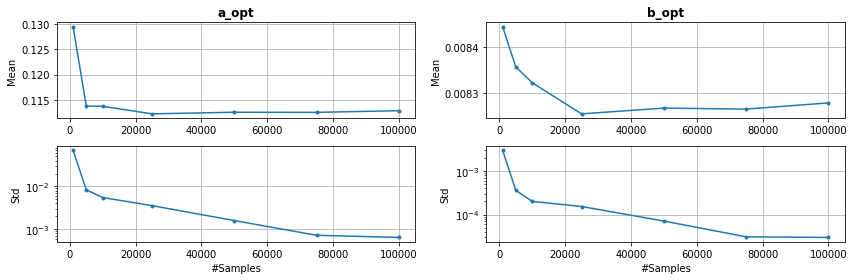

In [114]:
# Visualize parameter convergence
param_names = model_params_2[0].columns
plt.figure(figsize=(6 * len(param_names), 4))
for pidx, pname in enumerate(param_names):
    param_mean = [model_params_2[sidx][pname].mean() for sidx in range(len(sample_sizes))]
    param_std = [model_params_2[sidx][pname].std() for sidx in range(len(sample_sizes))]
    plt.subplot(len(param_names), 2, pidx + 1)
    plt.plot(sample_sizes, param_mean, '.-')
    plt.ylabel('Mean')
    plt.grid()
    plt.title(pname, fontweight='bold')
    plt.subplot(len(param_names), 2, pidx + 1 + len(param_names))
    plt.plot(sample_sizes, param_std, '.-')
    plt.ylabel('Std')
    plt.gca().set_yscale('log')
    plt.grid()
    plt.xlabel('#Samples')
plt.tight_layout()

In [113]:
# Print parameter values
max_idx = np.argmax(sample_sizes)
for pidx, pname in enumerate(param_names):
    print(f'{pname}: MEAN={model_params_2[max_idx][pname].mean():.12f}, STD={model_params_2[max_idx][pname].std():.12f} ({len(model_params_2[max_idx][pname])} x {np.max(sample_sizes)} neurons)')

a_opt: MEAN=0.112897793969, STD=0.000645678584 (10 x 100000 neurons)
b_opt: MEAN=0.008278898103, STD=0.000029850961 (10 x 100000 neurons)


## Mid-range connectivity

In [2]:
data_path = '/gpfs/bbp.cscs.ch/project/proj102/scratch/SSCX_BioM/matrices'
conn_fn = 'intra_SSCX_midrange_wm.npz'
nrn_fn = 'neuron_info_extended.feather'

In [3]:
# Load connectivity matrix and neuron table
adj_matrix = sps.load_npz(os.path.join(data_path, conn_fn))
nrn_table = pd.read_feather(os.path.join(data_path, nrn_fn))
assert adj_matrix.shape[0] == adj_matrix.shape[1] == nrn_table.shape[0], 'ERROR: Data size mismatch!'
print(f'INFO: Loaded connectivity and properties of {nrn_table.shape[0]} neurons')

INFO: Loaded connectivity and properties of 4234929 neurons


In [4]:
# Configure model building
config_dict = {'model_name': 'MidRConnProb2ndOrder', # Name of the model (to be used in file names, ...)
               'model_order': 2,                     # Model order
               'bin_size_um': 100,                   # Bin size (um) for depth binning
               'max_range_um': None,                 # Max. distance (um) range to consider (None to use full distance range)
               'sample_size': 100000,                # Size of random subset of neurons to consider (0 or None to disable subsampling)
               'sample_seed': 4321,                  # Seed for selecting random subset of neurons
               'model_dir': './modelling/models',    # Output directory where to save the model (None to disable saving)
               'data_dir': './modelling/data',       # Output directory where to save the extracted data (None to disable saving)
               'do_plot': True,                      # Enable/disable output plotting
               'plot_dir': './modelling/figs',       # Output directory where to save the plots (None to disable saving)
               'N_split': None}                      # Number of data splits to sequentially run computations on, reducing memory consumption (None or 1 to disable splitting)

INFO: Running order-2 model building {'bin_size_um': 100, 'max_range_um': None, 'sample_size': 100000, 'sample_seed': 4321, 'model_dir': './modelling/models', 'data_dir': './modelling/data', 'do_plot': True, 'plot_dir': './modelling/figs', 'N_split': None}...
INFO: Subsampling to 100000 of 4234929 neurons (seed=4321)
INFO: Extracting 1-dimensional (78) connection probabilities...


100% |########################################################################|


INFO: Pickled dict written to ./modelling/data/MidRConnProb2ndOrder__data.pickle
INFO: MODEL FIT: f(x) = 0.000 * exp(-0.000 * x)
INFO: Pickled dict written to ./modelling/models/MidRConnProb2ndOrder__model.pickle
INFO: Figure saved to /gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/connectome_analysis/data_analysis/modelling/figs/MidRConnProb2ndOrder__data_vs_model.png
INFO: Figure saved to /gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/connectome_analysis/data_analysis/modelling/figs/MidRConnProb2ndOrder__data_counts.png


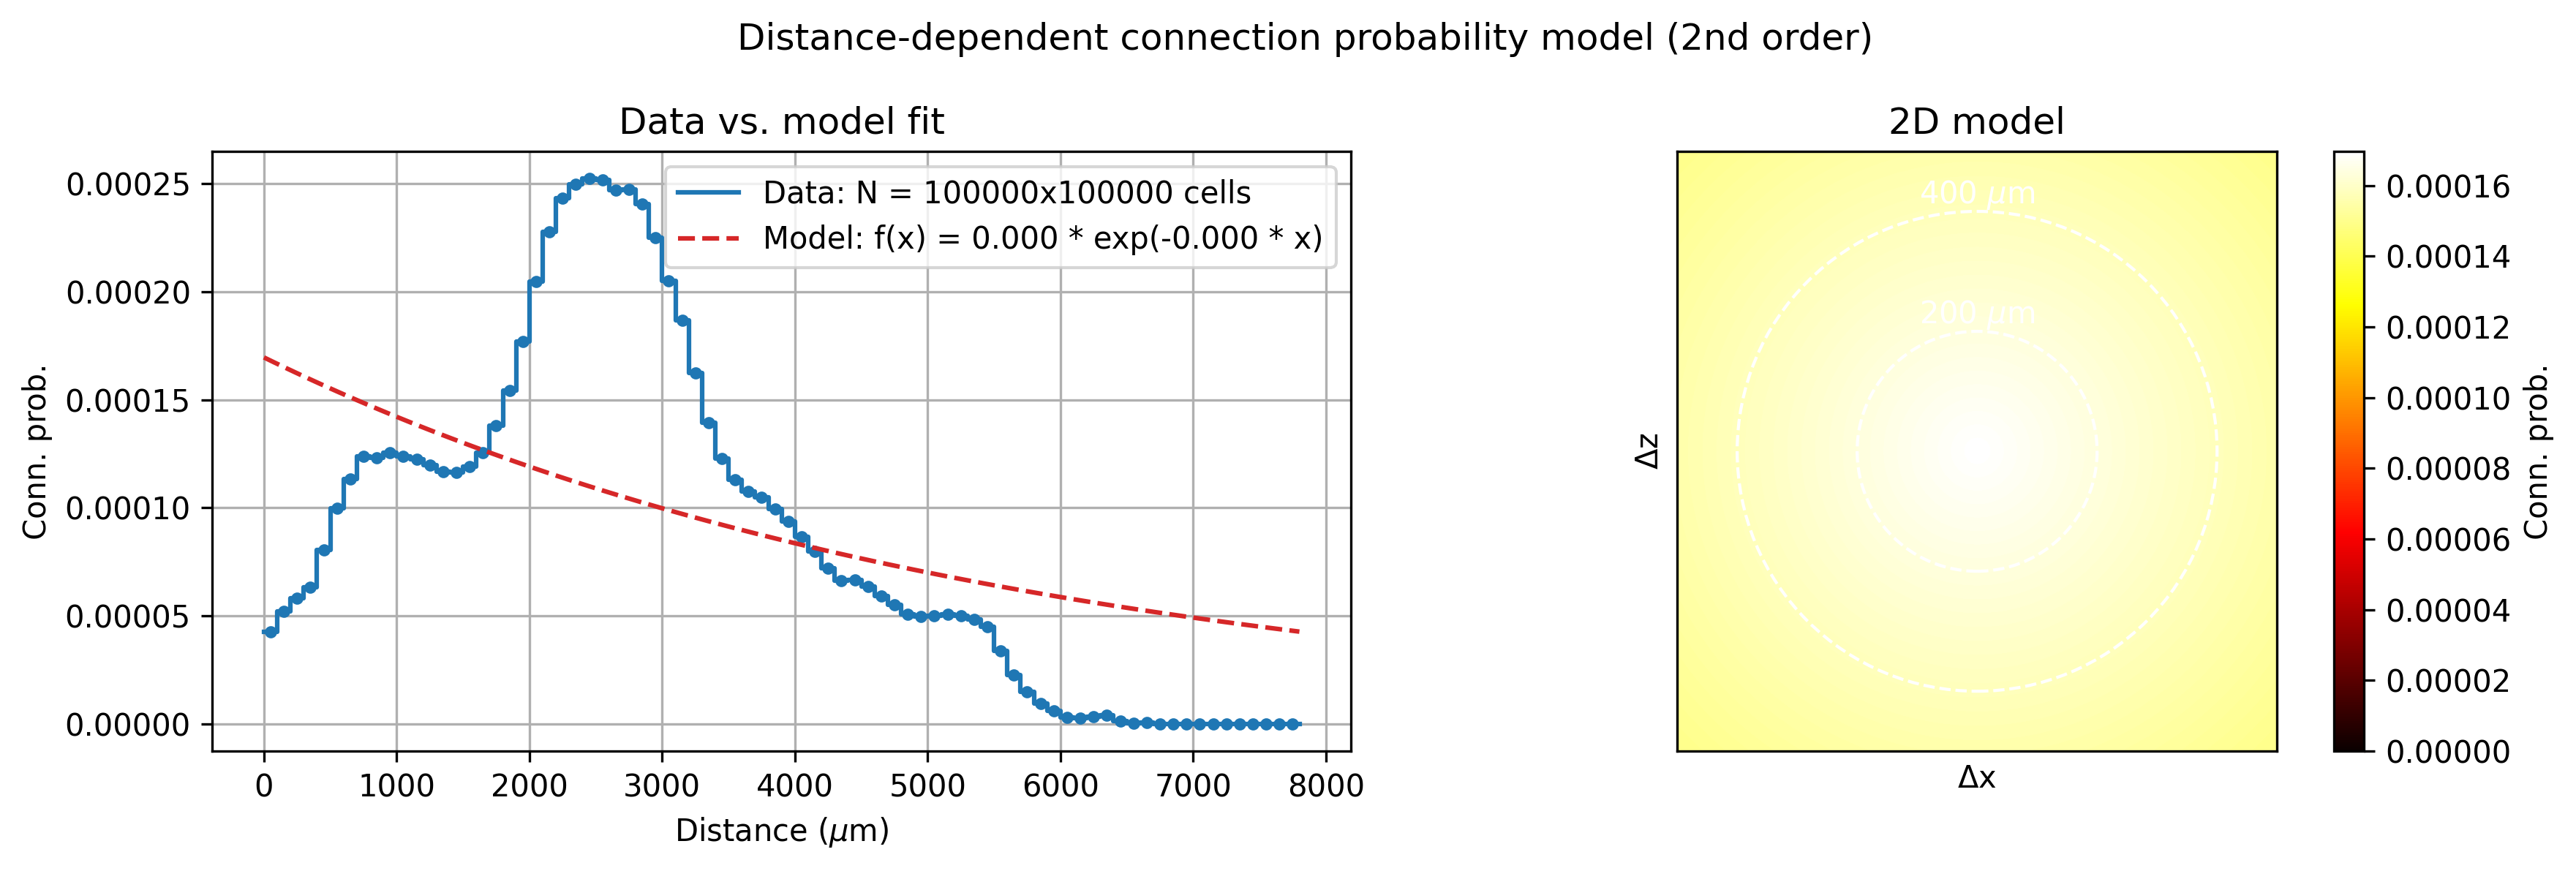

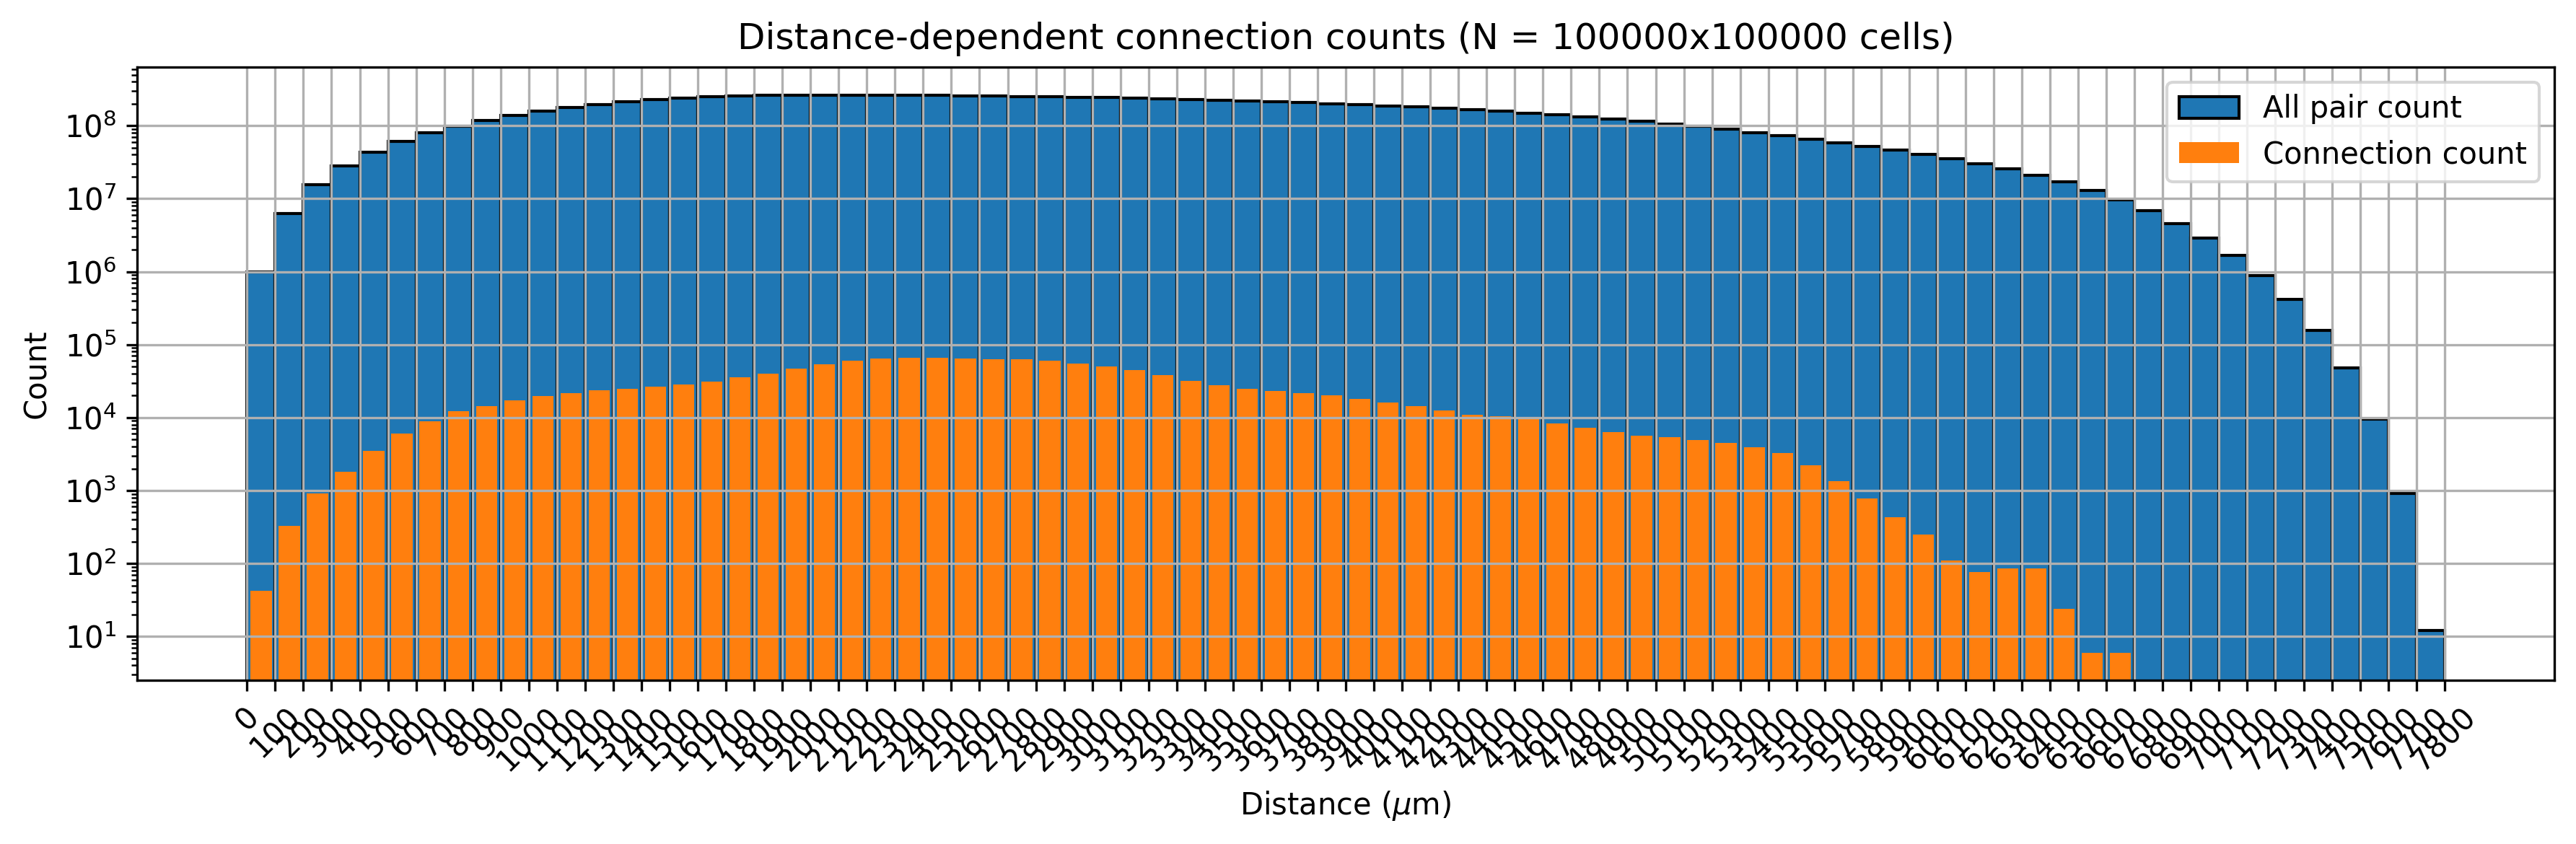

In [5]:
# Run model building
data_dict, model_dict = modelling.run_model_building(adj_matrix, nrn_table, **config_dict)

In [35]:
# # Load existing model/data
# import pickle
# file_names = {'data': f'./modelling/data/MidRConnProb2ndOrder__data.pickle',
#               'model': f'./modelling/models/MidRConnProb2ndOrder__model.pickle'}
# with open(file_names['data'], 'rb') as f:
#     data_dict = pickle.load(f)
# with open(file_names['model'], 'rb') as f:
#     model_dict = pickle.load(f)

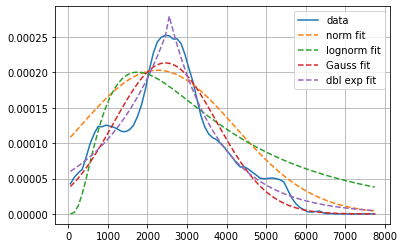

In [37]:
import matplotlib.pyplot as plt
import scipy.optimize as opt

bin_offset = 0.5 * np.diff(data_dict['dist_bins'][:2])[0]
X = data_dict['dist_bins'][:-1][np.isfinite(data_dict['p_conn_dist'])] + bin_offset
y = data_dict['p_conn_dist'][np.isfinite(data_dict['p_conn_dist'])]

plt.figure()
plt.plot(X, y, label='data')

norm_model = lambda x, mu, sig, : 1 / (np.sqrt(2 * np.pi) * sig) * np.exp(-1 / 2 * ((x - mu) / sig)**2)
(mu_opt, sig_opt), _ = opt.curve_fit(norm_model, X, y, p0=[1000.0, 1000.0])
plt.plot(X, norm_model(X, mu_opt, sig_opt), '--', label='norm fit')

lognorm_model = lambda x, mu, sig: 1 / (np.sqrt(2 * np.pi) * sig * x) * np.exp(-1 / 2 * ((np.log(x) - mu) / sig)**2)
(mu_opt, sig_opt), _ = opt.curve_fit(lognorm_model, X, y, p0=[1.0, 1.0])
plt.plot(X, lognorm_model(X, mu_opt, sig_opt), '--', label='lognorm fit')

gauss_model = lambda x, a, b, c, : a * np.exp(-(x - b)**2 / (2 * c**2))
(a_opt, b_opt, c_opt), _ = opt.curve_fit(gauss_model, X, y, p0=[1e-3, 1000.0, 1000.0])
plt.plot(X, gauss_model(X, a_opt, b_opt, c_opt), '--', label='Gauss fit')

exp_model = lambda x, a, b: a * np.exp(b * np.array(x))
d_mid = X[np.argmax(y)]
dbl_exp_model = lambda x, aL, bL, aR, bR: np.select([x <= d_mid, x > d_mid], [exp_model(x, aL, bL), exp_model(x, aR, -bR)])
(aL_opt, bL_opt, aR_opt, bR_opt), _ = opt.curve_fit(dbl_exp_model, X, y, p0=[0.0, 0.0, 0.0, 0.0])
plt.plot(X, dbl_exp_model(X, aL_opt, bL_opt, aR_opt, bR_opt), '--', label='dbl exp fit')

plt.grid()
plt.legend()
plt.show()

### Different sets of coordinates

INFO: Running order-2 model building {'bin_size_um': 100, 'max_range_um': None, 'sample_size': 100000, 'sample_seed': 4321, 'model_dir': './modelling/models', 'data_dir': './modelling/data', 'do_plot': True, 'plot_dir': './modelling/figs', 'N_split': None, 'coord_names': ['ss_flat_x', 'ss_flat_y', 'depth']}...
INFO: Subsampling to 100000 of 4234929 neurons (seed=4321)
INFO: Extracting 1-dimensional (79) connection probabilities...


100% |########################################################################|


INFO: Pickled dict written to ./modelling/data/MidRConnProb2ndOrder3DFlat__data.pickle
INFO: MODEL FIT: f(x) = 0.000 * exp(-0.000 * x)
INFO: Pickled dict written to ./modelling/models/MidRConnProb2ndOrder3DFlat__model.pickle
INFO: Figure saved to /gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/connectome_analysis/data_analysis/modelling/figs/MidRConnProb2ndOrder3DFlat__data_vs_model.png
INFO: Figure saved to /gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/connectome_analysis/data_analysis/modelling/figs/MidRConnProb2ndOrder3DFlat__data_counts.png


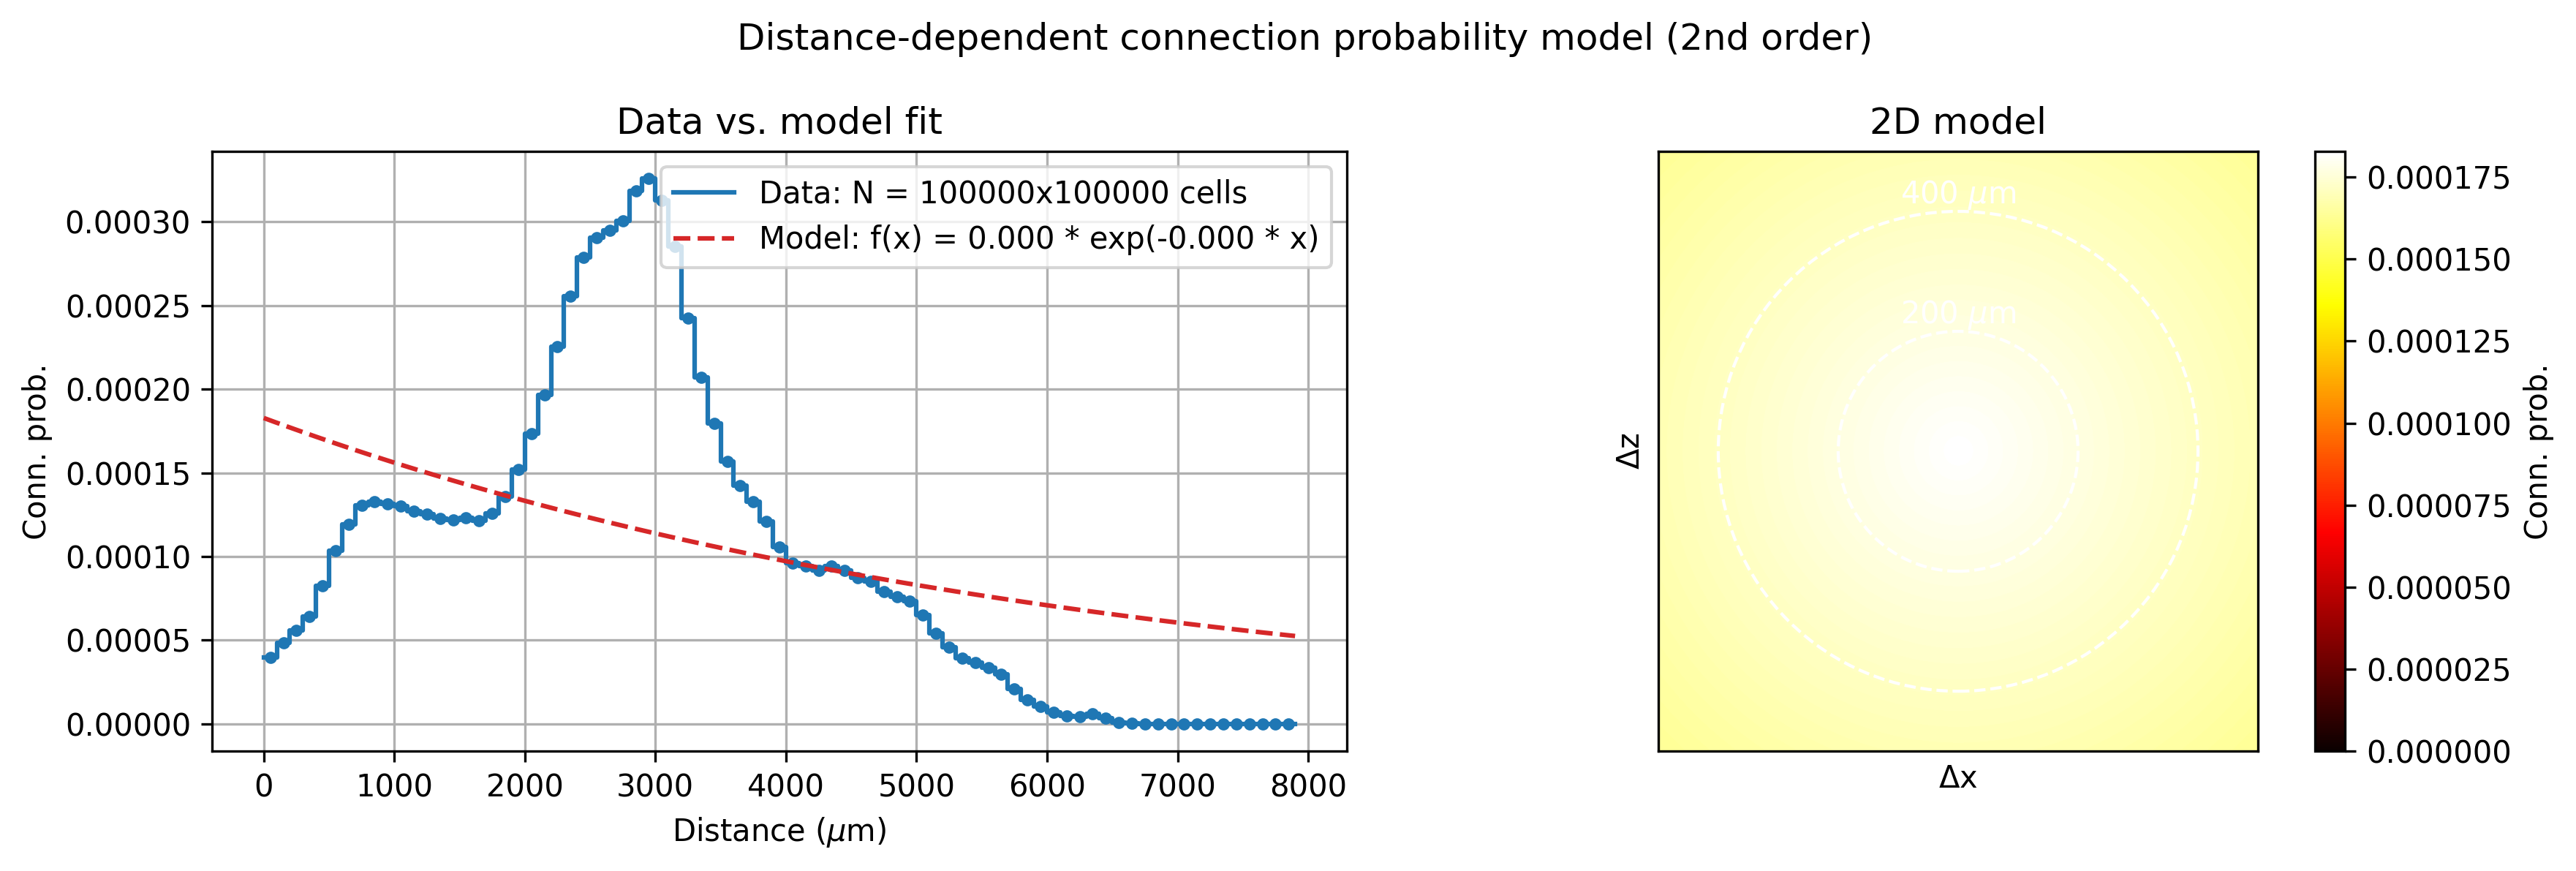

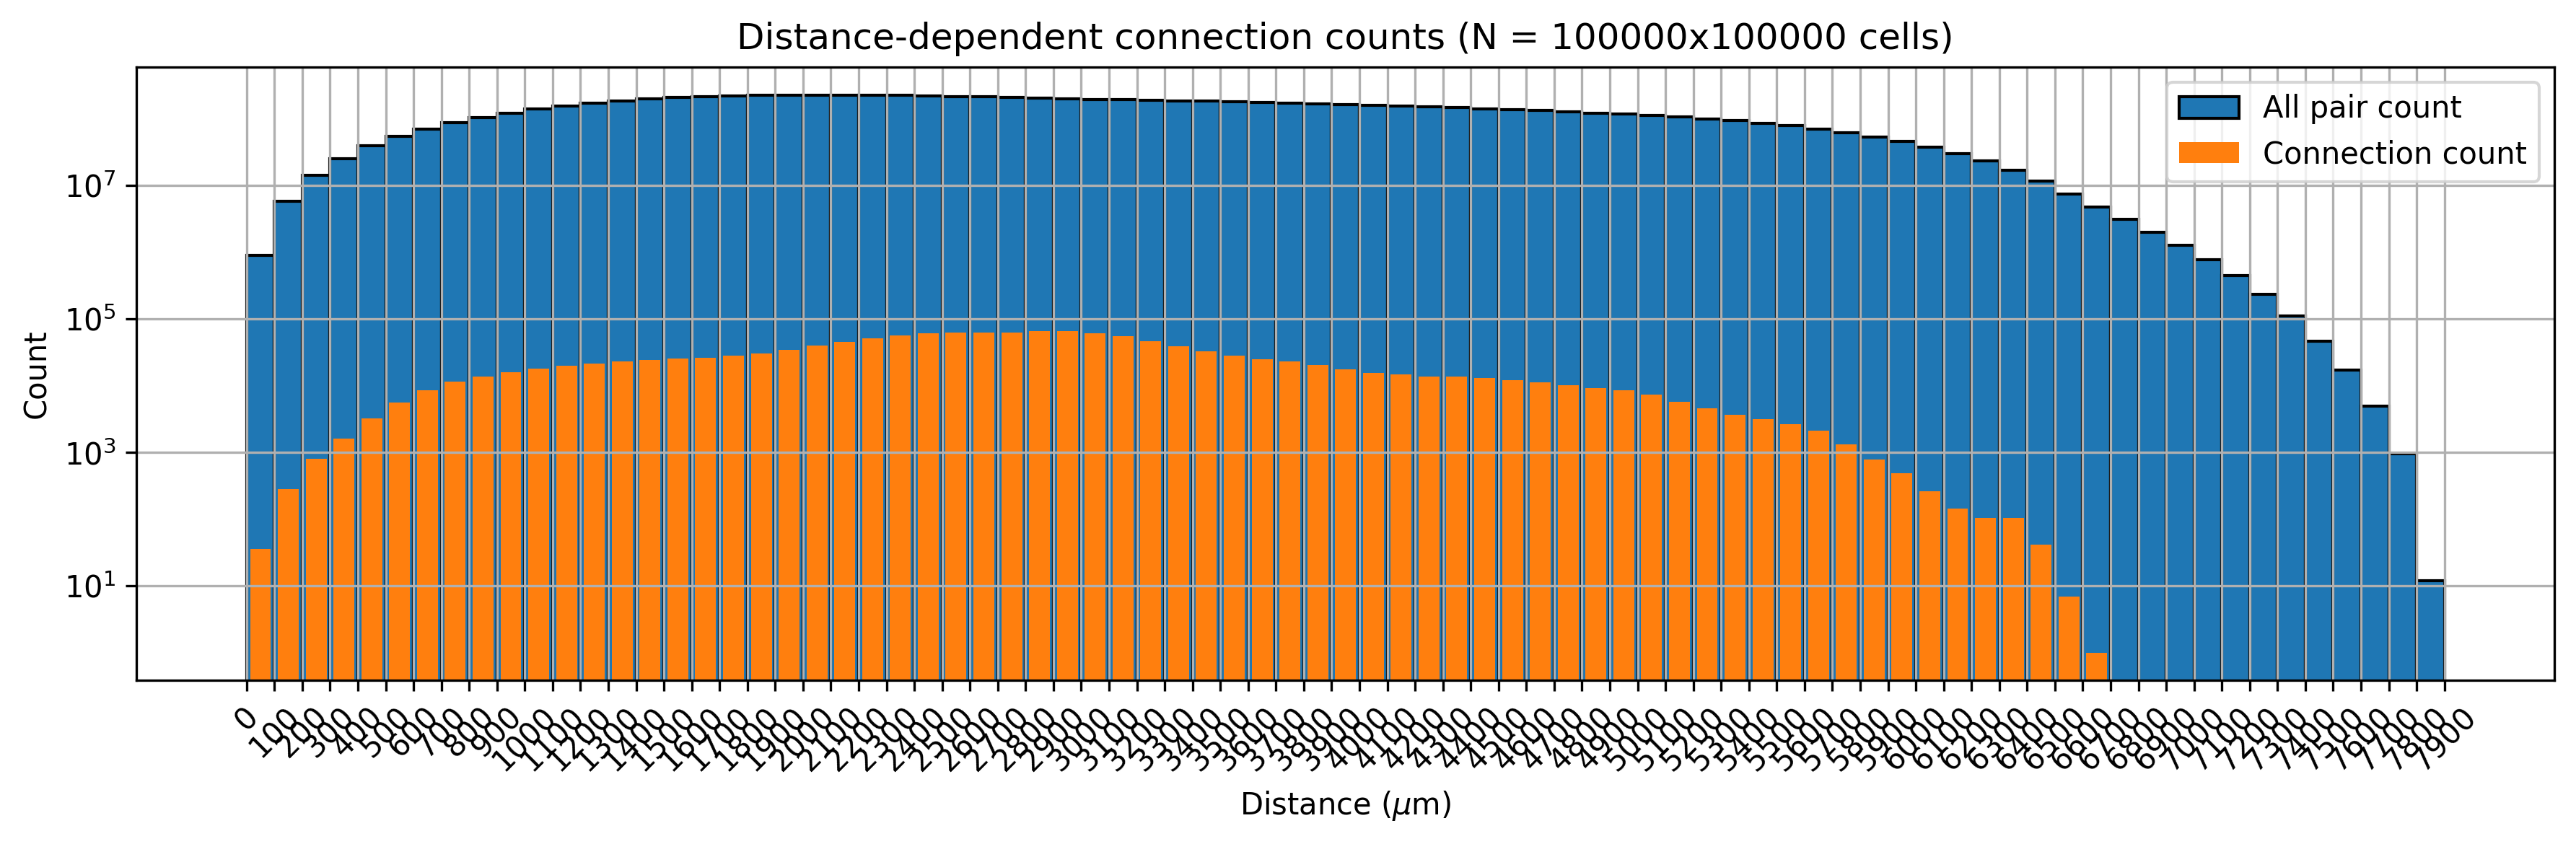

In [25]:
# Re-Run model building, but with "flat" 3D coordinate system (ss_flat_x/ss_flat_y/depth)
config_dict.update({'model_name': 'MidRConnProb2ndOrder3DFlat', 'coord_names': ['ss_flat_x', 'ss_flat_y', 'depth']})
data_dict, model_dict = modelling.run_model_building(adj_matrix, nrn_table, **config_dict)

INFO: Running order-2 model building {'bin_size_um': 100, 'max_range_um': None, 'sample_size': 100000, 'sample_seed': 4321, 'model_dir': './modelling/models', 'data_dir': './modelling/data', 'do_plot': True, 'plot_dir': './modelling/figs', 'N_split': None, 'coord_names': ['ss_flat_x', 'ss_flat_y']}...
INFO: Subsampling to 100000 of 4234929 neurons (seed=4321)
INFO: Extracting 1-dimensional (79) connection probabilities...


100% |########################################################################|


INFO: Pickled dict written to ./modelling/data/MidRConnProb2ndOrder2DFlat__data.pickle
INFO: MODEL FIT: f(x) = 0.000 * exp(-0.000 * x)
INFO: Pickled dict written to ./modelling/models/MidRConnProb2ndOrder2DFlat__model.pickle
INFO: Figure saved to /gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/connectome_analysis/data_analysis/modelling/figs/MidRConnProb2ndOrder2DFlat__data_vs_model.png
INFO: Figure saved to /gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/connectome_analysis/data_analysis/modelling/figs/MidRConnProb2ndOrder2DFlat__data_counts.png


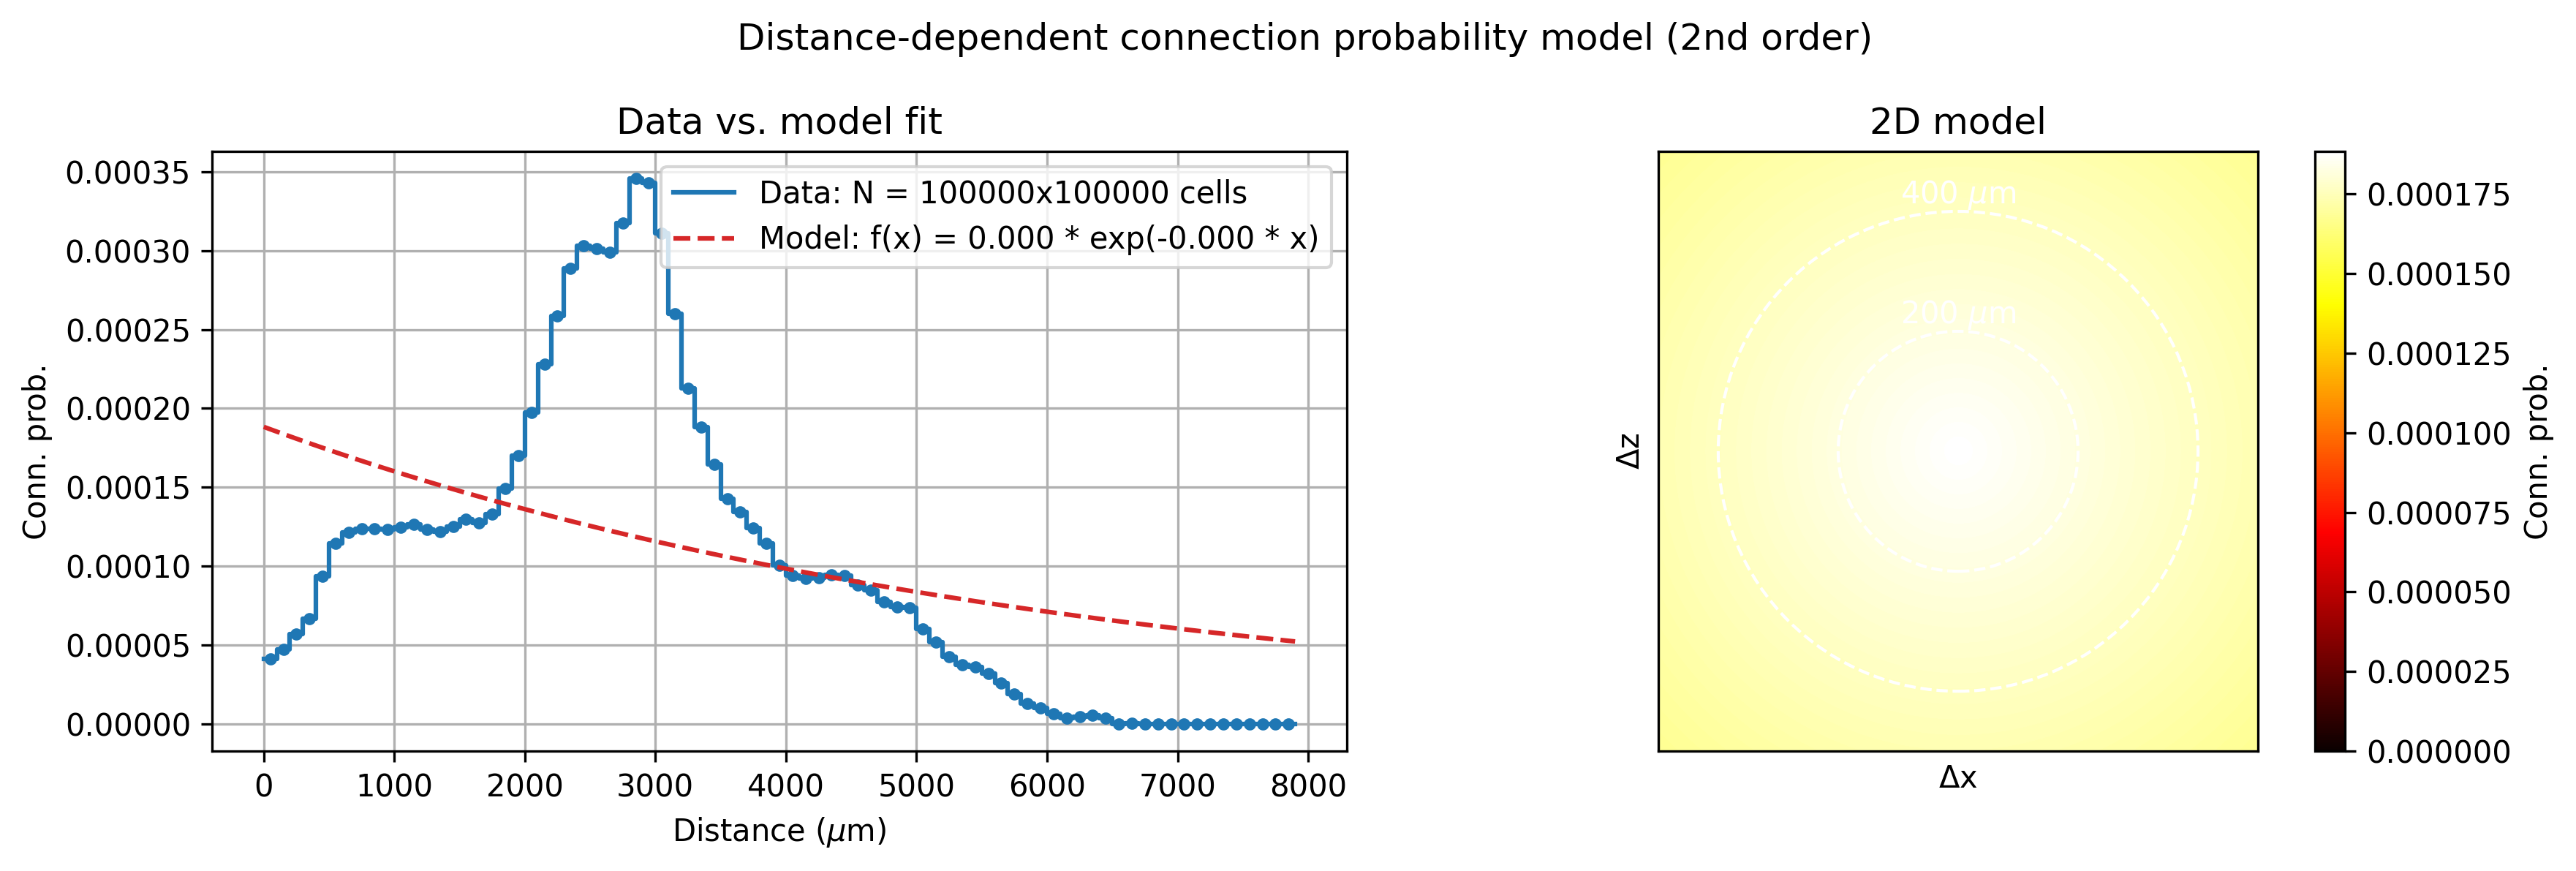

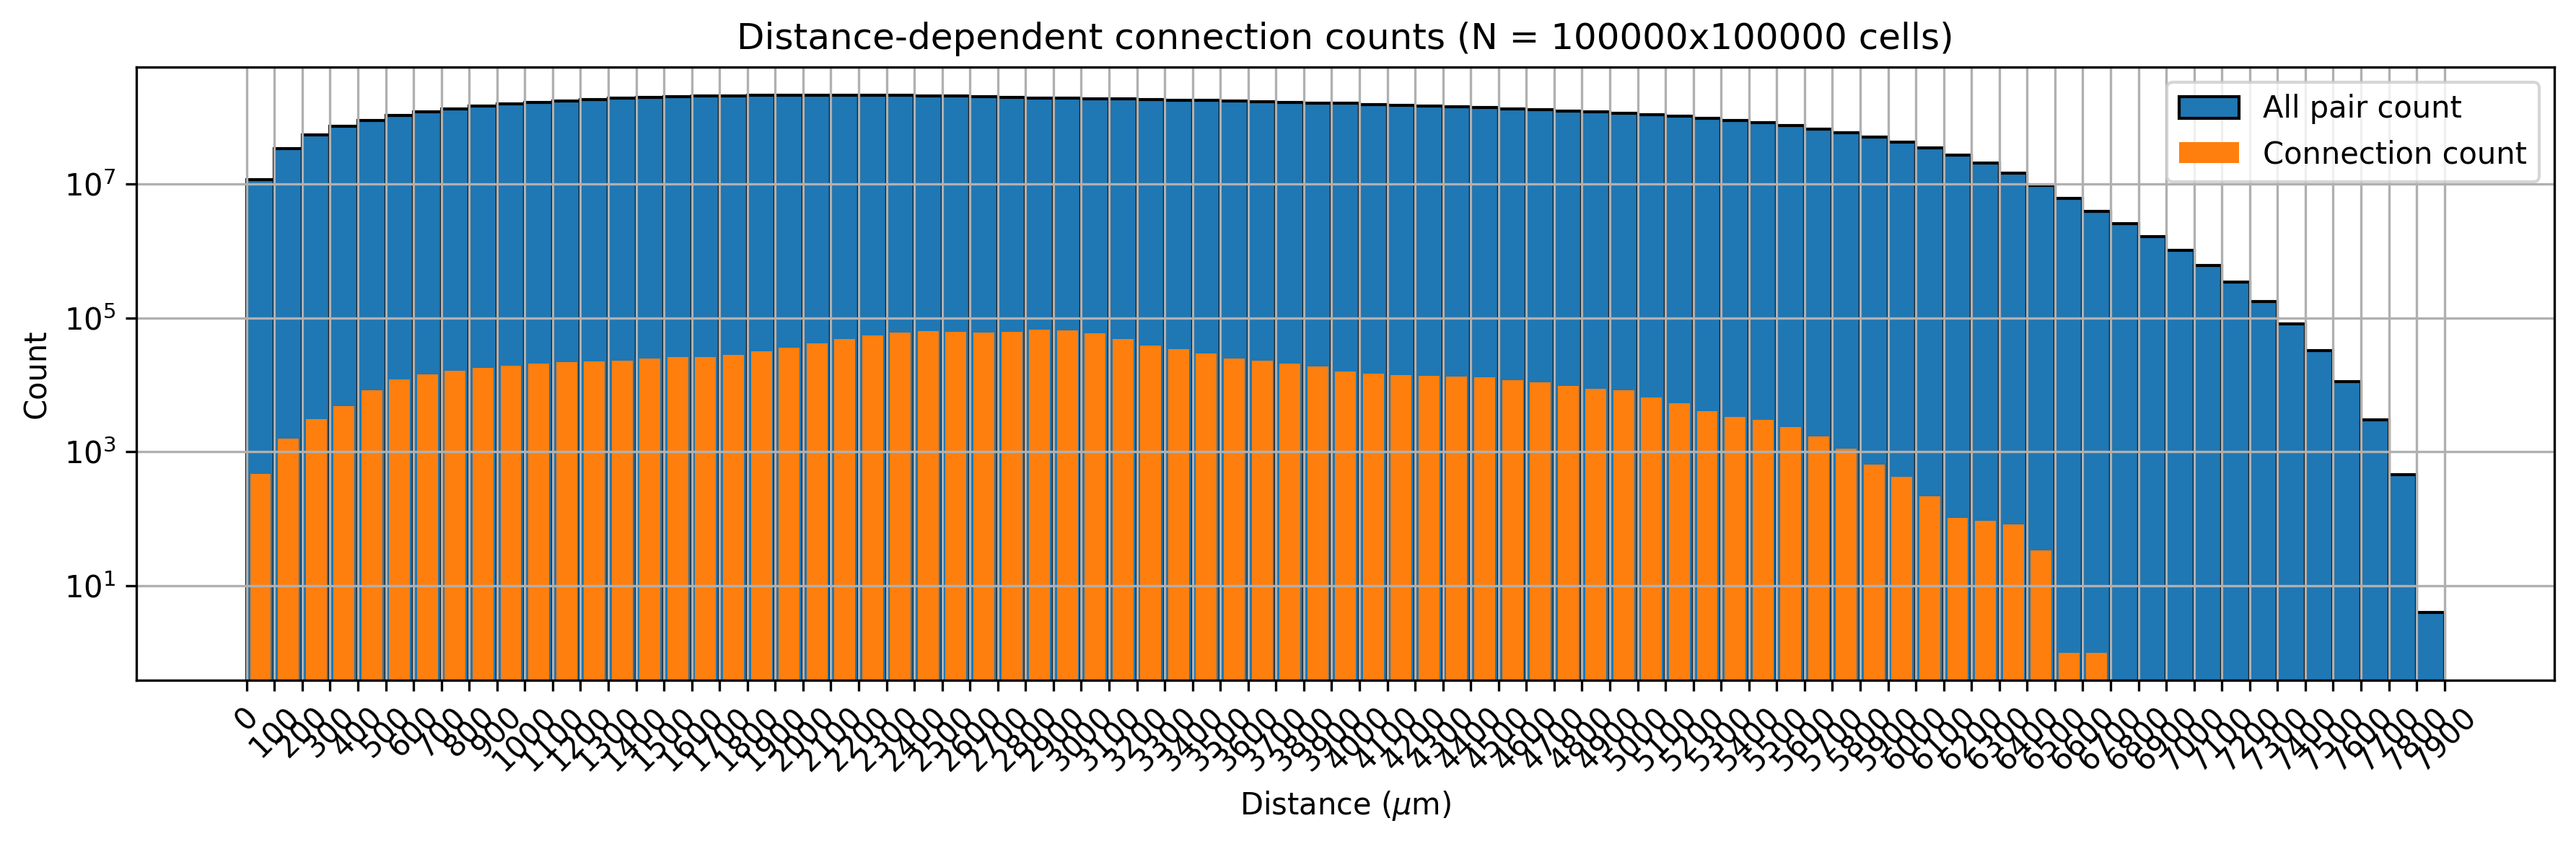

In [38]:
# Re-Run model building, but with "flat" 2D coordinate system (ss_flat_x/ss_flat_y)
config_dict.update({'model_name': 'MidRConnProb2ndOrder2DFlat', 'coord_names': ['ss_flat_x', 'ss_flat_y']})
data_dict, model_dict = modelling.run_model_building(adj_matrix, nrn_table, **config_dict)

### Using folded "virtual" flat coordinate system

In [8]:
# Configure model building
config_dict = {'model_name': 'MidRConnProb2ndOrder2DVirtual', # Name of the model (to be used in file names, ...)
               'model_order': 2,                     # Model order
               'bin_size_um': 10,                    # Bin size (um) for depth binning
               'max_range_um': None,                 # Max. distance (um) range to consider (None to use full distance range)
               'sample_size': 100000,                # Size of random subset of neurons to consider (0 or None to disable subsampling)
               'sample_seed': 4321,                  # Seed for selecting random subset of neurons
               'model_dir': './modelling/models',    # Output directory where to save the model (None to disable saving)
               'data_dir': './modelling/data',       # Output directory where to save the extracted data (None to disable saving)
               'do_plot': True,                      # Enable/disable output plotting
               'plot_dir': './modelling/figs',       # Output directory where to save the plots (None to disable saving)
               'N_split': None,                      # Number of data splits to sequentially run computations on, reducing memory consumption (None or 1 to disable splitting)
               'coord_names': ['ss_mapping_x', 'ss_mapping_y']} # Names of coordinates to use (None to use default names ['x', 'y', 'z'])

[2022-01-10 15:10:39,928] INFO: Running order-2 model building {'bin_size_um': 10, 'max_range_um': None, 'sample_size': 100000, 'sample_seed': 4321, 'model_dir': './modelling/models', 'data_dir': './modelling/data', 'do_plot': True, 'plot_dir': './modelling/figs', 'N_split': None, 'coord_names': ['ss_mapping_x', 'ss_mapping_y']}...
[2022-01-10 15:10:39,929] INFO: Subsampling to 100000 of 4234929 neurons (seed=4321)
[2022-01-10 15:12:49,329] INFO: Extracting 1-dimensional (39) connection probabilities...


100% |########################################################################|


[2022-01-10 16:03:17,524] INFO: Pickled dict written to ./modelling/data/MidRConnProb2ndOrder2DVirtual__data.pickle
[2022-01-10 16:03:17,555] INFO: MODEL FIT: f(x) = 0.000289 * exp(-0.011566 * x)
[2022-01-10 16:03:17,557] INFO: Pickled dict written to ./modelling/models/MidRConnProb2ndOrder2DVirtual__model.pickle
[2022-01-10 16:03:18,588] INFO: Figure saved to /gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/connectome_analysis/data_analysis/pokorny/modelling/figs/MidRConnProb2ndOrder2DVirtual__data_vs_model.png
[2022-01-10 16:03:19,527] INFO: Figure saved to /gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/connectome_analysis/data_analysis/pokorny/modelling/figs/MidRConnProb2ndOrder2DVirtual__data_counts.png


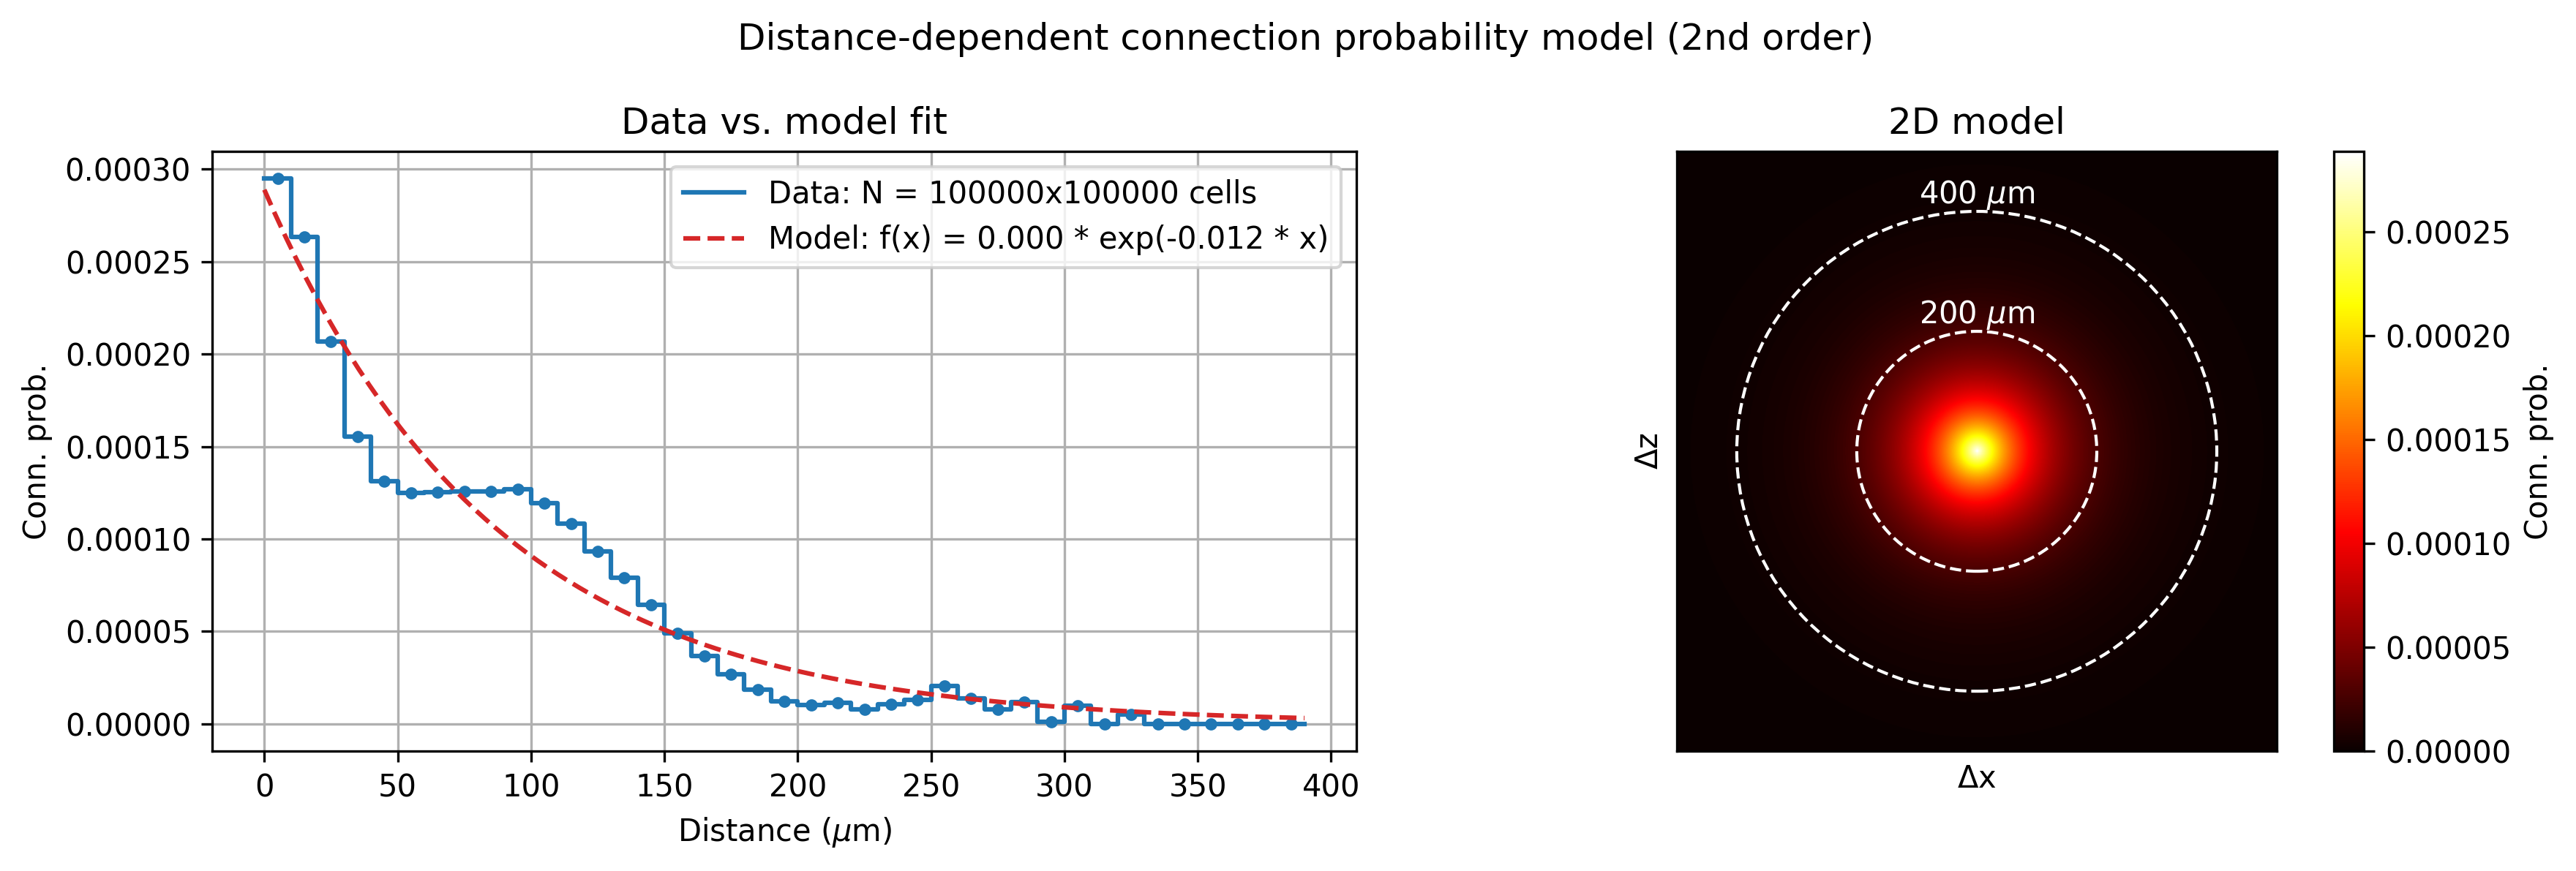

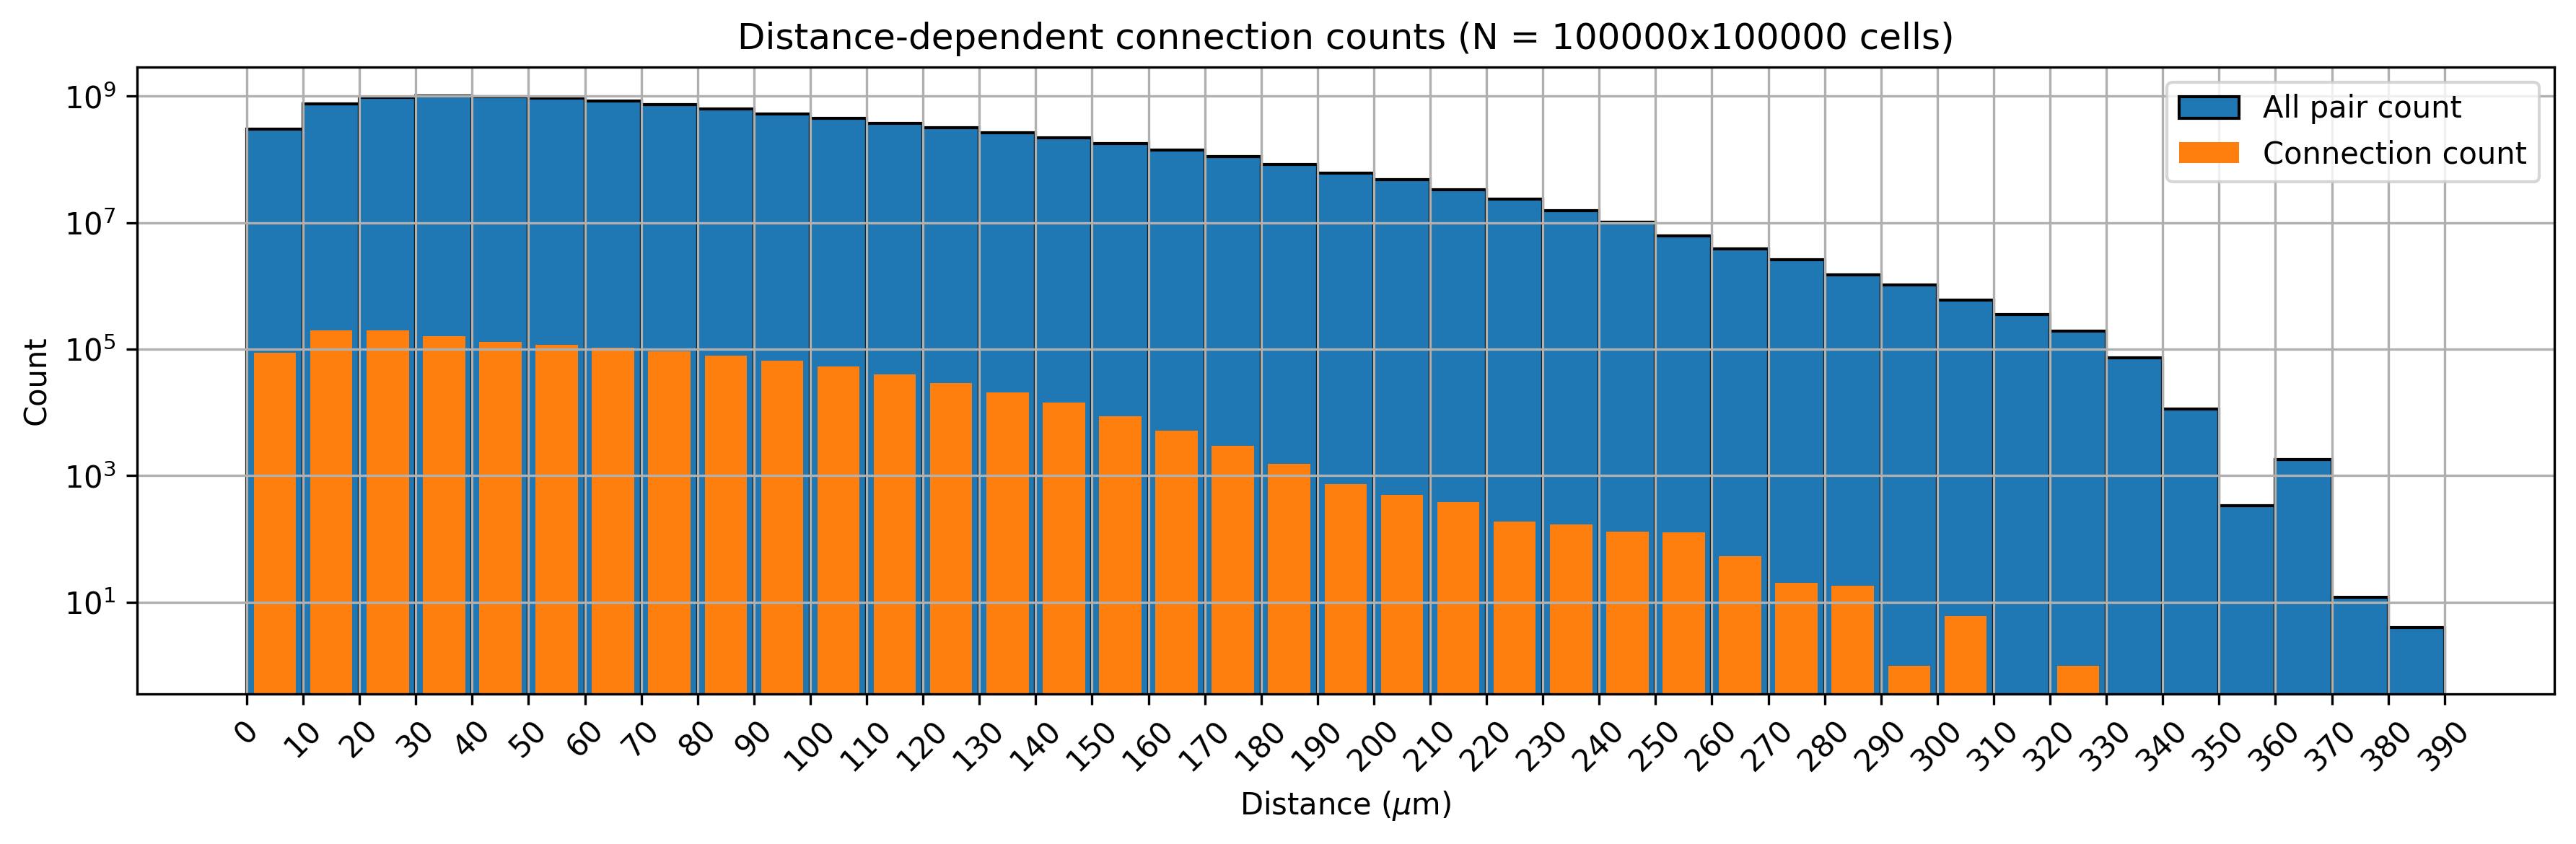

In [6]:
# Run model building, but with "virtual" 2D flat mapping coordinate system (mapping_x/mapping_y)
data_dict, model_dict = modelling.run_model_building(adj_matrix, nrn_table, **config_dict)

# NOTE: Distance unit of "virtual" coordinates is undefined, not um!!

### Run model building on subgraphs

In [14]:
# Configure model building
base_model_name = 'MidRConnProb2ndOrder2DVirtual'
config_dict = {'model_name': base_model_name,     # Name of the model (to be used in file names, ...)
               'model_order': 2,                  # Model order
               'bin_size_um': 20,                 # Bin size (HERE: a.u.) for depth binning
               'max_range_um': 400,               # Max. distance (HERE: a.u.) range to consider (None to use full distance range)
               'sample_size': 10000,              # Size of random subset of neurons to consider (0 or None to disable subsampling)
               'sample_seed': 4321,               # Seed for selecting random subset of neurons
               'model_dir': './modelling/models', # Output directory where to save the model (None to disable saving)
               'data_dir': './modelling/data',    # Output directory where to save the extracted data (None to disable saving)
               'do_plot': True,                   # Enable/disable output plotting
               'plot_dir': './modelling/figs',    # Output directory where to save the plots (None to disable saving)
               'N_split': None,                   # Number of data splits to sequentially run computations on, reducing memory consumption (None or 1 to disable splitting)
               'coord_names': ['ss_mapping_x',    # Names of coordinates to use (None to use default names ['x', 'y', 'z'])
                               'ss_mapping_y']}

RUNNING subgraph modelling with 1%...
[2022-01-17 15:53:32,330] INFO: Running order-2 model building {'bin_size_um': 20, 'max_range_um': 400, 'sample_size': 10000, 'sample_seed': 4321, 'model_dir': './modelling/models', 'data_dir': './modelling/data', 'do_plot': True, 'plot_dir': './modelling/figs', 'N_split': None, 'coord_names': ['ss_mapping_x', 'ss_mapping_y']}...
[2022-01-17 15:53:32,331] INFO: Subsampling to 10000 of 4234929 neurons (seed=4321)
[2022-01-17 15:53:33,636] INFO: Extracting 1-dimensional (20) connection probabilities...


[2022-01-17 15:53:50,763] INFO: Pickled dict written to ./modelling/data/MidRConnProb2ndOrder2DVirtual_1pct__data.pickle
[2022-01-17 15:53:50,765] INFO: MODEL FIT: f(x) = 0.000003 * exp(-0.015516 * x)
[2022-01-17 15:53:50,766] INFO: Pickled dict written to ./modelling/models/MidRConnProb2ndOrder2DVirtual_1pct__model.pickle



../../library/modelling.py:314: RuntimeWarning: invalid value encountered in true_divide
  p_conn = np.array(count_conn / count_all)


[2022-01-17 15:53:51,784] INFO: Figure saved to /gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/connectome_analysis/data_analysis/pokorny/modelling/figs/MidRConnProb2ndOrder2DVirtual_1pct__data_vs_model.png
[2022-01-17 15:53:52,696] INFO: Figure saved to /gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/connectome_analysis/data_analysis/pokorny/modelling/figs/MidRConnProb2ndOrder2DVirtual_1pct__data_counts.png
RUNNING subgraph modelling with 10%...
[2022-01-17 15:53:53,955] INFO: Running order-2 model building {'bin_size_um': 20, 'max_range_um': 400, 'sample_size': 10000, 'sample_seed': 4321, 'model_dir': './modelling/models', 'data_dir': './modelling/data', 'do_plot': True, 'plot_dir': './modelling/figs', 'N_split': None, 'coord_names': ['ss_mapping_x', 'ss_mapping_y']}...
[2022-01-17 15:53:53,956] INFO: Subsampling to 10000 of 4234929 neurons (seed=4321)
[2022-01-17 15:53:55,263] INFO: Extracting 1-dimensional (20) connection probabilities...


[2022-01-17 15:54:12,351] INFO: Pickled dict written to ./modelling/data/MidRConnProb2ndOrder2DVirtual_10pct__data.pickle
[2022-01-17 15:54:12,353] INFO: MODEL FIT: f(x) = 0.000031 * exp(-0.012759 * x)
[2022-01-17 15:54:12,357] INFO: Pickled dict written to ./modelling/models/MidRConnProb2ndOrder2DVirtual_10pct__model.pickle



../../library/modelling.py:314: RuntimeWarning: invalid value encountered in true_divide
  p_conn = np.array(count_conn / count_all)


[2022-01-17 15:54:13,183] INFO: Figure saved to /gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/connectome_analysis/data_analysis/pokorny/modelling/figs/MidRConnProb2ndOrder2DVirtual_10pct__data_vs_model.png
[2022-01-17 15:54:14,174] INFO: Figure saved to /gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/connectome_analysis/data_analysis/pokorny/modelling/figs/MidRConnProb2ndOrder2DVirtual_10pct__data_counts.png
RUNNING subgraph modelling with 20%...
[2022-01-17 15:54:16,392] INFO: Running order-2 model building {'bin_size_um': 20, 'max_range_um': 400, 'sample_size': 10000, 'sample_seed': 4321, 'model_dir': './modelling/models', 'data_dir': './modelling/data', 'do_plot': True, 'plot_dir': './modelling/figs', 'N_split': None, 'coord_names': ['ss_mapping_x', 'ss_mapping_y']}...
[2022-01-17 15:54:16,393] INFO: Subsampling to 10000 of 4234929 neurons (seed=4321)
[2022-01-17 15:54:17,726] INFO: Extracting 1-dimensional (20) connection probabilities...


[2022-01-17 15:54:34,873] INFO: Pickled dict written to ./modelling/data/MidRConnProb2ndOrder2DVirtual_20pct__data.pickle
[2022-01-17 15:54:34,877] INFO: MODEL FIT: f(x) = 0.000062 * exp(-0.012695 * x)
[2022-01-17 15:54:34,879] INFO: Pickled dict written to ./modelling/models/MidRConnProb2ndOrder2DVirtual_20pct__model.pickle



../../library/modelling.py:314: RuntimeWarning: invalid value encountered in true_divide
  p_conn = np.array(count_conn / count_all)


[2022-01-17 15:54:35,697] INFO: Figure saved to /gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/connectome_analysis/data_analysis/pokorny/modelling/figs/MidRConnProb2ndOrder2DVirtual_20pct__data_vs_model.png
[2022-01-17 15:54:36,609] INFO: Figure saved to /gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/connectome_analysis/data_analysis/pokorny/modelling/figs/MidRConnProb2ndOrder2DVirtual_20pct__data_counts.png
RUNNING subgraph modelling with 30%...
[2022-01-17 15:54:39,718] INFO: Running order-2 model building {'bin_size_um': 20, 'max_range_um': 400, 'sample_size': 10000, 'sample_seed': 4321, 'model_dir': './modelling/models', 'data_dir': './modelling/data', 'do_plot': True, 'plot_dir': './modelling/figs', 'N_split': None, 'coord_names': ['ss_mapping_x', 'ss_mapping_y']}...
[2022-01-17 15:54:39,718] INFO: Subsampling to 10000 of 4234929 neurons (seed=4321)
[2022-01-17 15:54:41,107] INFO: Extracting 1-dimensional (20) connection probabilities...


[2022-01-17 15:54:58,278] INFO: Pickled dict written to ./modelling/data/MidRConnProb2ndOrder2DVirtual_30pct__data.pickle
[2022-01-17 15:54:58,281] INFO: MODEL FIT: f(x) = 0.000092 * exp(-0.012759 * x)
[2022-01-17 15:54:58,284] INFO: Pickled dict written to ./modelling/models/MidRConnProb2ndOrder2DVirtual_30pct__model.pickle



../../library/modelling.py:314: RuntimeWarning: invalid value encountered in true_divide
  p_conn = np.array(count_conn / count_all)


[2022-01-17 15:54:59,082] INFO: Figure saved to /gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/connectome_analysis/data_analysis/pokorny/modelling/figs/MidRConnProb2ndOrder2DVirtual_30pct__data_vs_model.png
[2022-01-17 15:55:00,163] INFO: Figure saved to /gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/connectome_analysis/data_analysis/pokorny/modelling/figs/MidRConnProb2ndOrder2DVirtual_30pct__data_counts.png
RUNNING subgraph modelling with 40%...
[2022-01-17 15:55:04,304] INFO: Running order-2 model building {'bin_size_um': 20, 'max_range_um': 400, 'sample_size': 10000, 'sample_seed': 4321, 'model_dir': './modelling/models', 'data_dir': './modelling/data', 'do_plot': True, 'plot_dir': './modelling/figs', 'N_split': None, 'coord_names': ['ss_mapping_x', 'ss_mapping_y']}...
[2022-01-17 15:55:04,305] INFO: Subsampling to 10000 of 4234929 neurons (seed=4321)
[2022-01-17 15:55:05,667] INFO: Extracting 1-dimensional (20) connection probabilities...


[2022-01-17 15:55:22,837] INFO: Pickled dict written to ./modelling/data/MidRConnProb2ndOrder2DVirtual_40pct__data.pickle
[2022-01-17 15:55:22,841] INFO: MODEL FIT: f(x) = 0.000125 * exp(-0.012975 * x)
[2022-01-17 15:55:22,843] INFO: Pickled dict written to ./modelling/models/MidRConnProb2ndOrder2DVirtual_40pct__model.pickle



../../library/modelling.py:314: RuntimeWarning: invalid value encountered in true_divide
  p_conn = np.array(count_conn / count_all)


[2022-01-17 15:55:23,683] INFO: Figure saved to /gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/connectome_analysis/data_analysis/pokorny/modelling/figs/MidRConnProb2ndOrder2DVirtual_40pct__data_vs_model.png
[2022-01-17 15:55:24,595] INFO: Figure saved to /gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/connectome_analysis/data_analysis/pokorny/modelling/figs/MidRConnProb2ndOrder2DVirtual_40pct__data_counts.png
RUNNING subgraph modelling with 50%...
[2022-01-17 15:55:29,743] INFO: Running order-2 model building {'bin_size_um': 20, 'max_range_um': 400, 'sample_size': 10000, 'sample_seed': 4321, 'model_dir': './modelling/models', 'data_dir': './modelling/data', 'do_plot': True, 'plot_dir': './modelling/figs', 'N_split': None, 'coord_names': ['ss_mapping_x', 'ss_mapping_y']}...
[2022-01-17 15:55:29,744] INFO: Subsampling to 10000 of 4234929 neurons (seed=4321)
[2022-01-17 15:55:31,147] INFO: Extracting 1-dimensional (20) connection probabilities...


[2022-01-17 15:55:48,421] INFO: Pickled dict written to ./modelling/data/MidRConnProb2ndOrder2DVirtual_50pct__data.pickle
[2022-01-17 15:55:48,424] INFO: MODEL FIT: f(x) = 0.000155 * exp(-0.012840 * x)
[2022-01-17 15:55:48,428] INFO: Pickled dict written to ./modelling/models/MidRConnProb2ndOrder2DVirtual_50pct__model.pickle



../../library/modelling.py:314: RuntimeWarning: invalid value encountered in true_divide
  p_conn = np.array(count_conn / count_all)


[2022-01-17 15:55:49,282] INFO: Figure saved to /gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/connectome_analysis/data_analysis/pokorny/modelling/figs/MidRConnProb2ndOrder2DVirtual_50pct__data_vs_model.png
[2022-01-17 15:55:50,310] INFO: Figure saved to /gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/connectome_analysis/data_analysis/pokorny/modelling/figs/MidRConnProb2ndOrder2DVirtual_50pct__data_counts.png
RUNNING subgraph modelling with 60%...
[2022-01-17 15:55:56,419] INFO: Running order-2 model building {'bin_size_um': 20, 'max_range_um': 400, 'sample_size': 10000, 'sample_seed': 4321, 'model_dir': './modelling/models', 'data_dir': './modelling/data', 'do_plot': True, 'plot_dir': './modelling/figs', 'N_split': None, 'coord_names': ['ss_mapping_x', 'ss_mapping_y']}...
[2022-01-17 15:55:56,420] INFO: Subsampling to 10000 of 4234929 neurons (seed=4321)
[2022-01-17 15:55:57,831] INFO: Extracting 1-dimensional (20) connection probabilities...


[2022-01-17 15:56:14,988] INFO: Pickled dict written to ./modelling/data/MidRConnProb2ndOrder2DVirtual_60pct__data.pickle
[2022-01-17 15:56:14,992] INFO: MODEL FIT: f(x) = 0.000185 * exp(-0.012728 * x)
[2022-01-17 15:56:14,994] INFO: Pickled dict written to ./modelling/models/MidRConnProb2ndOrder2DVirtual_60pct__model.pickle



../../library/modelling.py:314: RuntimeWarning: invalid value encountered in true_divide
  p_conn = np.array(count_conn / count_all)


[2022-01-17 15:56:15,845] INFO: Figure saved to /gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/connectome_analysis/data_analysis/pokorny/modelling/figs/MidRConnProb2ndOrder2DVirtual_60pct__data_vs_model.png
[2022-01-17 15:56:16,788] INFO: Figure saved to /gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/connectome_analysis/data_analysis/pokorny/modelling/figs/MidRConnProb2ndOrder2DVirtual_60pct__data_counts.png
RUNNING subgraph modelling with 70%...
[2022-01-17 15:56:23,906] INFO: Running order-2 model building {'bin_size_um': 20, 'max_range_um': 400, 'sample_size': 10000, 'sample_seed': 4321, 'model_dir': './modelling/models', 'data_dir': './modelling/data', 'do_plot': True, 'plot_dir': './modelling/figs', 'N_split': None, 'coord_names': ['ss_mapping_x', 'ss_mapping_y']}...
[2022-01-17 15:56:23,907] INFO: Subsampling to 10000 of 4234929 neurons (seed=4321)
[2022-01-17 15:56:25,384] INFO: Extracting 1-dimensional (20) connection probabilities...


[2022-01-17 15:56:42,564] INFO: Pickled dict written to ./modelling/data/MidRConnProb2ndOrder2DVirtual_70pct__data.pickle
[2022-01-17 15:56:42,567] INFO: MODEL FIT: f(x) = 0.000215 * exp(-0.012693 * x)
[2022-01-17 15:56:42,569] INFO: Pickled dict written to ./modelling/models/MidRConnProb2ndOrder2DVirtual_70pct__model.pickle



../../library/modelling.py:314: RuntimeWarning: invalid value encountered in true_divide
  p_conn = np.array(count_conn / count_all)


[2022-01-17 15:56:43,420] INFO: Figure saved to /gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/connectome_analysis/data_analysis/pokorny/modelling/figs/MidRConnProb2ndOrder2DVirtual_70pct__data_vs_model.png
[2022-01-17 15:56:44,339] INFO: Figure saved to /gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/connectome_analysis/data_analysis/pokorny/modelling/figs/MidRConnProb2ndOrder2DVirtual_70pct__data_counts.png
RUNNING subgraph modelling with 80%...
[2022-01-17 15:56:52,416] INFO: Running order-2 model building {'bin_size_um': 20, 'max_range_um': 400, 'sample_size': 10000, 'sample_seed': 4321, 'model_dir': './modelling/models', 'data_dir': './modelling/data', 'do_plot': True, 'plot_dir': './modelling/figs', 'N_split': None, 'coord_names': ['ss_mapping_x', 'ss_mapping_y']}...
[2022-01-17 15:56:52,417] INFO: Subsampling to 10000 of 4234929 neurons (seed=4321)
[2022-01-17 15:56:53,901] INFO: Extracting 1-dimensional (20) connection probabilities...


[2022-01-17 15:57:11,209] INFO: Pickled dict written to ./modelling/data/MidRConnProb2ndOrder2DVirtual_80pct__data.pickle
[2022-01-17 15:57:11,212] INFO: MODEL FIT: f(x) = 0.000246 * exp(-0.012699 * x)
[2022-01-17 15:57:11,213] INFO: Pickled dict written to ./modelling/models/MidRConnProb2ndOrder2DVirtual_80pct__model.pickle



../../library/modelling.py:314: RuntimeWarning: invalid value encountered in true_divide
  p_conn = np.array(count_conn / count_all)


[2022-01-17 15:57:12,113] INFO: Figure saved to /gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/connectome_analysis/data_analysis/pokorny/modelling/figs/MidRConnProb2ndOrder2DVirtual_80pct__data_vs_model.png
[2022-01-17 15:57:13,027] INFO: Figure saved to /gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/connectome_analysis/data_analysis/pokorny/modelling/figs/MidRConnProb2ndOrder2DVirtual_80pct__data_counts.png
RUNNING subgraph modelling with 90%...
[2022-01-17 15:57:35,887] INFO: Running order-2 model building {'bin_size_um': 20, 'max_range_um': 400, 'sample_size': 10000, 'sample_seed': 4321, 'model_dir': './modelling/models', 'data_dir': './modelling/data', 'do_plot': True, 'plot_dir': './modelling/figs', 'N_split': None, 'coord_names': ['ss_mapping_x', 'ss_mapping_y']}...
[2022-01-17 15:57:35,887] INFO: Subsampling to 10000 of 4234929 neurons (seed=4321)
[2022-01-17 15:57:37,485] INFO: Extracting 1-dimensional (20) connection probabilities...


[2022-01-17 15:57:54,951] INFO: Pickled dict written to ./modelling/data/MidRConnProb2ndOrder2DVirtual_90pct__data.pickle
[2022-01-17 15:57:54,954] INFO: MODEL FIT: f(x) = 0.000276 * exp(-0.012742 * x)
[2022-01-17 15:57:54,955] INFO: Pickled dict written to ./modelling/models/MidRConnProb2ndOrder2DVirtual_90pct__model.pickle



../../library/modelling.py:314: RuntimeWarning: invalid value encountered in true_divide
  p_conn = np.array(count_conn / count_all)


[2022-01-17 15:57:55,923] INFO: Figure saved to /gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/connectome_analysis/data_analysis/pokorny/modelling/figs/MidRConnProb2ndOrder2DVirtual_90pct__data_vs_model.png
[2022-01-17 15:57:56,837] INFO: Figure saved to /gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/connectome_analysis/data_analysis/pokorny/modelling/figs/MidRConnProb2ndOrder2DVirtual_90pct__data_counts.png
RUNNING subgraph modelling with 100%...
[2022-01-17 15:58:21,867] INFO: Running order-2 model building {'bin_size_um': 20, 'max_range_um': 400, 'sample_size': 10000, 'sample_seed': 4321, 'model_dir': './modelling/models', 'data_dir': './modelling/data', 'do_plot': True, 'plot_dir': './modelling/figs', 'N_split': None, 'coord_names': ['ss_mapping_x', 'ss_mapping_y']}...
[2022-01-17 15:58:21,868] INFO: Subsampling to 10000 of 4234929 neurons (seed=4321)
[2022-01-17 15:58:23,469] INFO: Extracting 1-dimensional (20) connection probabilities...


[2022-01-17 15:58:40,774] INFO: Pickled dict written to ./modelling/data/MidRConnProb2ndOrder2DVirtual_100pct__data.pickle
[2022-01-17 15:58:40,777] INFO: MODEL FIT: f(x) = 0.000307 * exp(-0.012680 * x)
[2022-01-17 15:58:40,778] INFO: Pickled dict written to ./modelling/models/MidRConnProb2ndOrder2DVirtual_100pct__model.pickle



../../library/modelling.py:314: RuntimeWarning: invalid value encountered in true_divide
  p_conn = np.array(count_conn / count_all)
../../library/modelling.py:408: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12, 4), dpi=300)


[2022-01-17 15:58:41,623] INFO: Figure saved to /gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/connectome_analysis/data_analysis/pokorny/modelling/figs/MidRConnProb2ndOrder2DVirtual_100pct__data_vs_model.png
[2022-01-17 15:58:42,643] INFO: Figure saved to /gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/connectome_analysis/data_analysis/pokorny/modelling/figs/MidRConnProb2ndOrder2DVirtual_100pct__data_counts.png


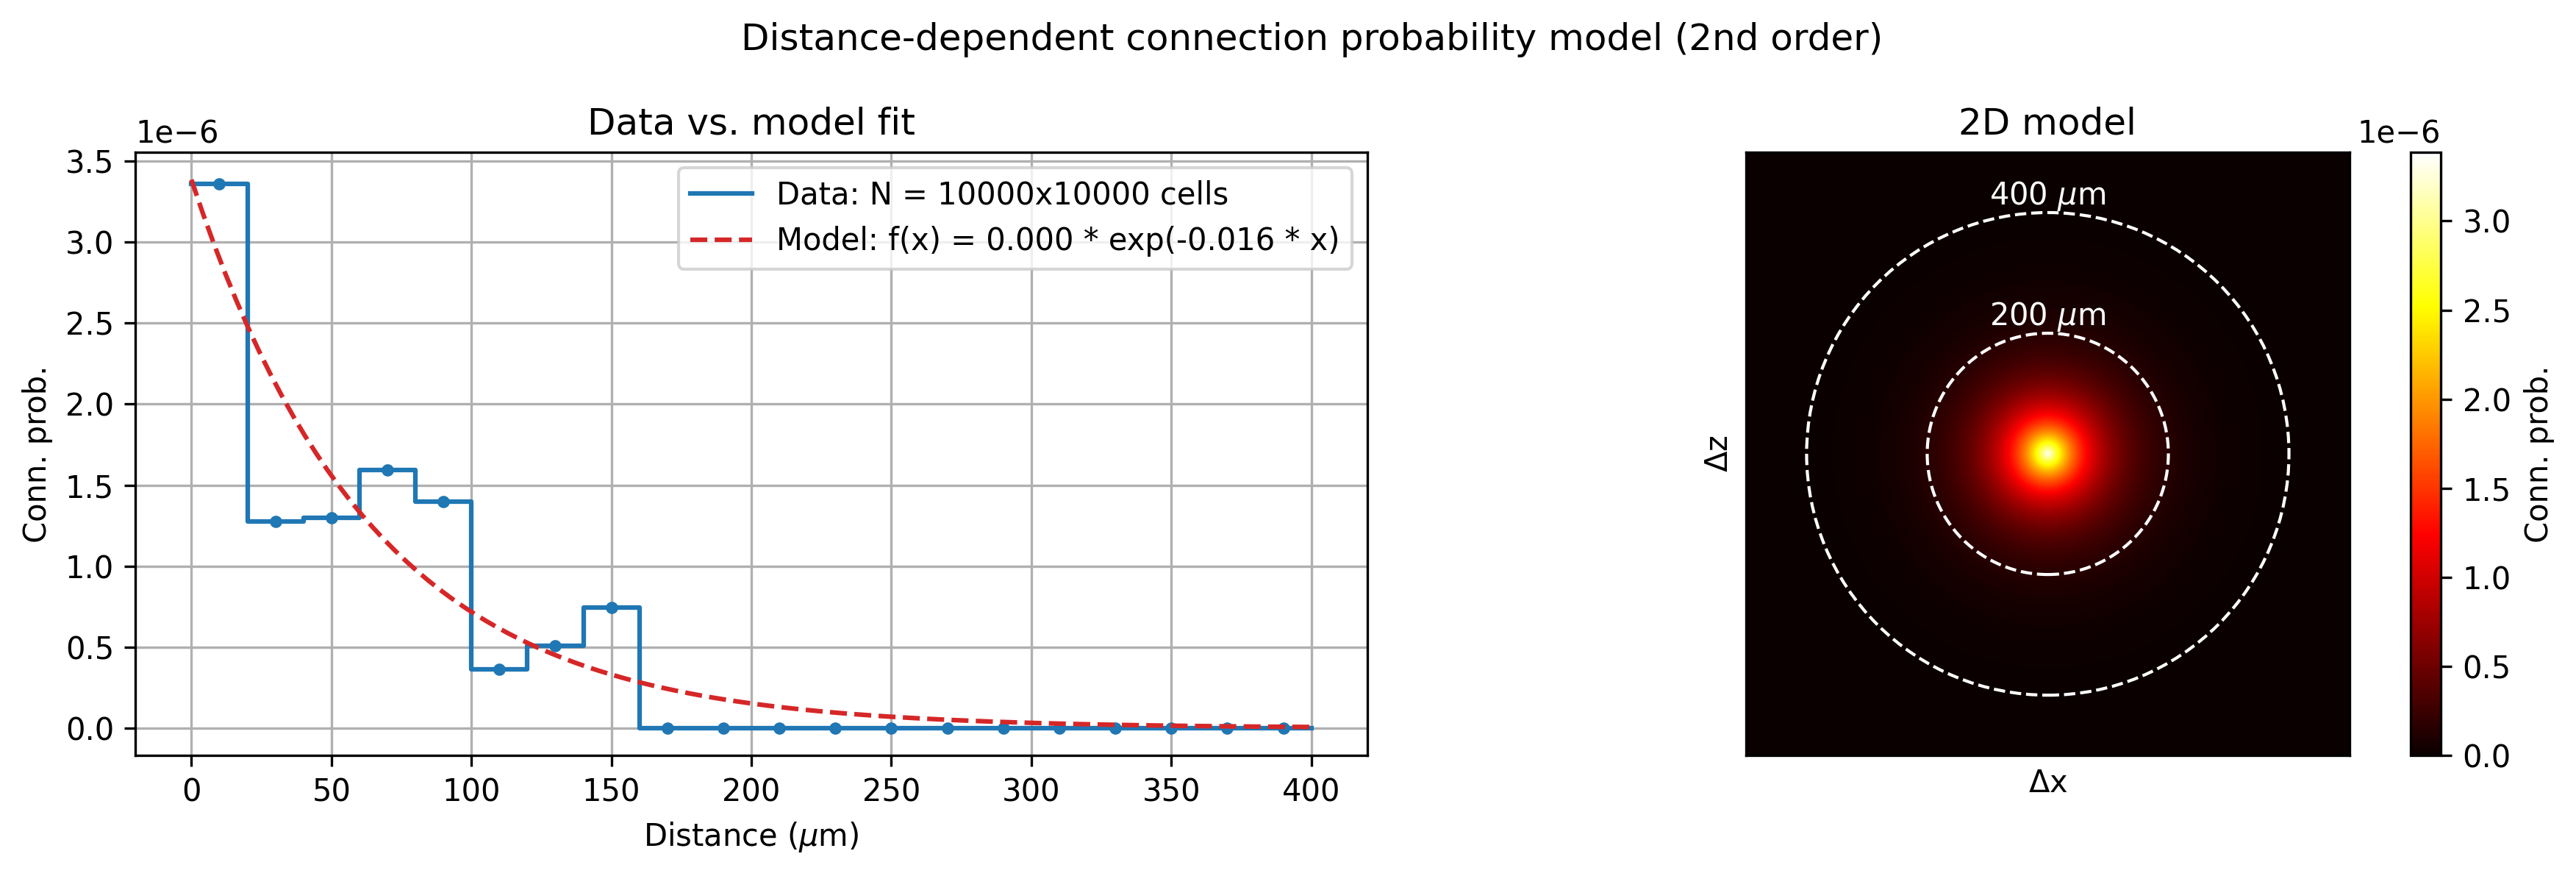

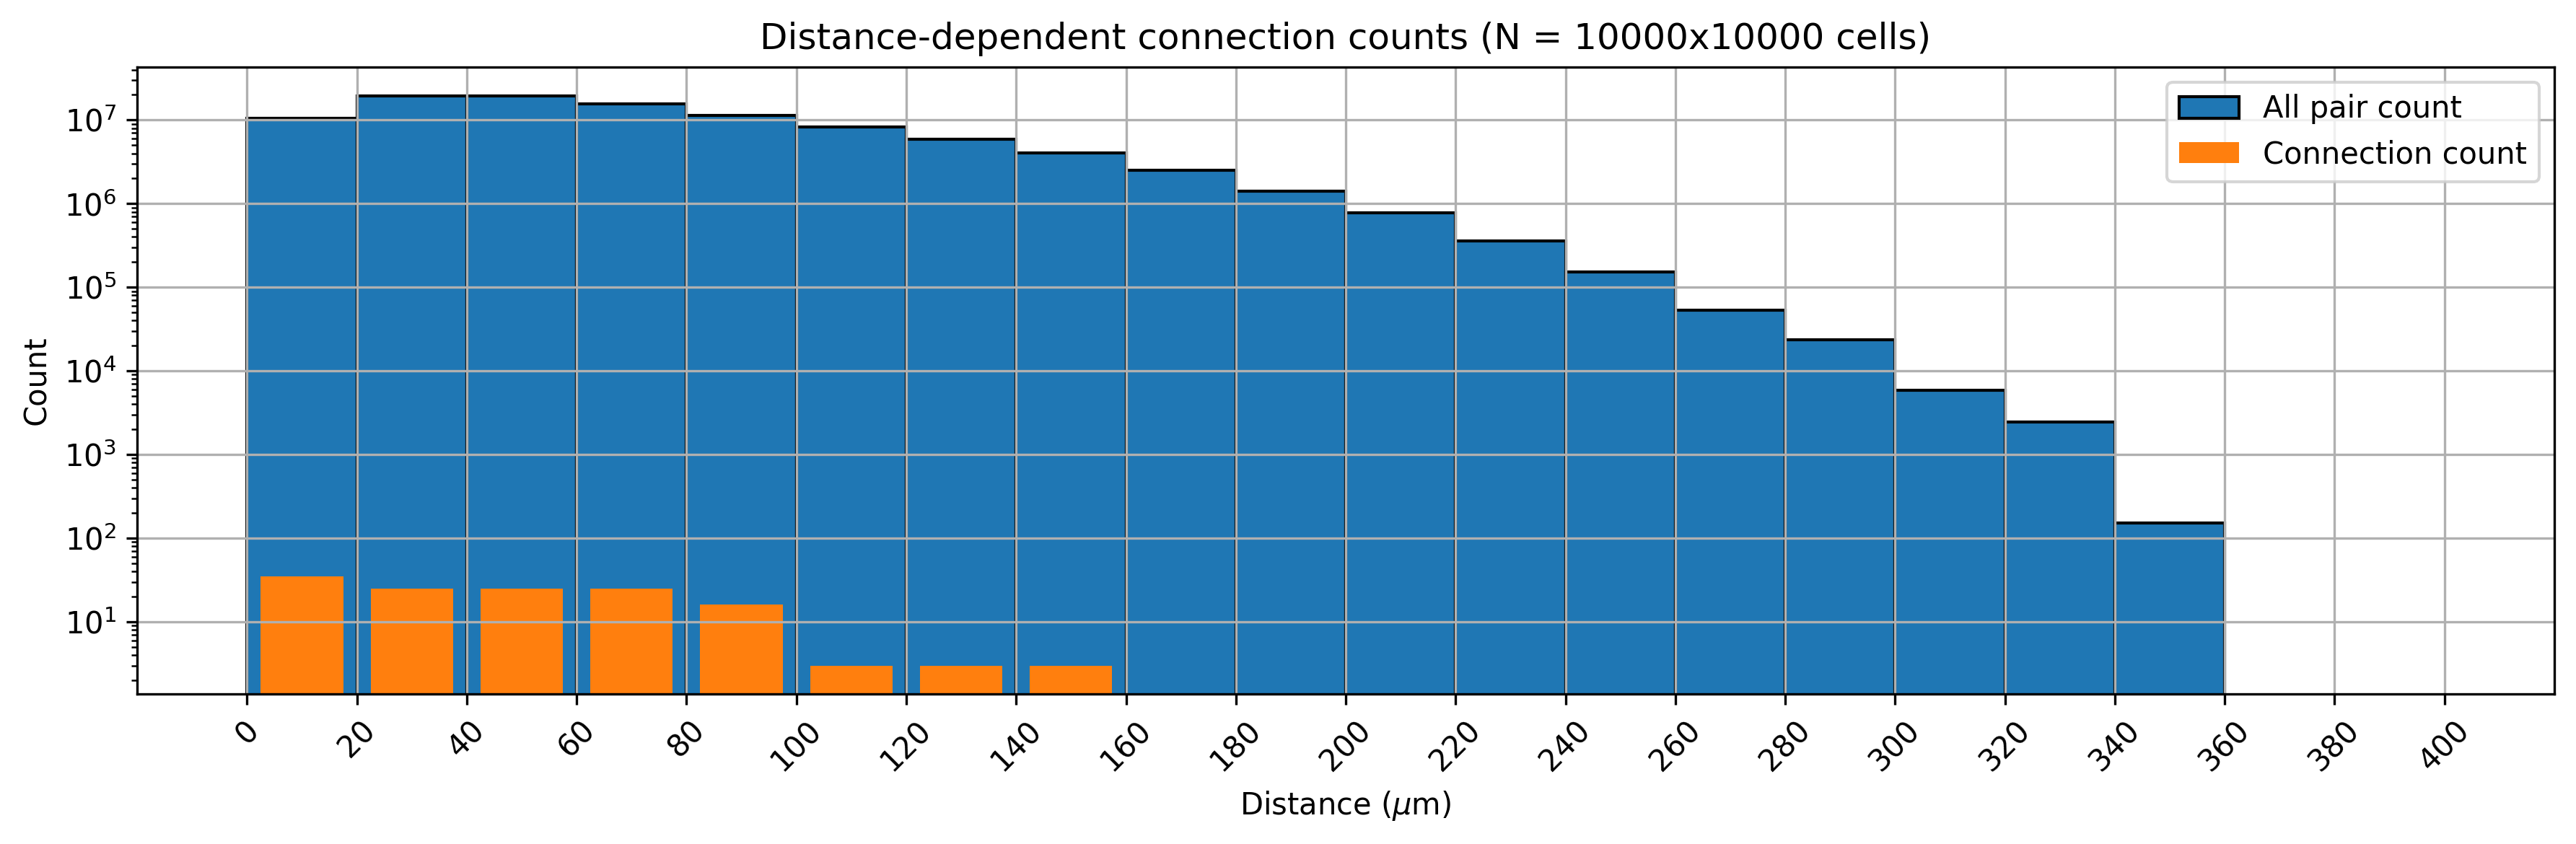

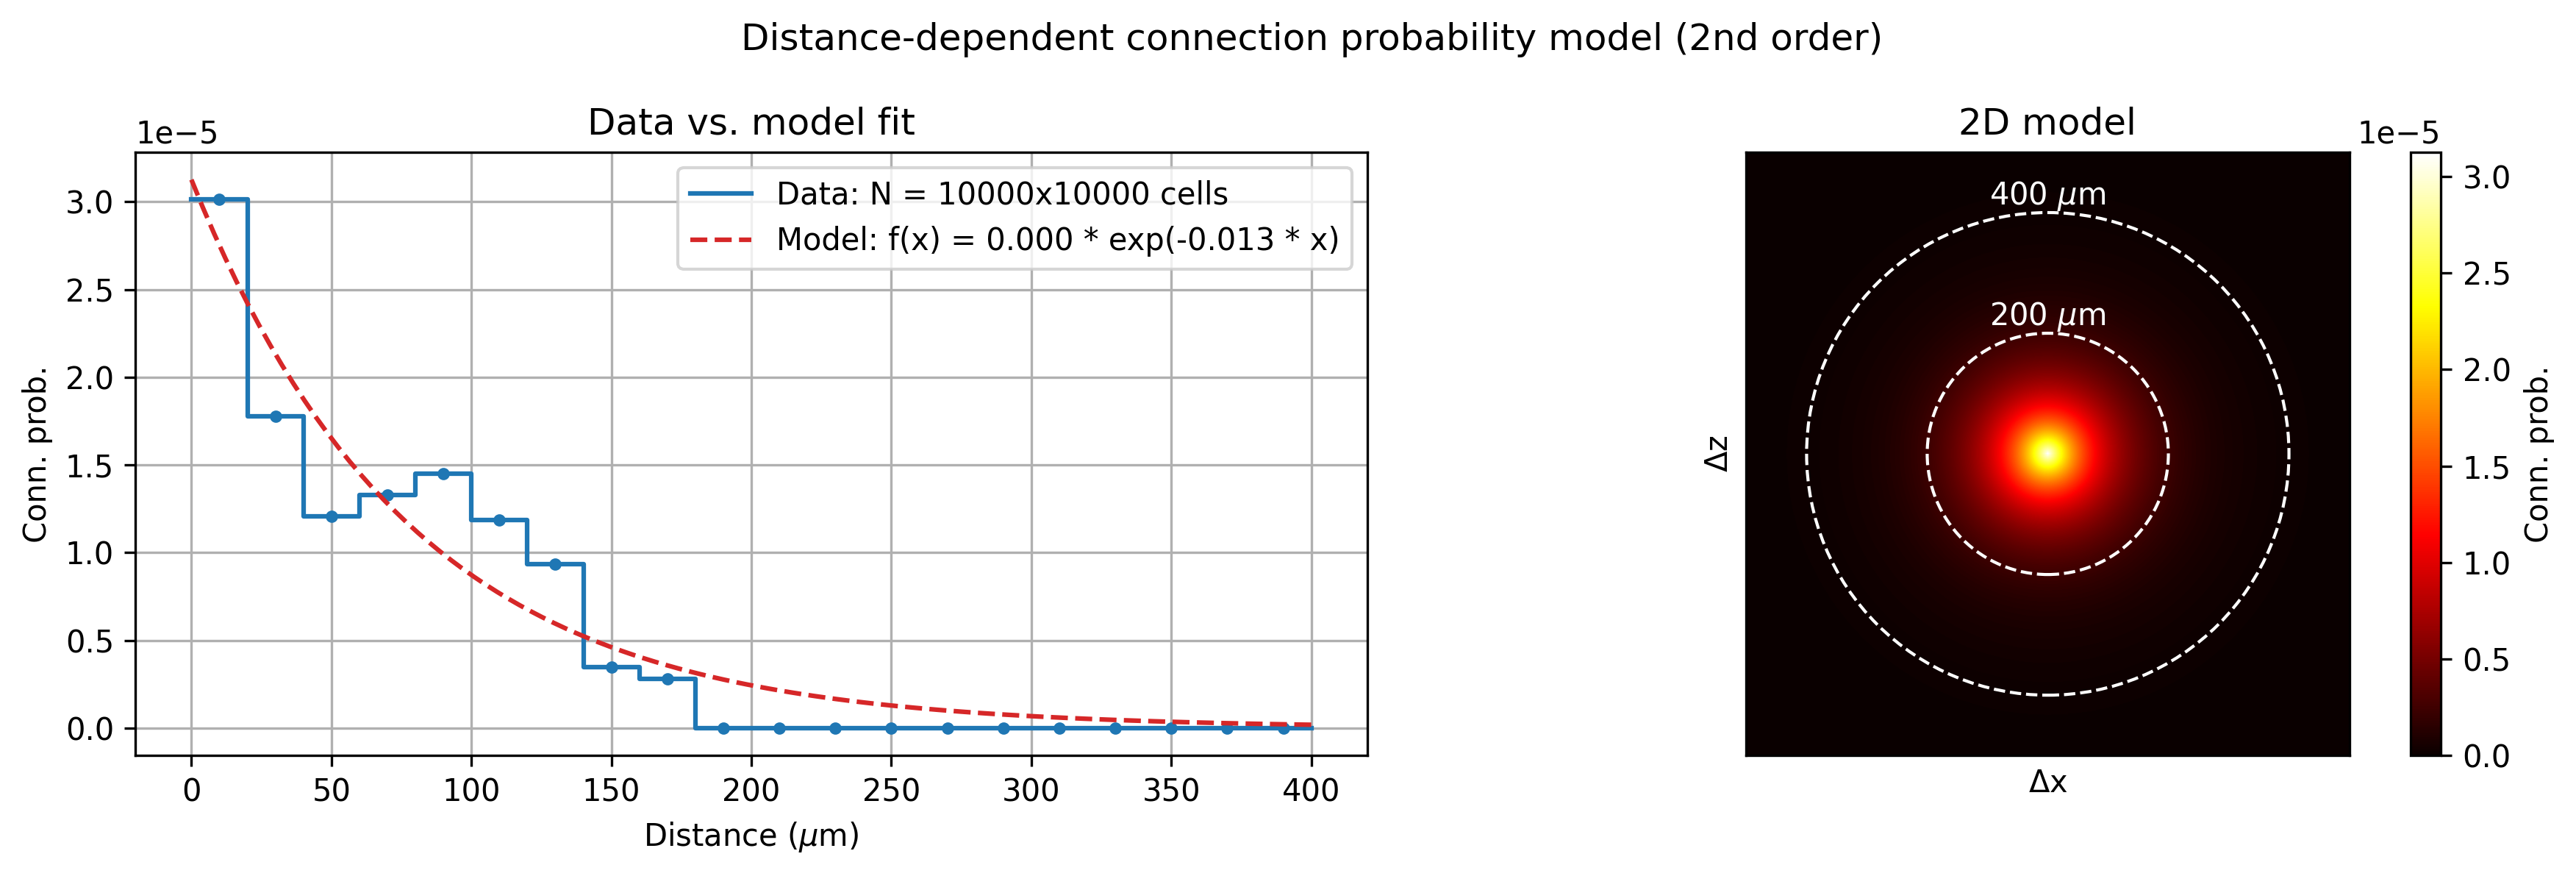

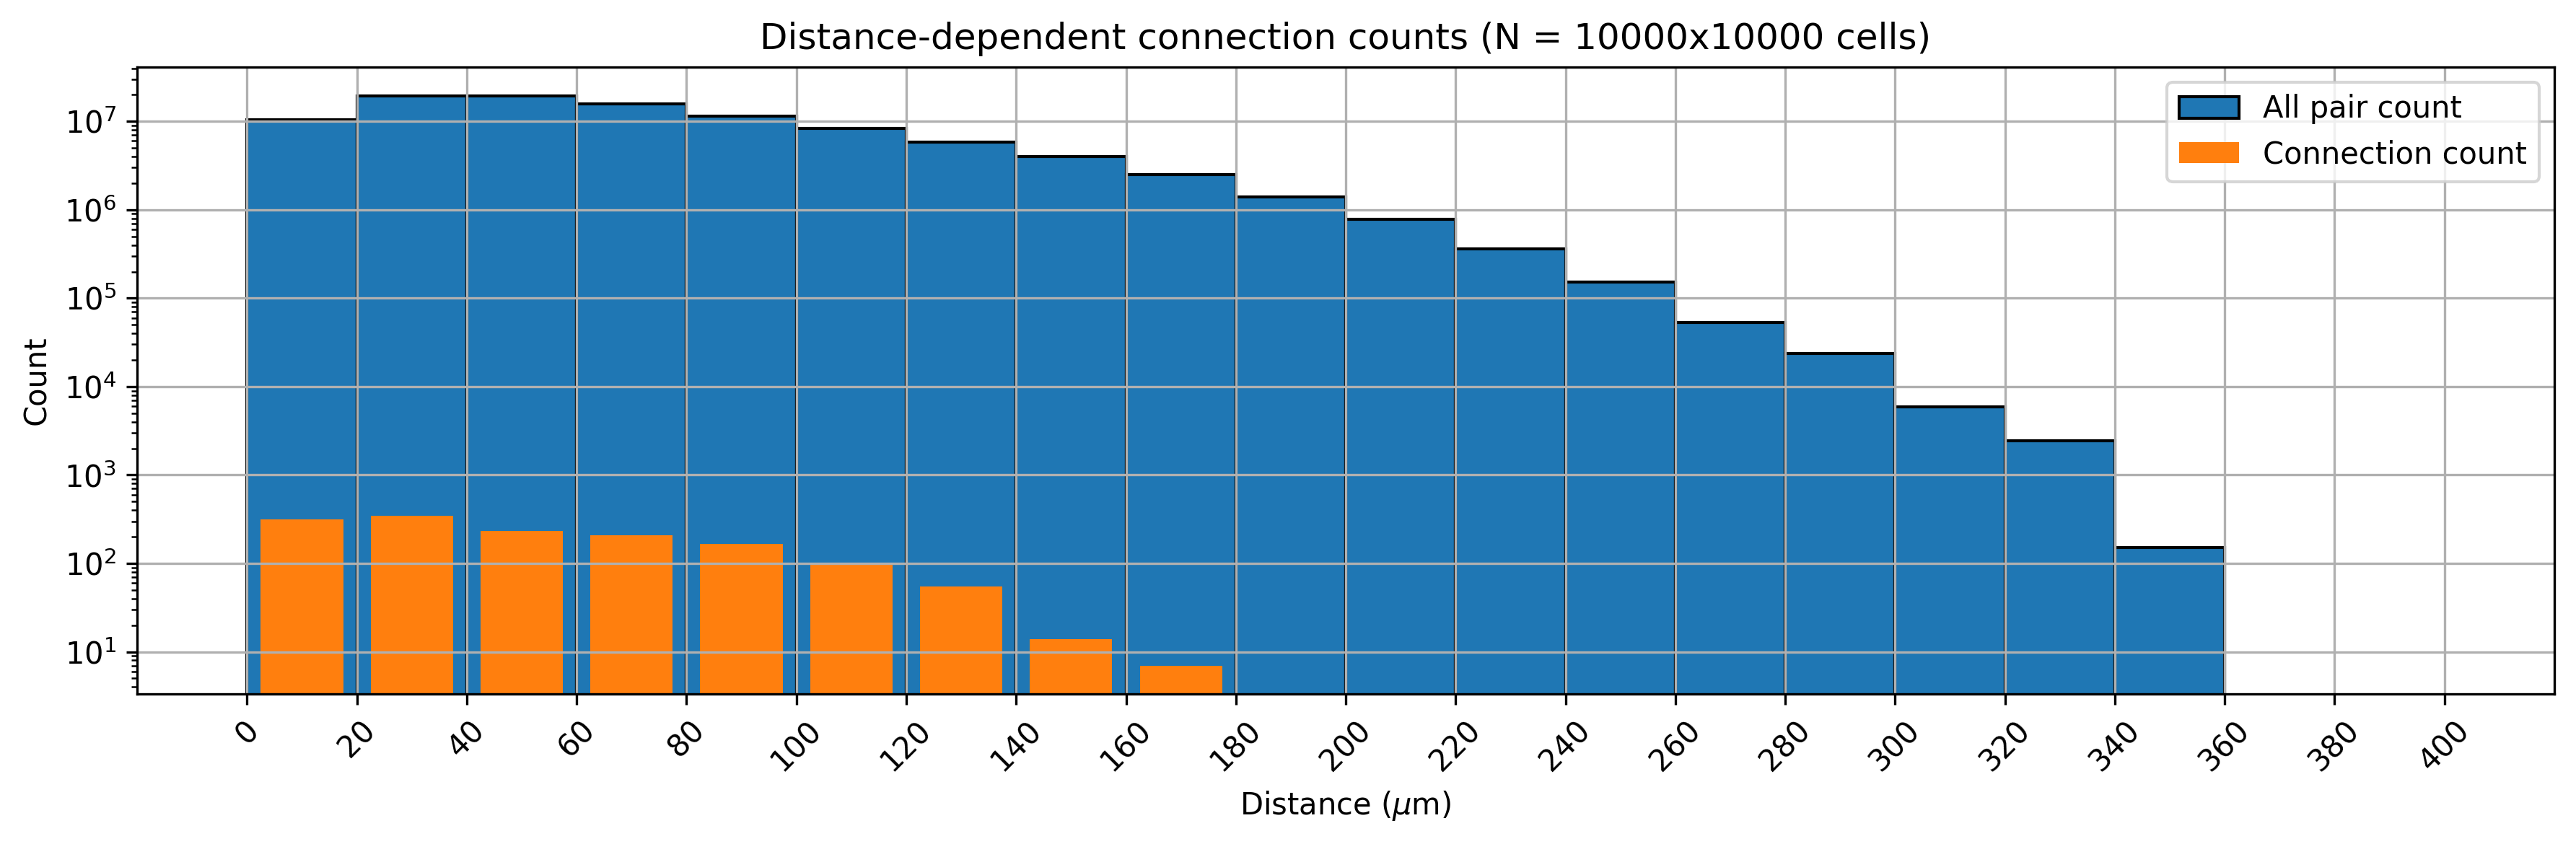

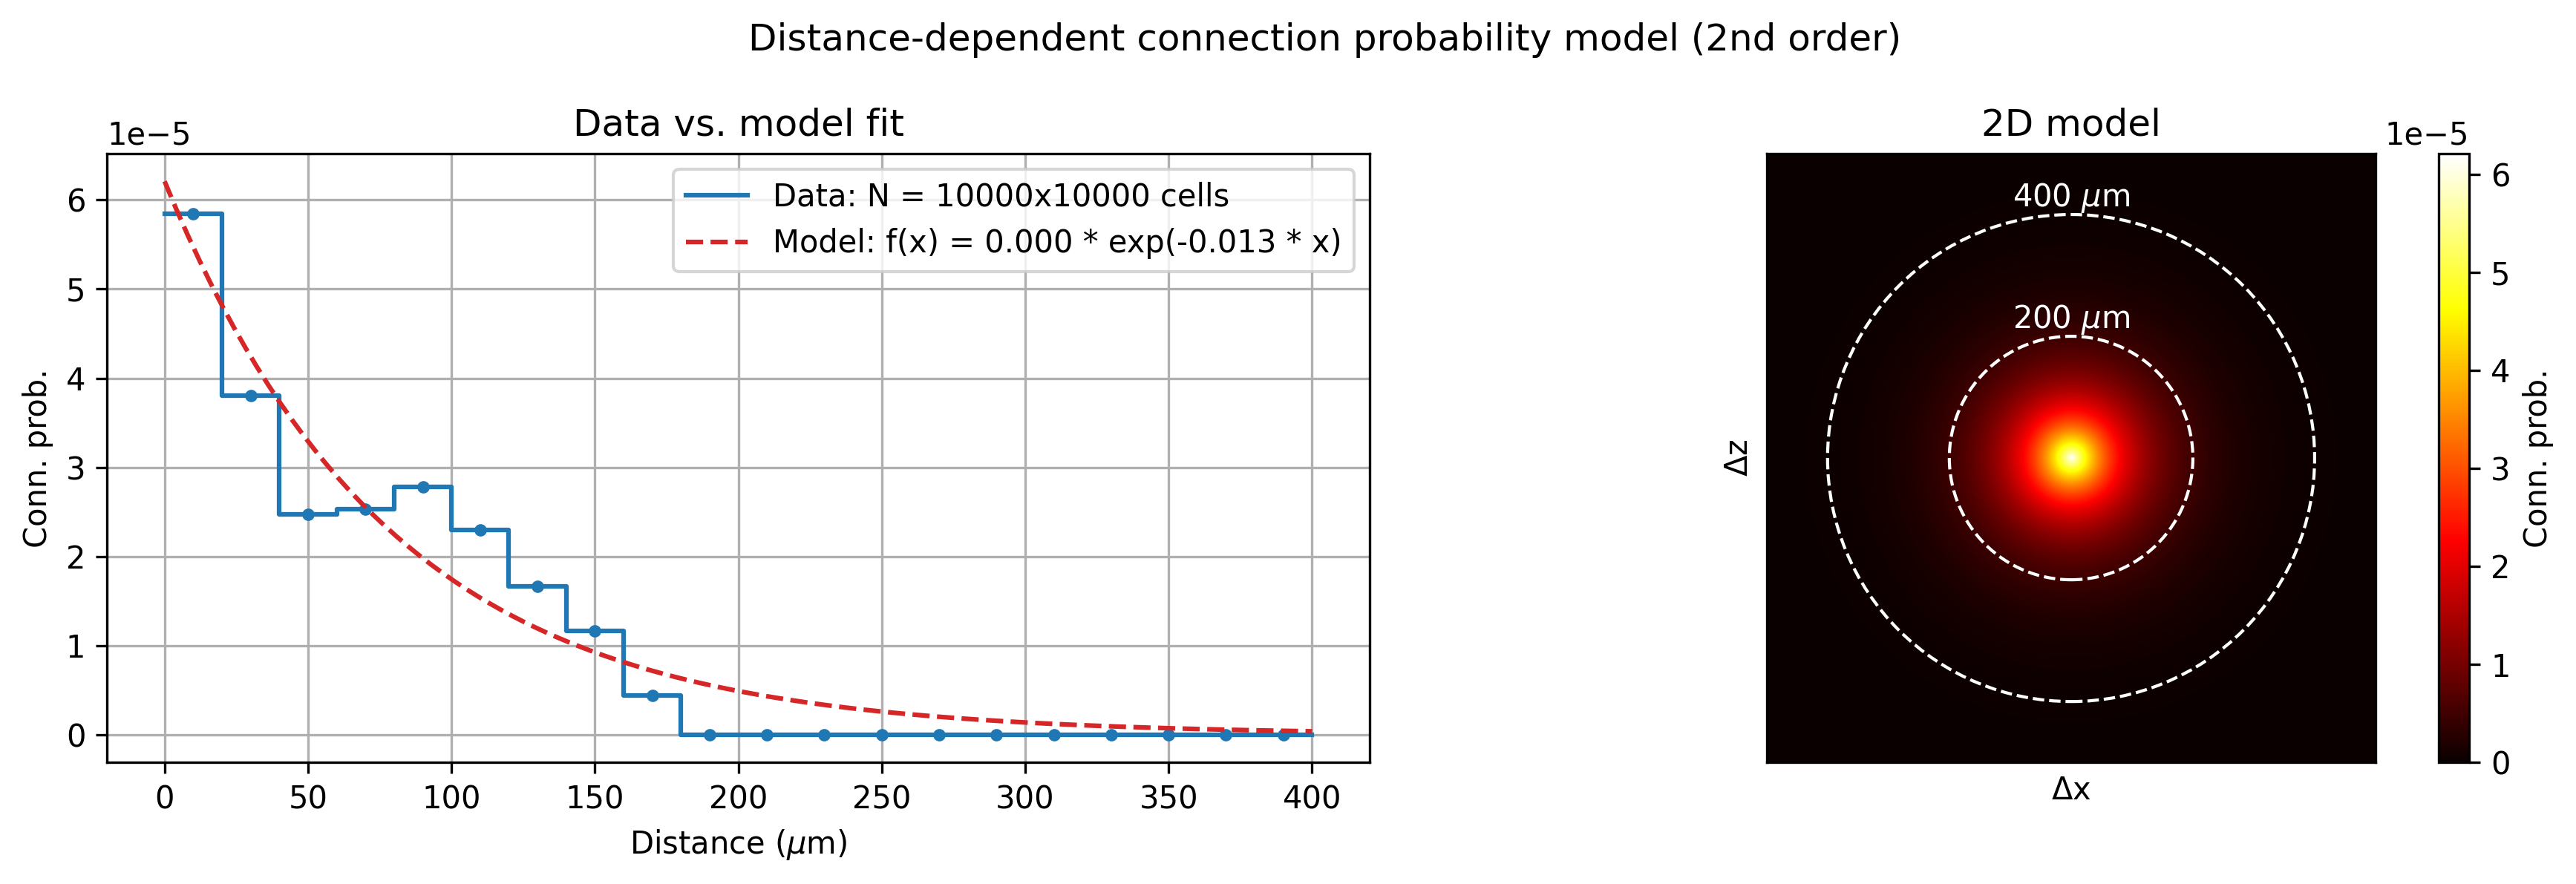

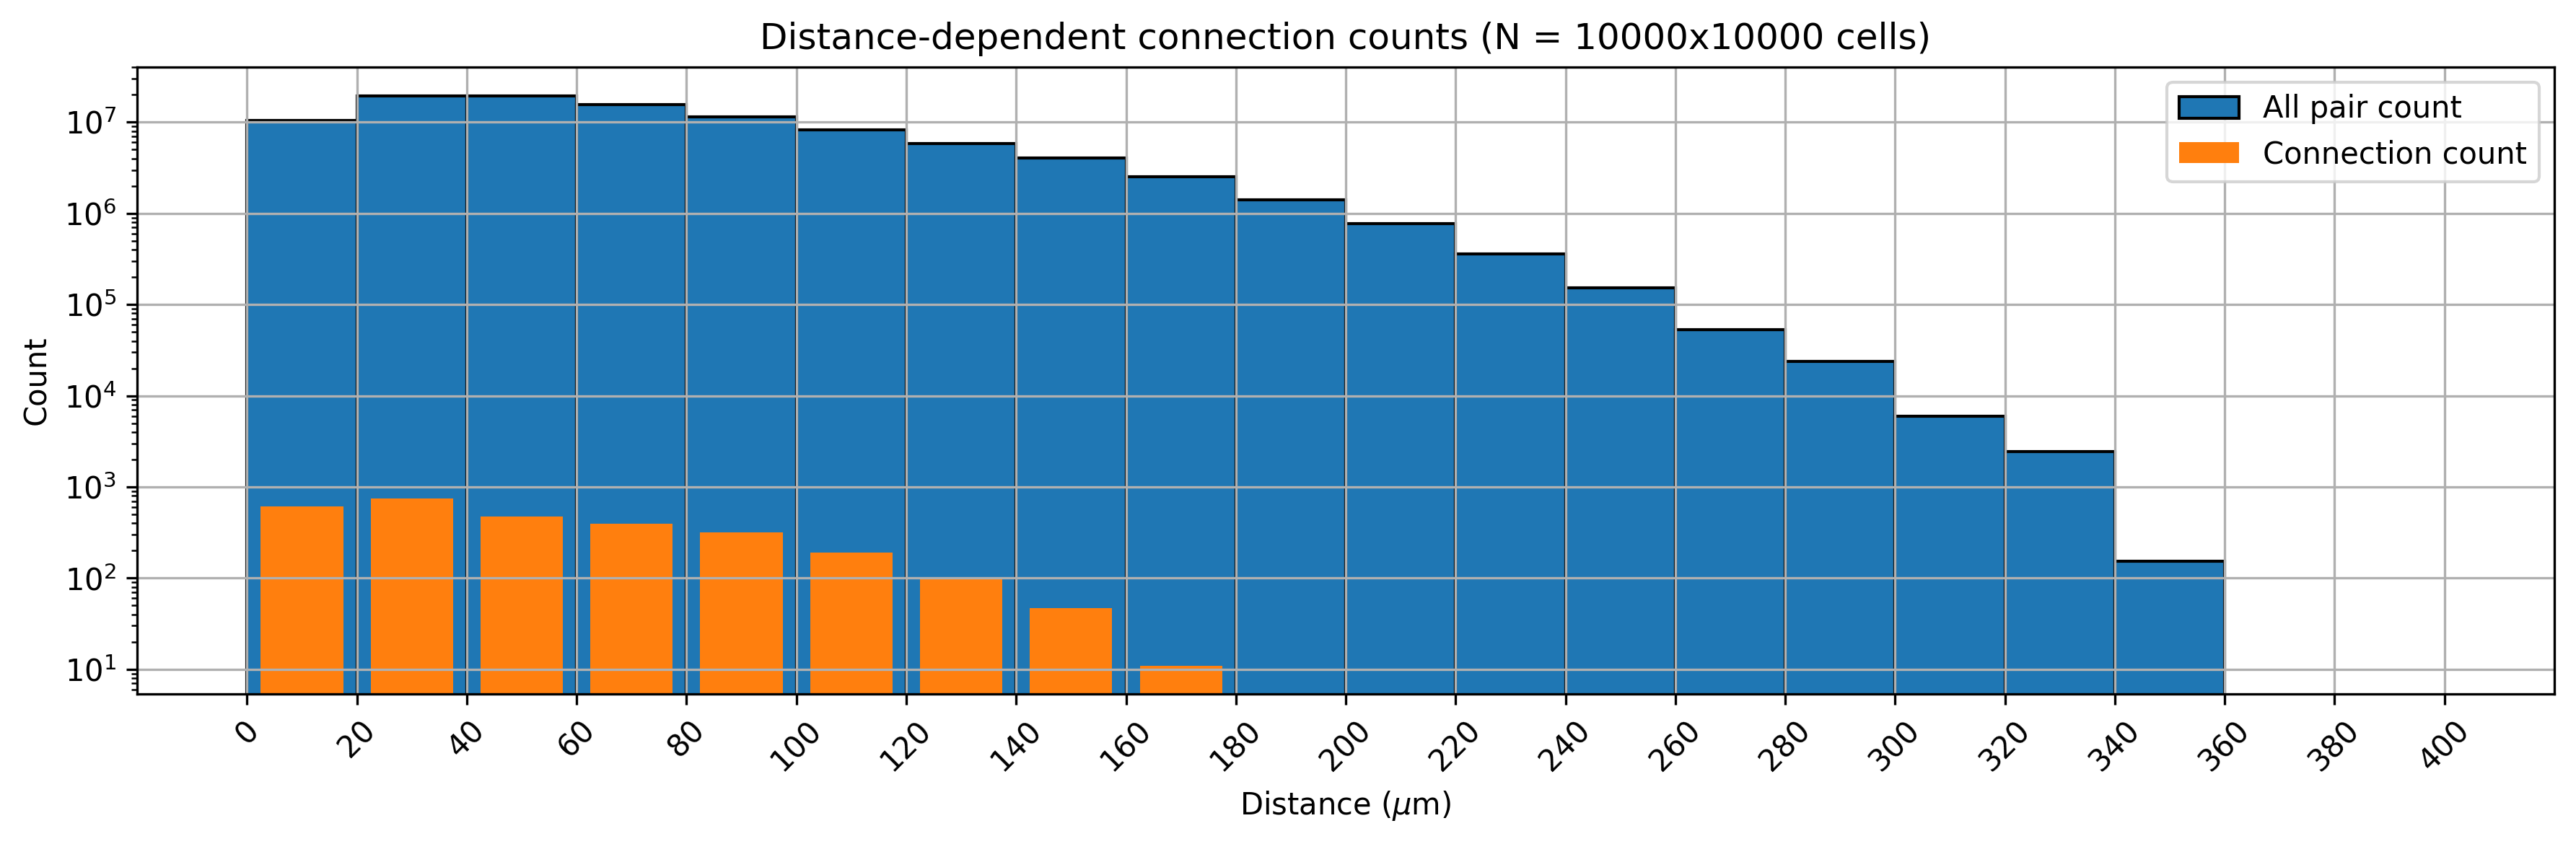

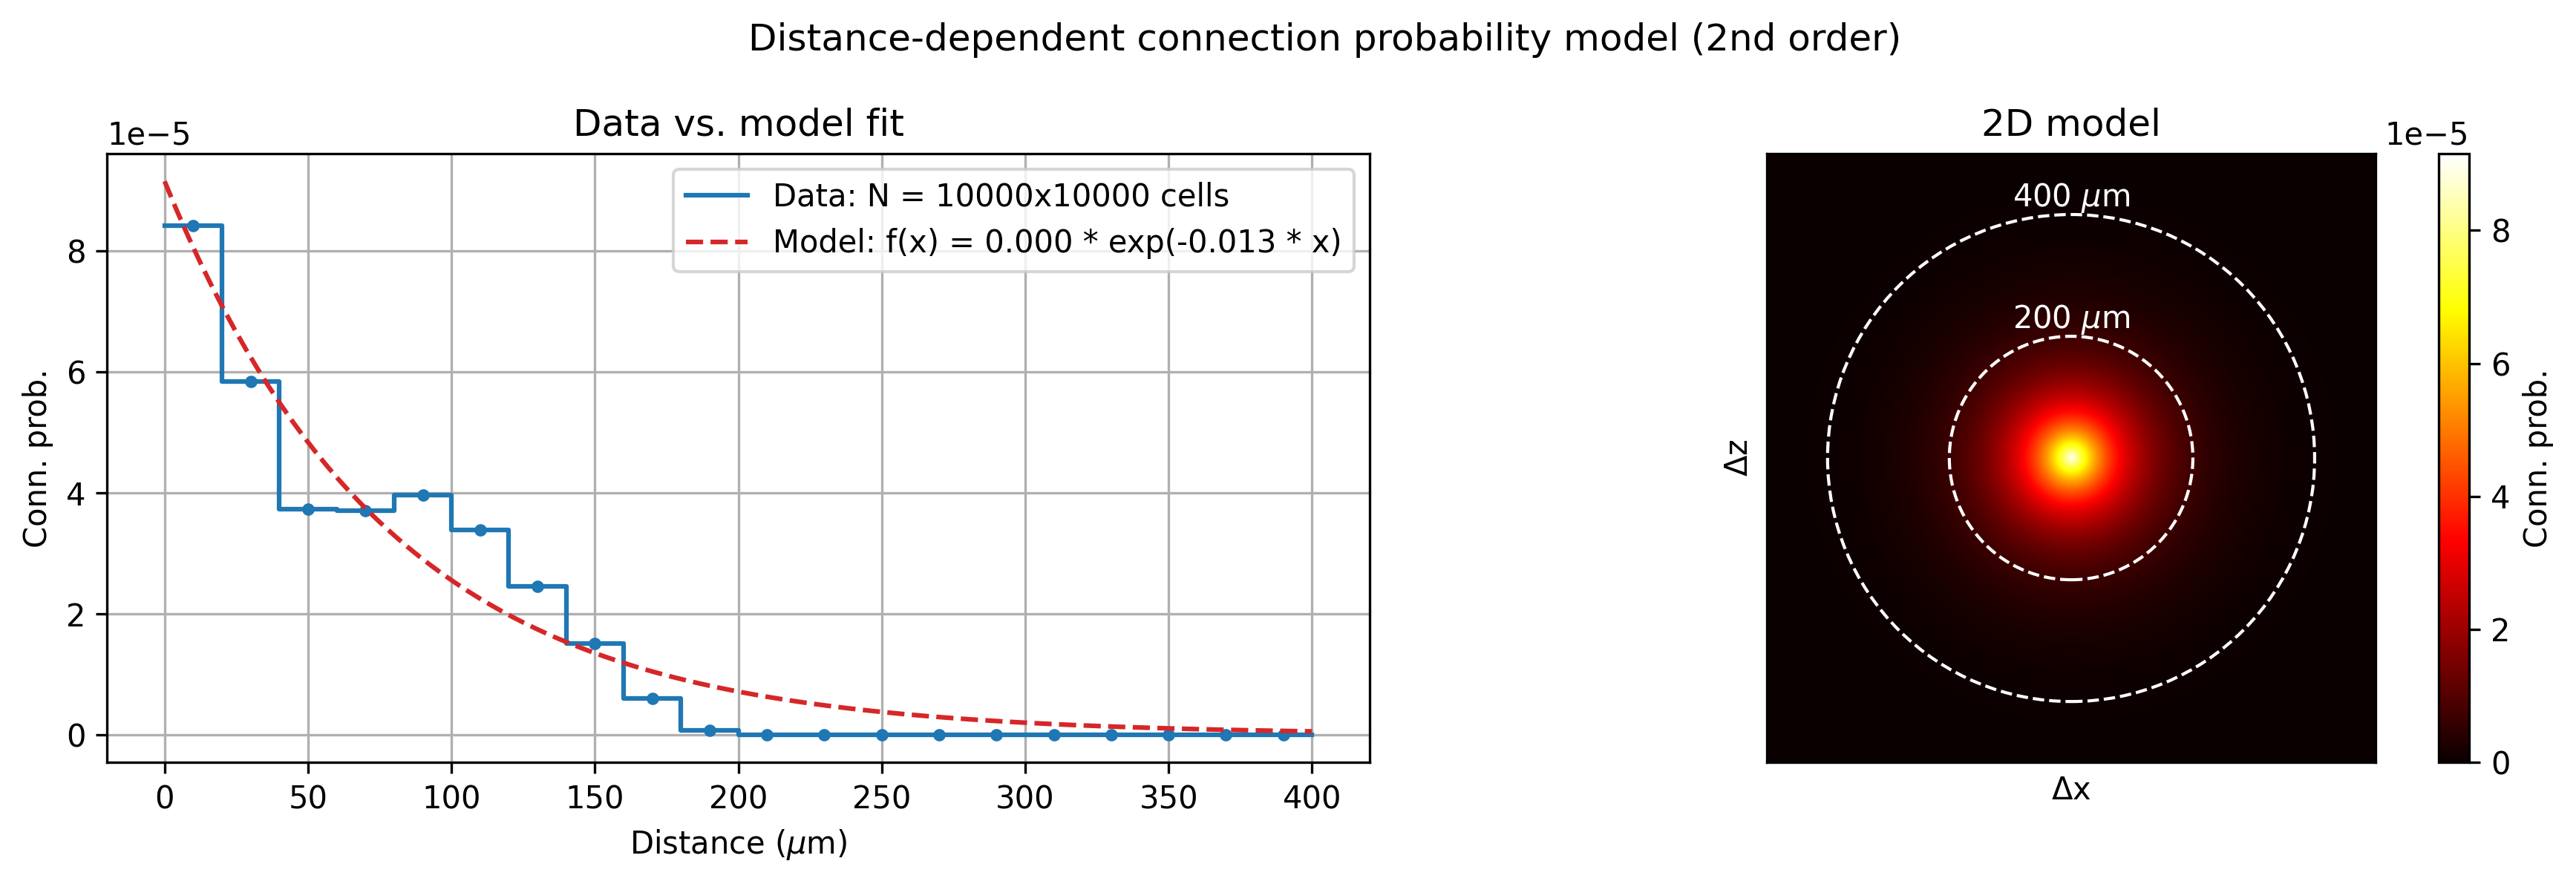

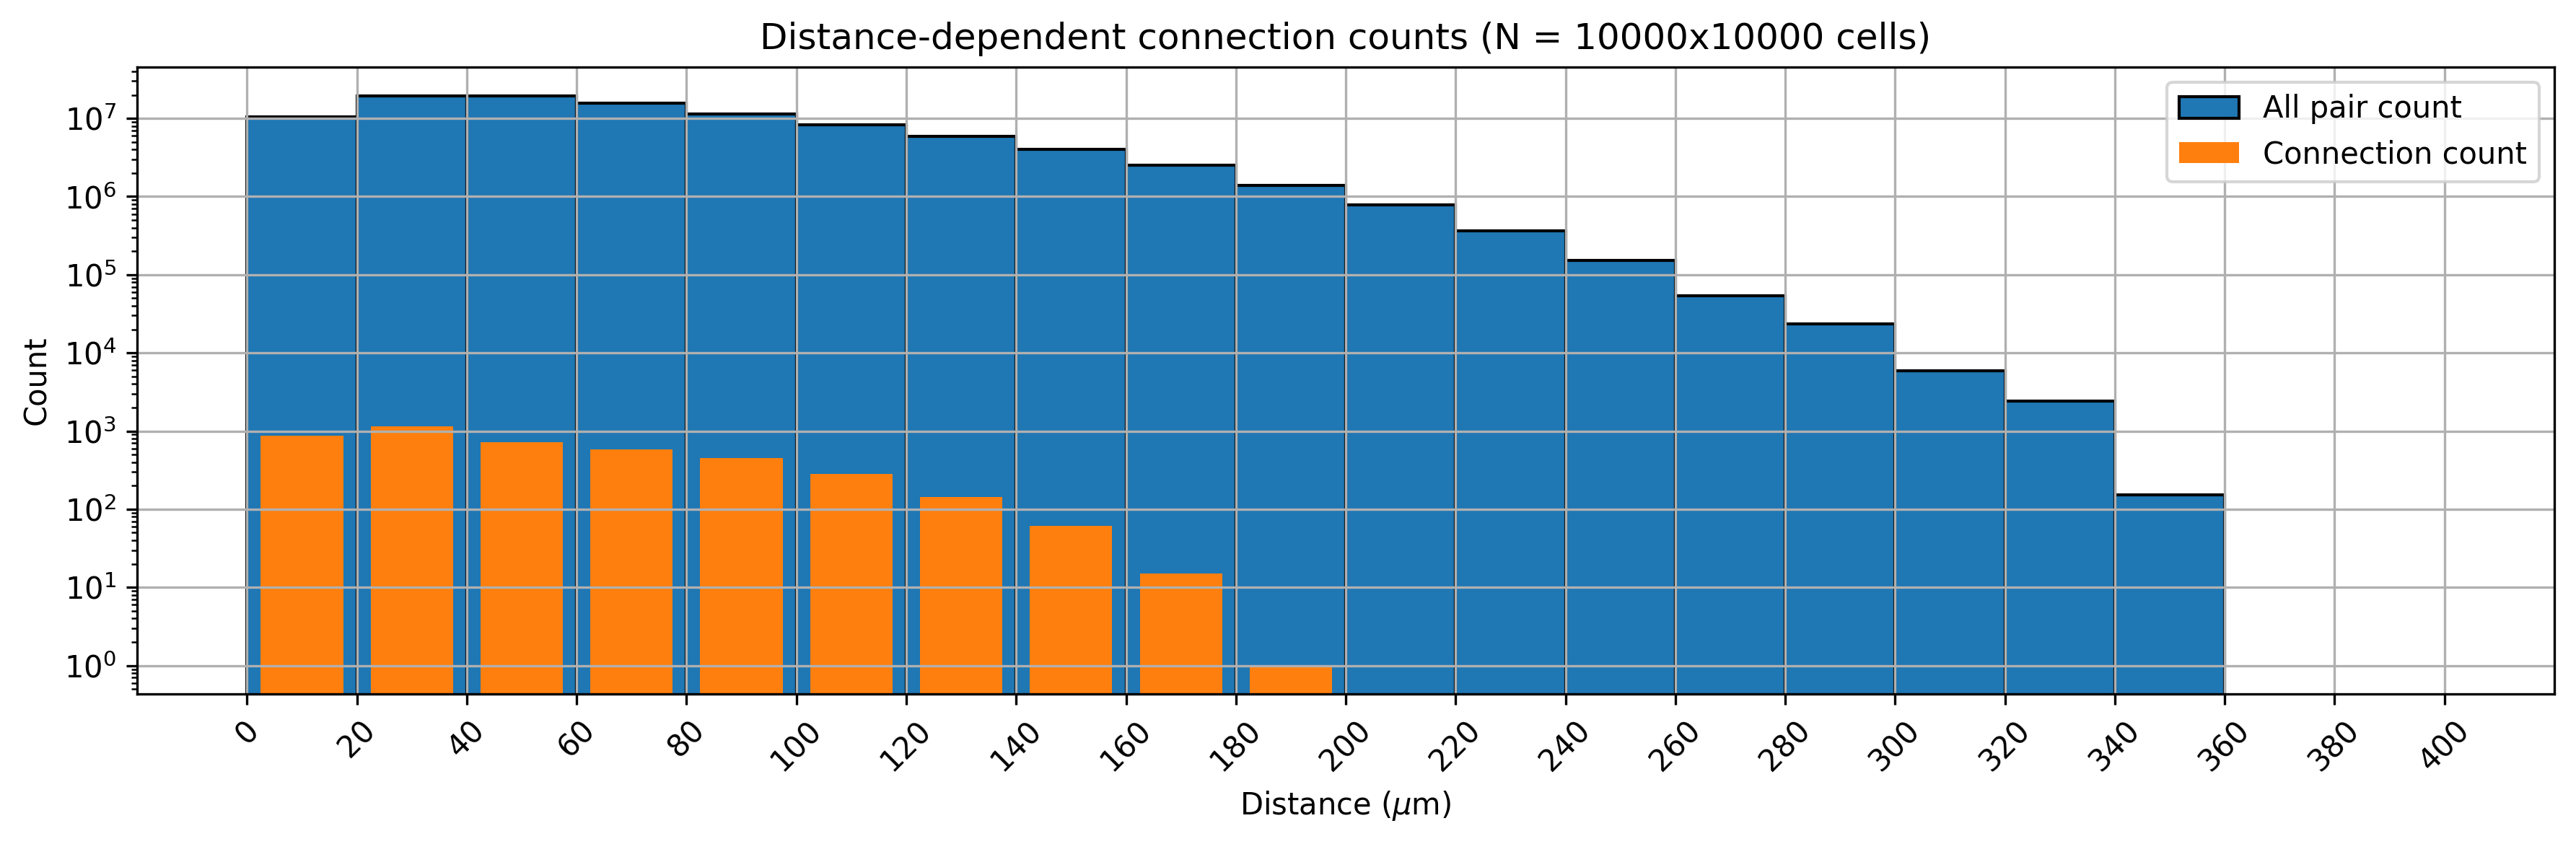

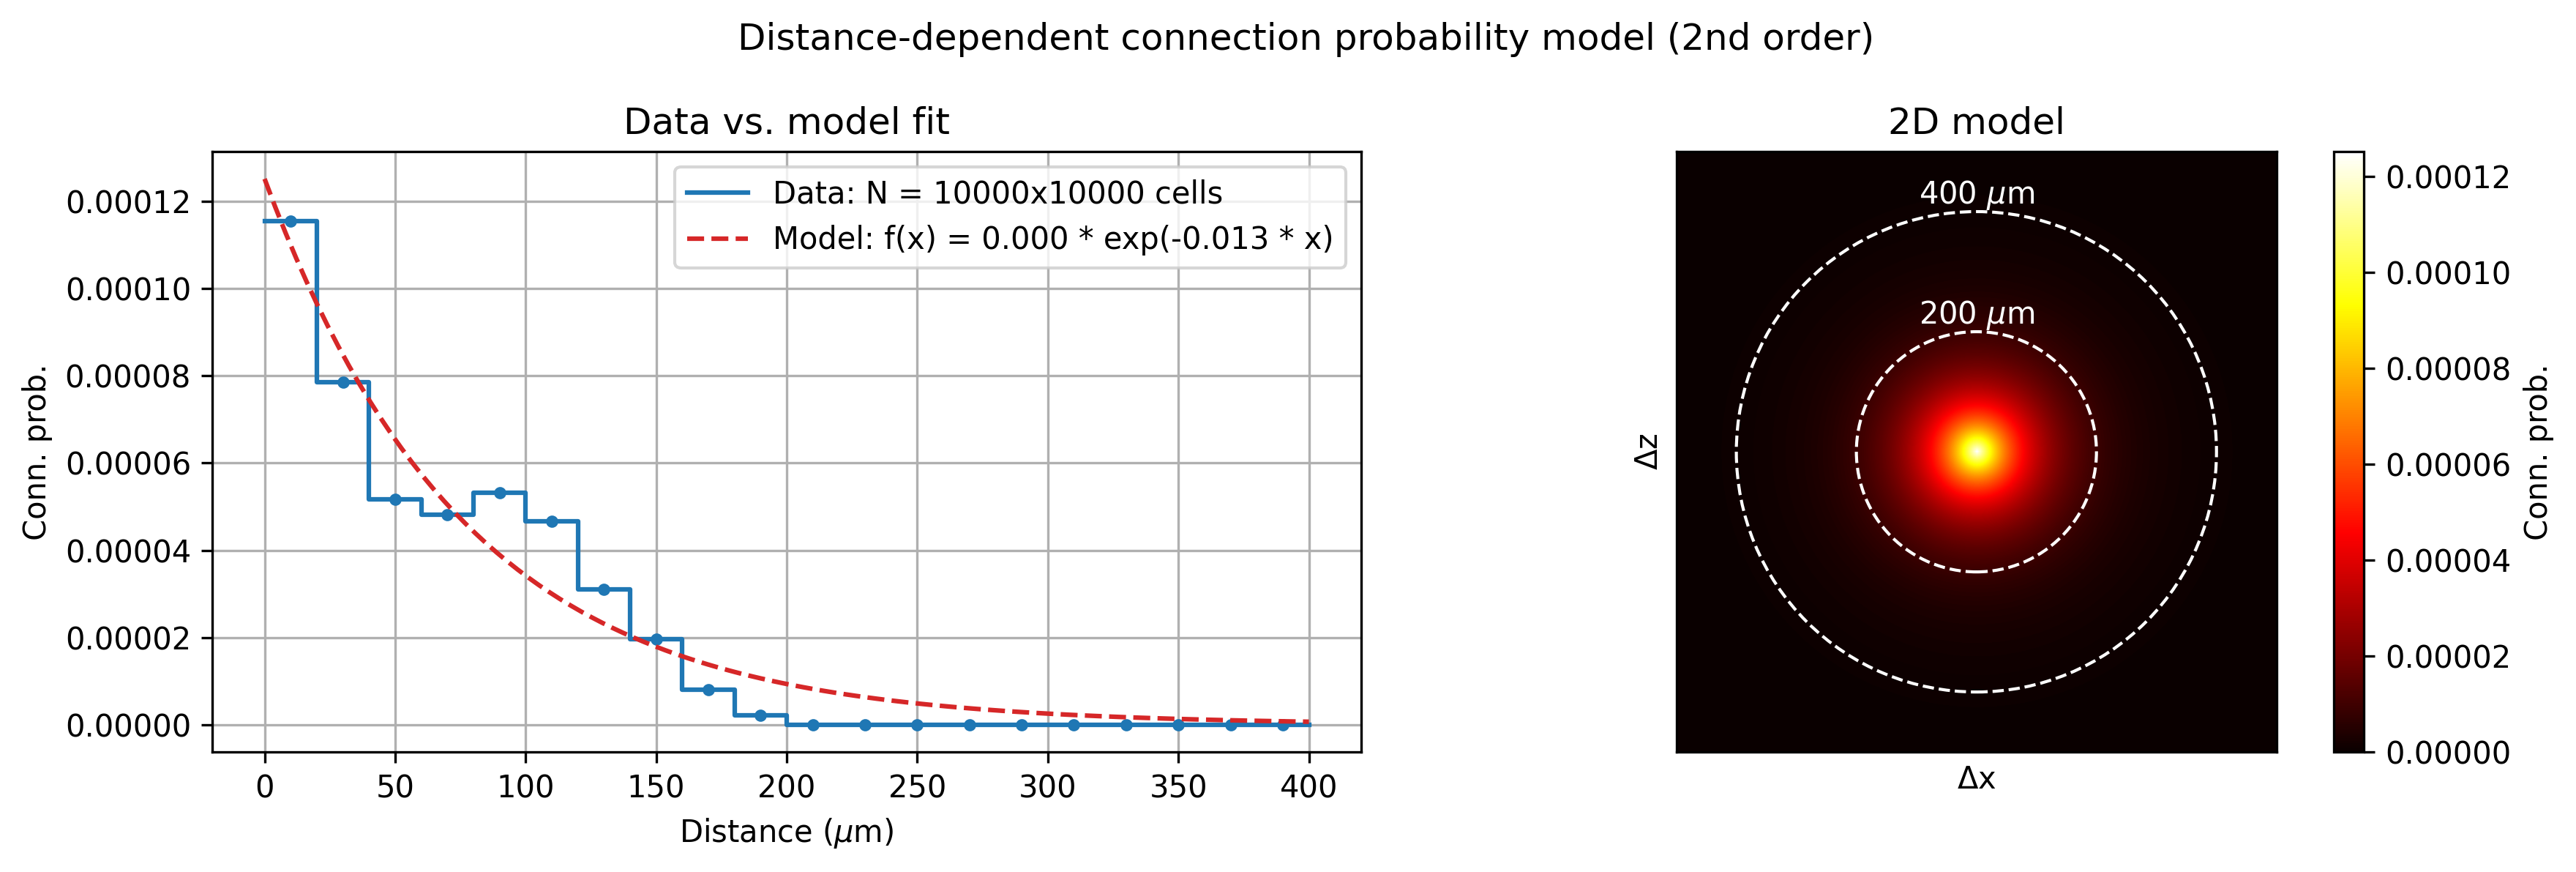

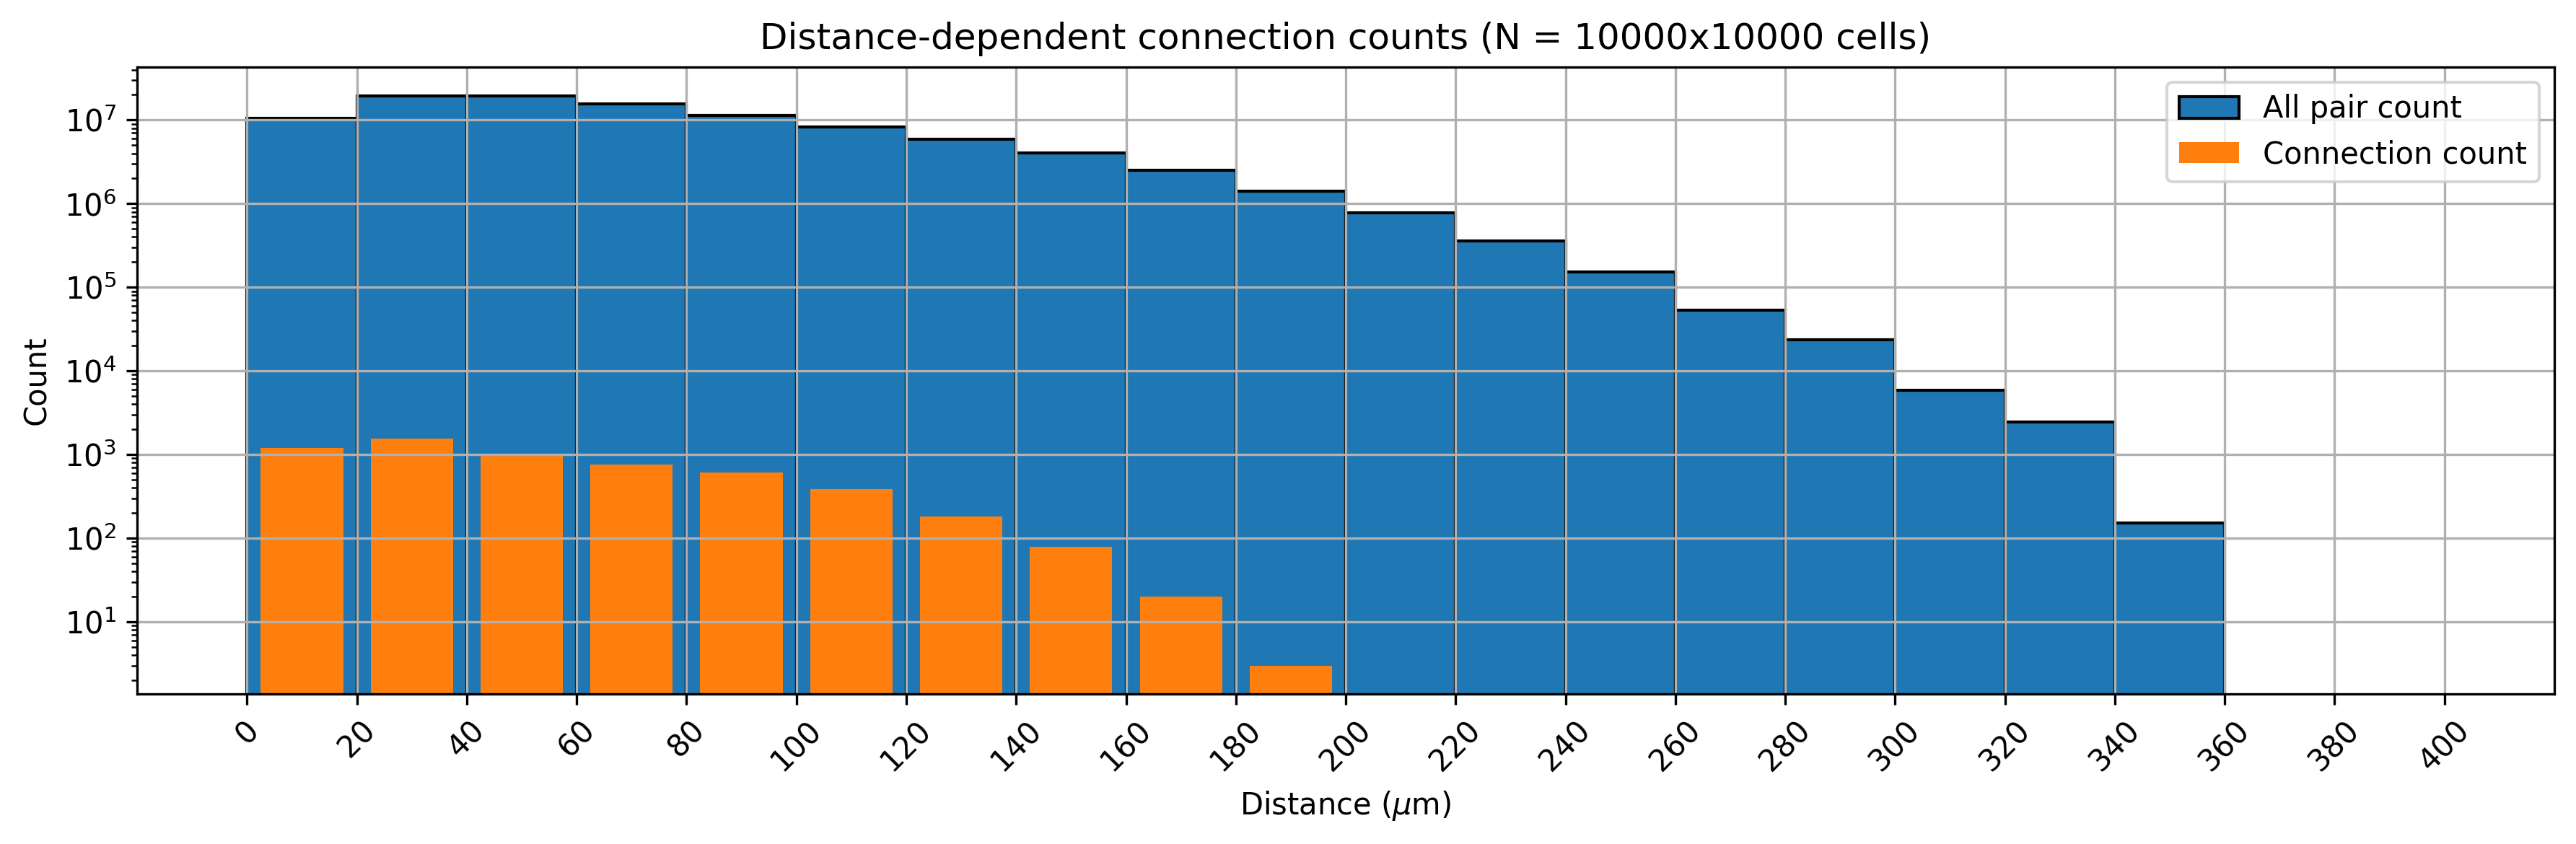

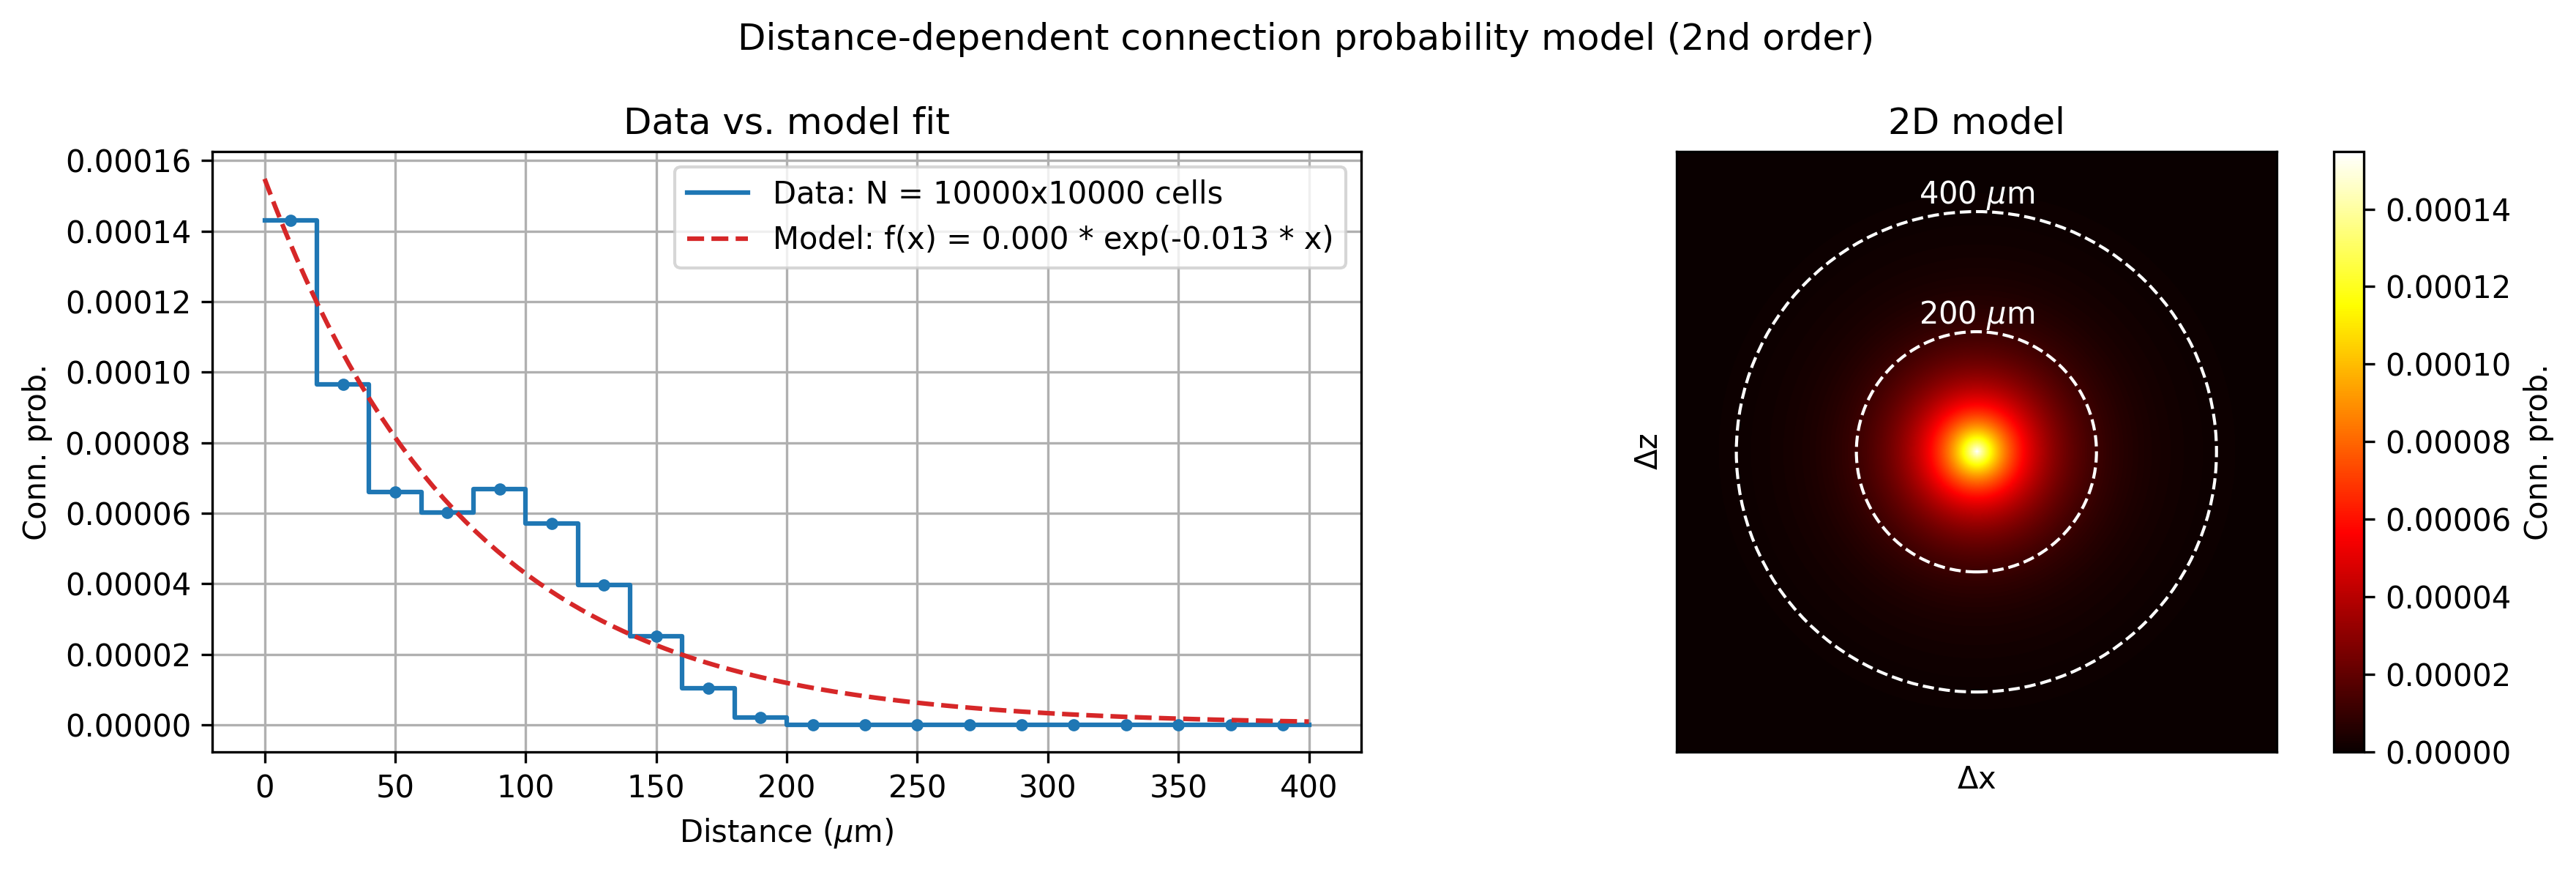

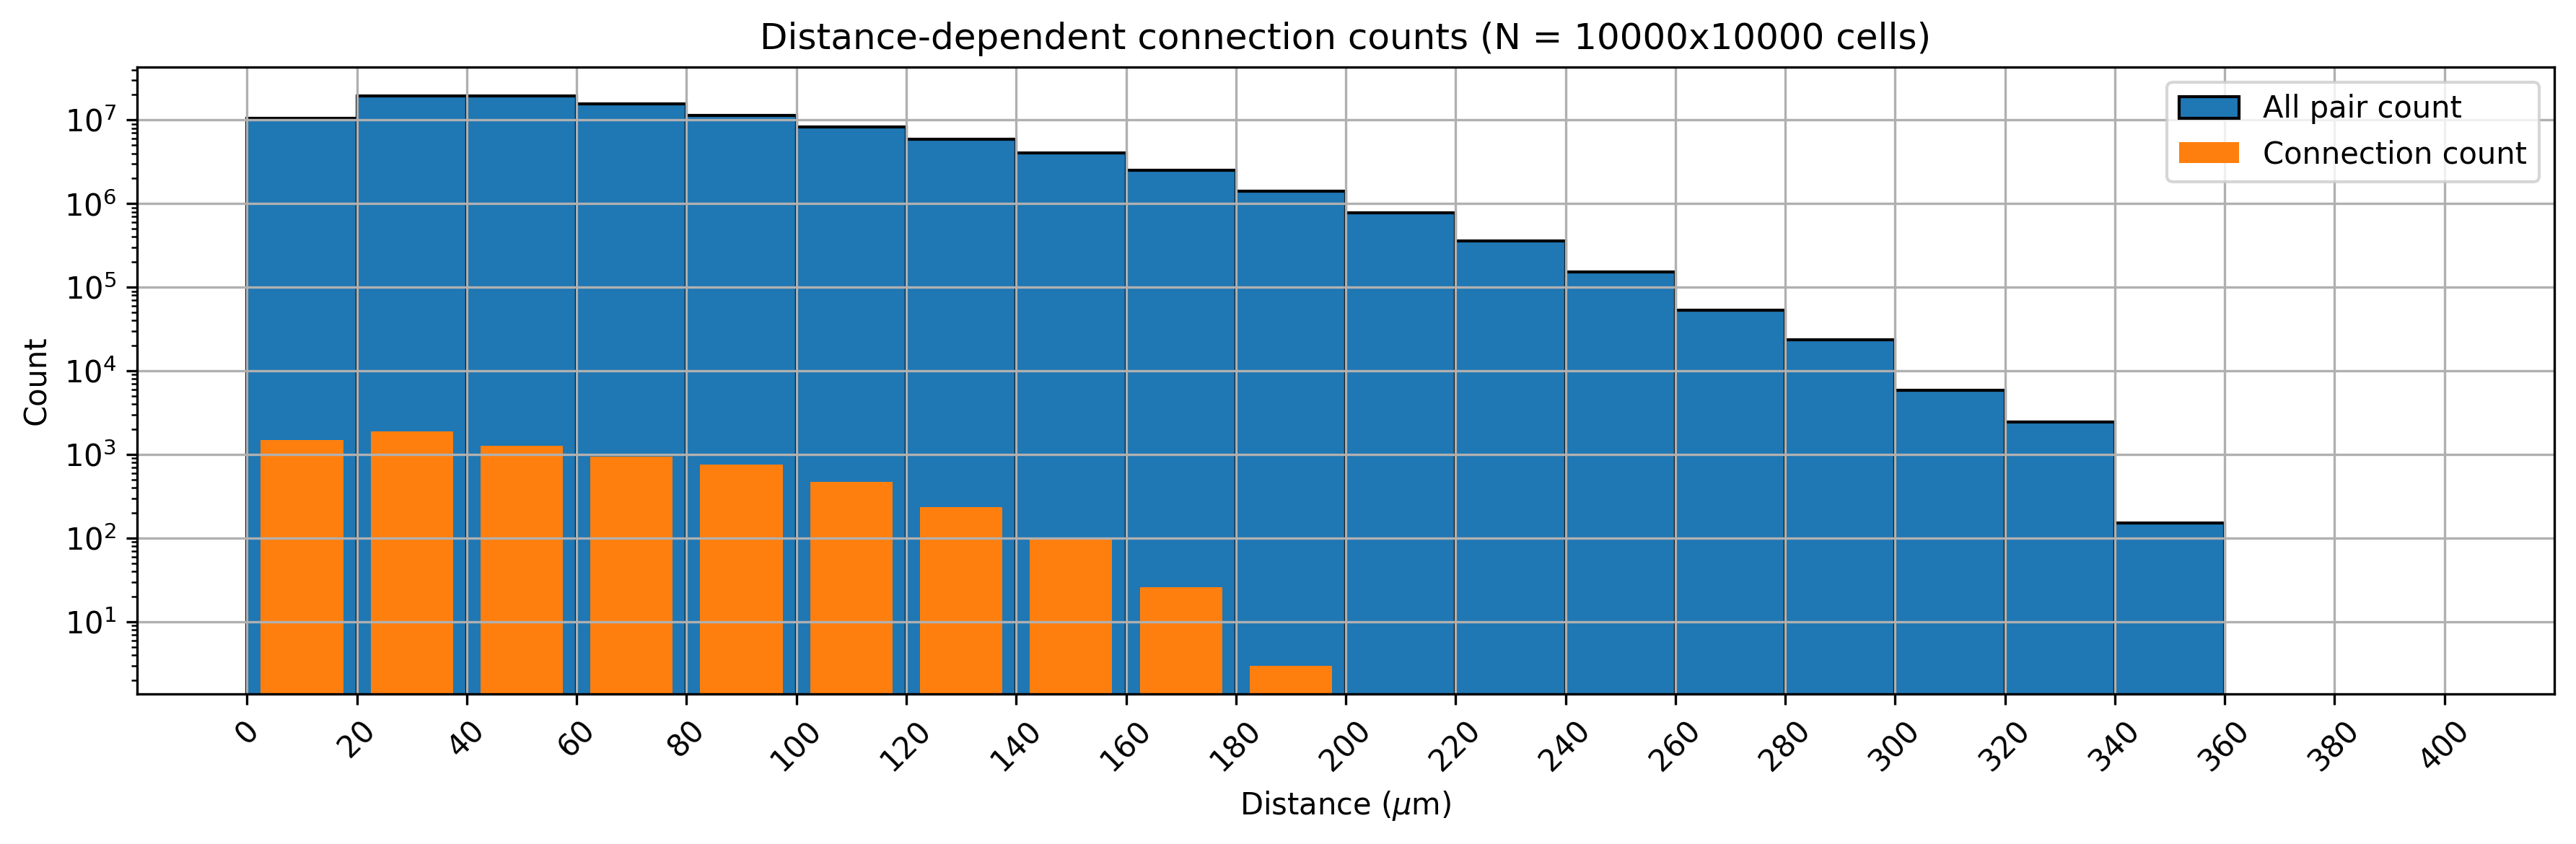

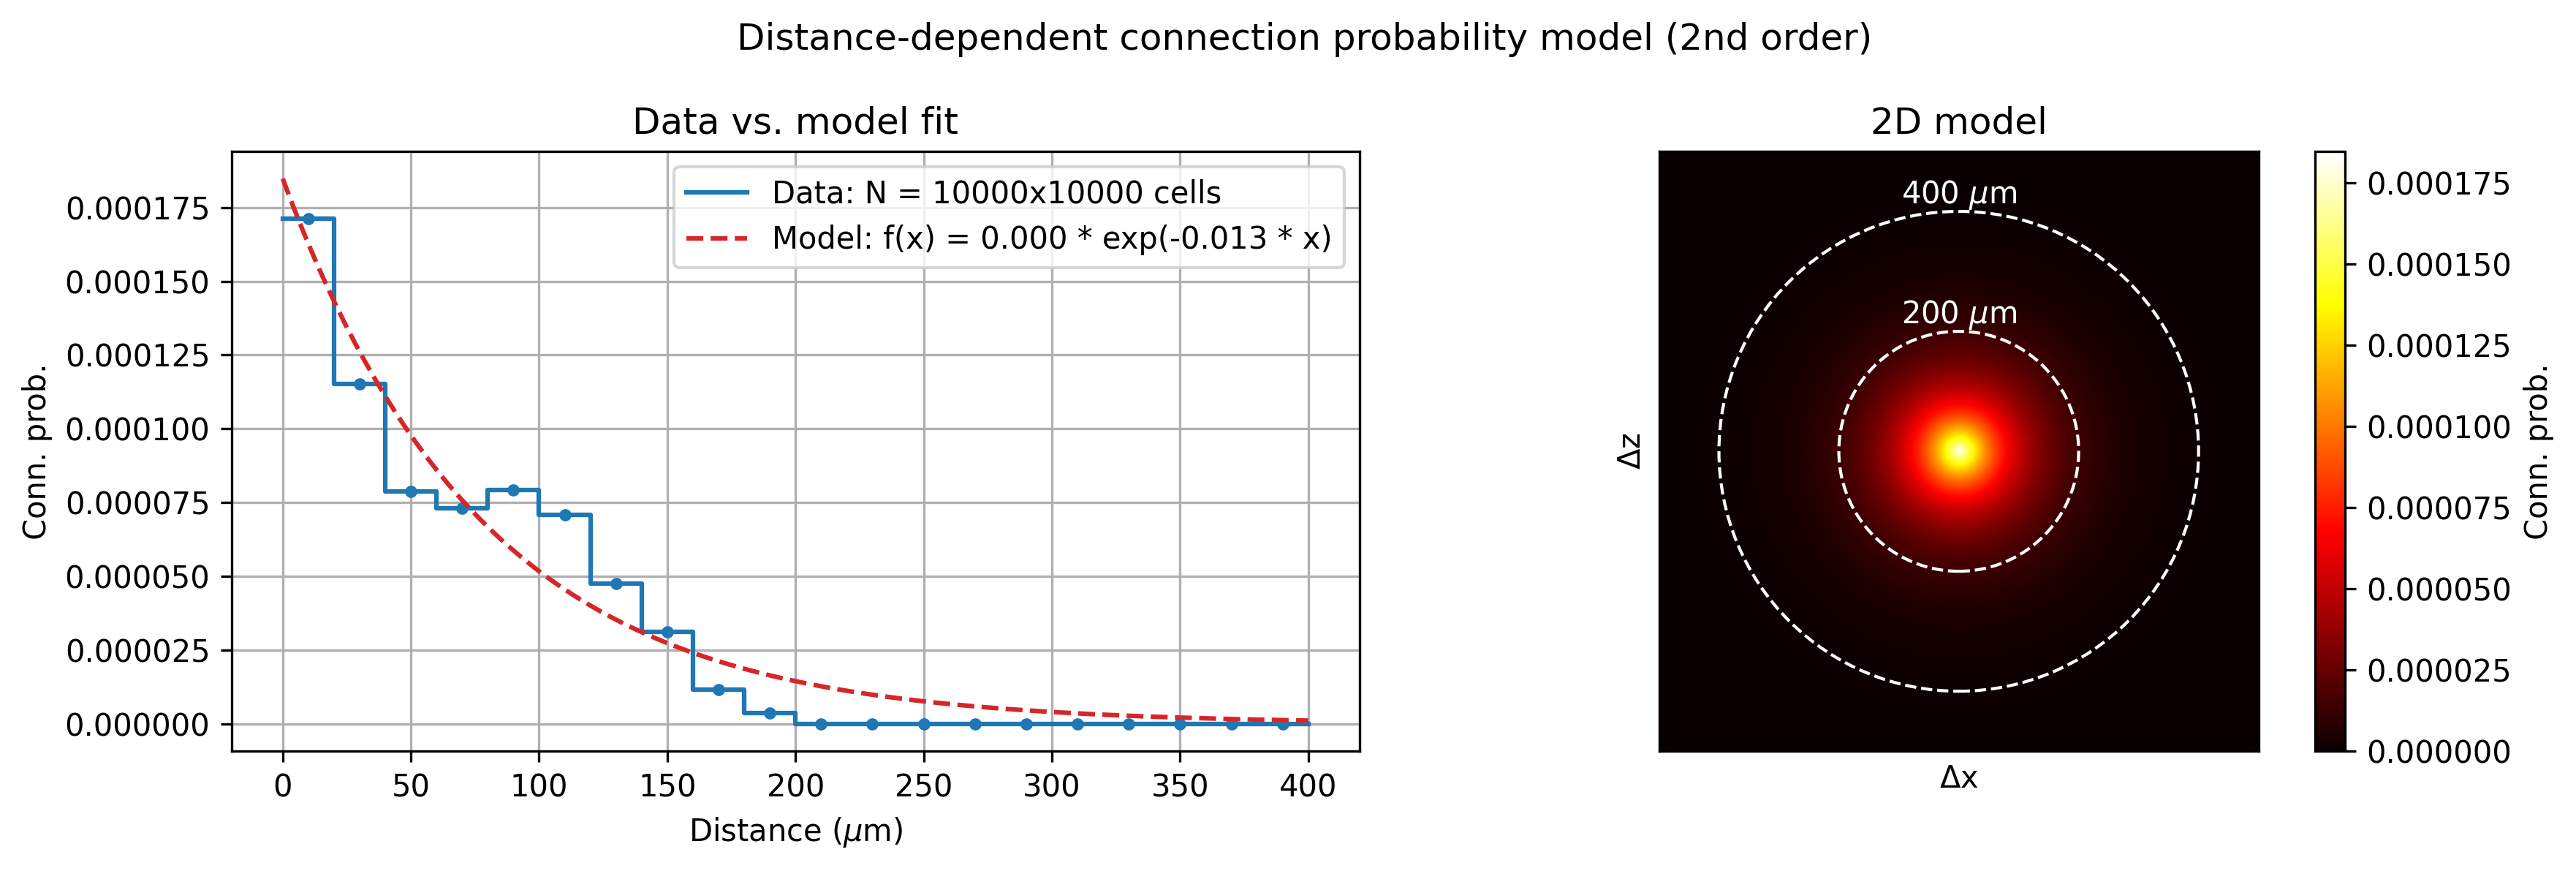

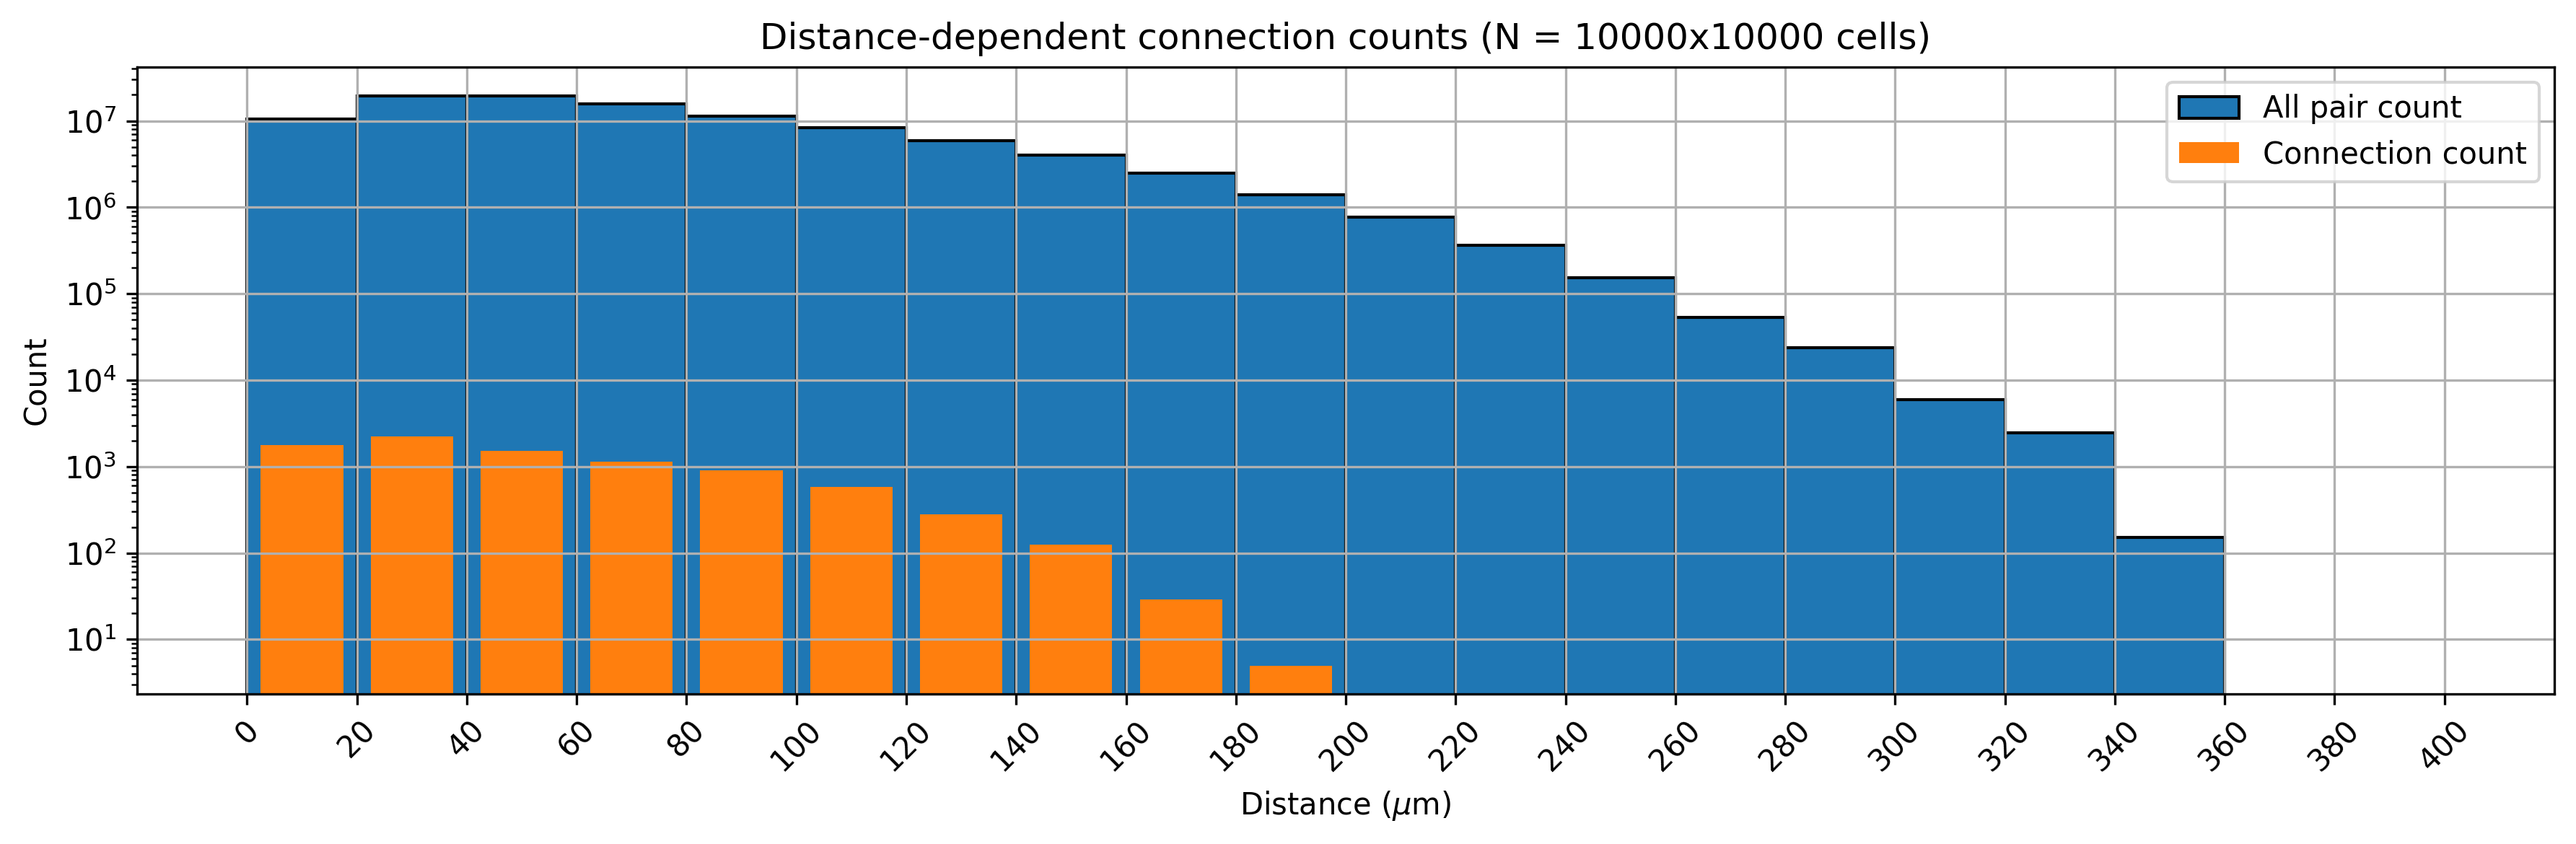

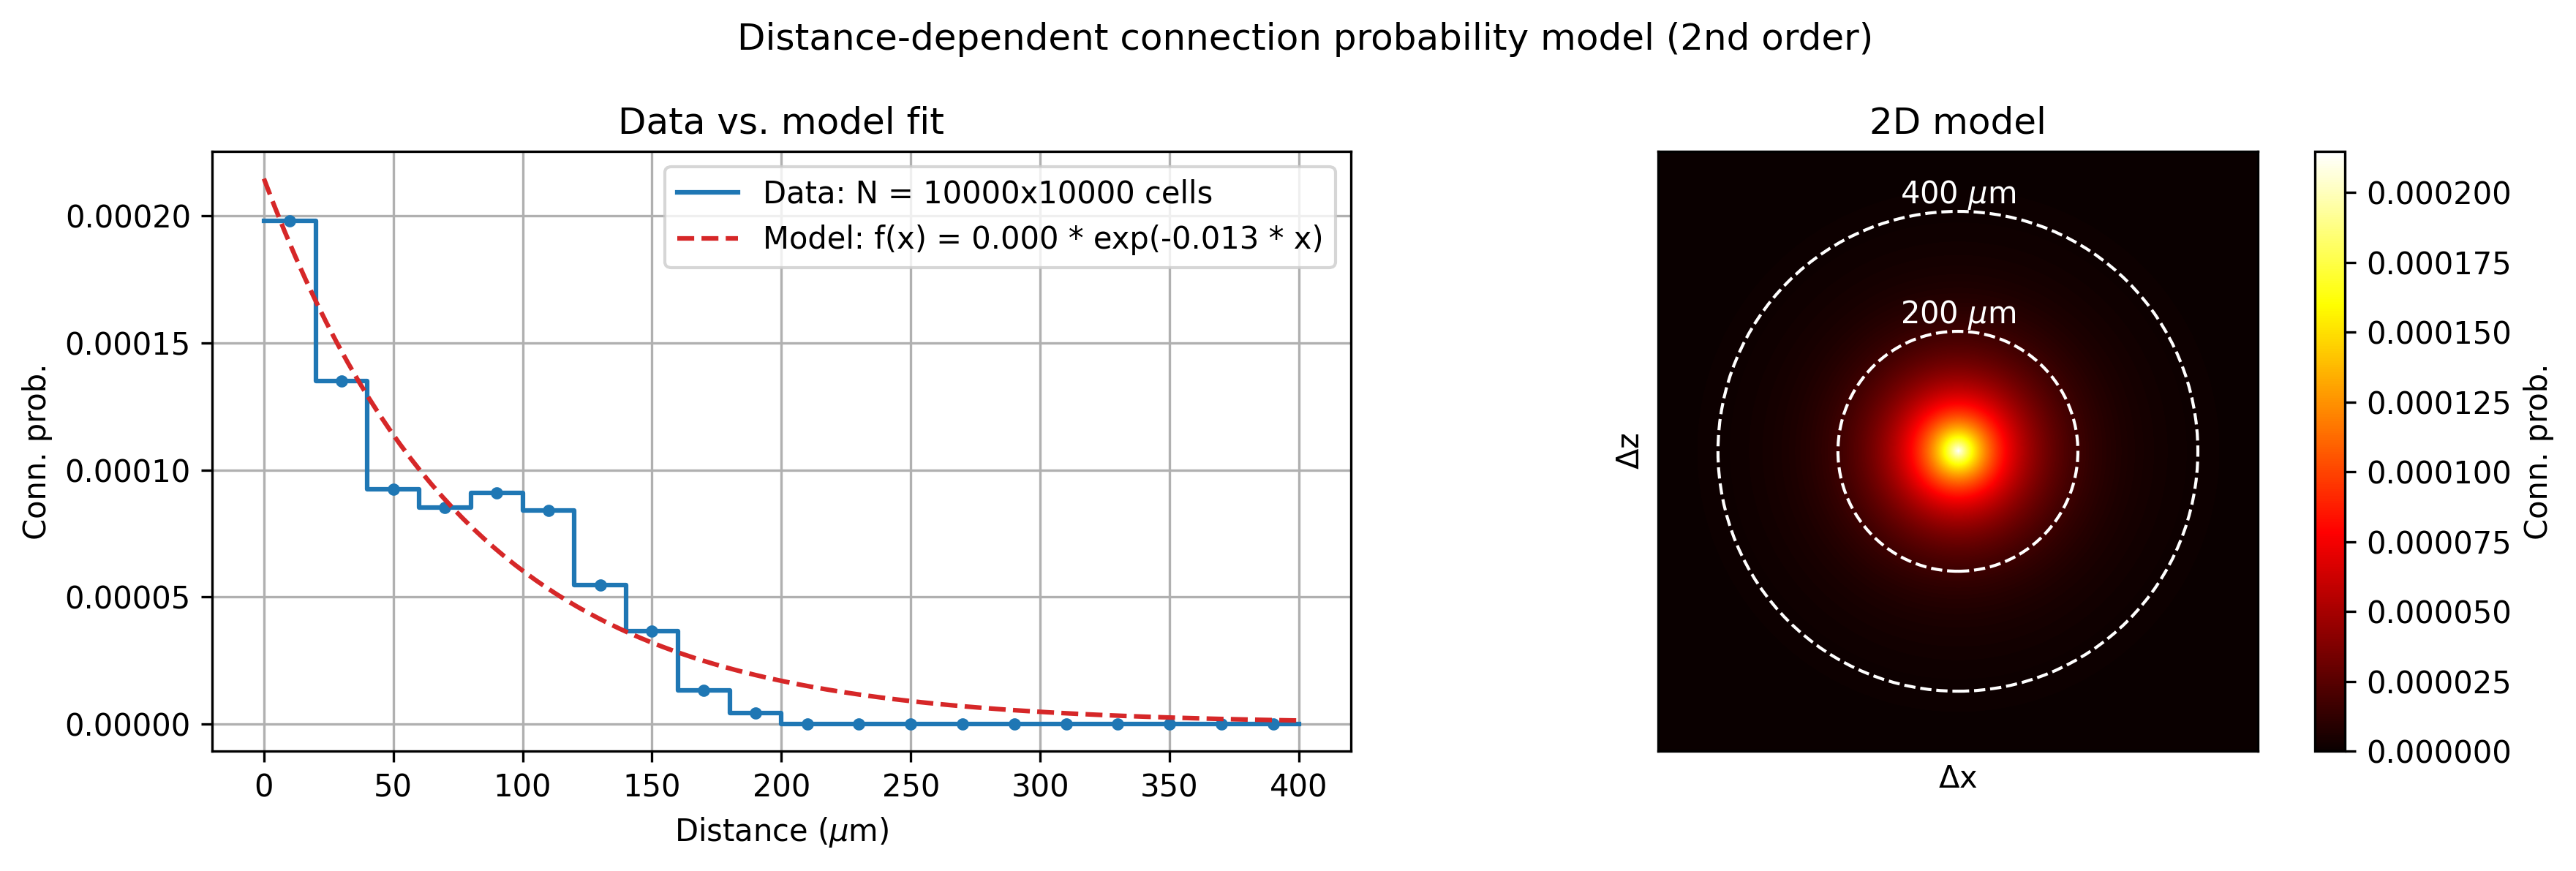

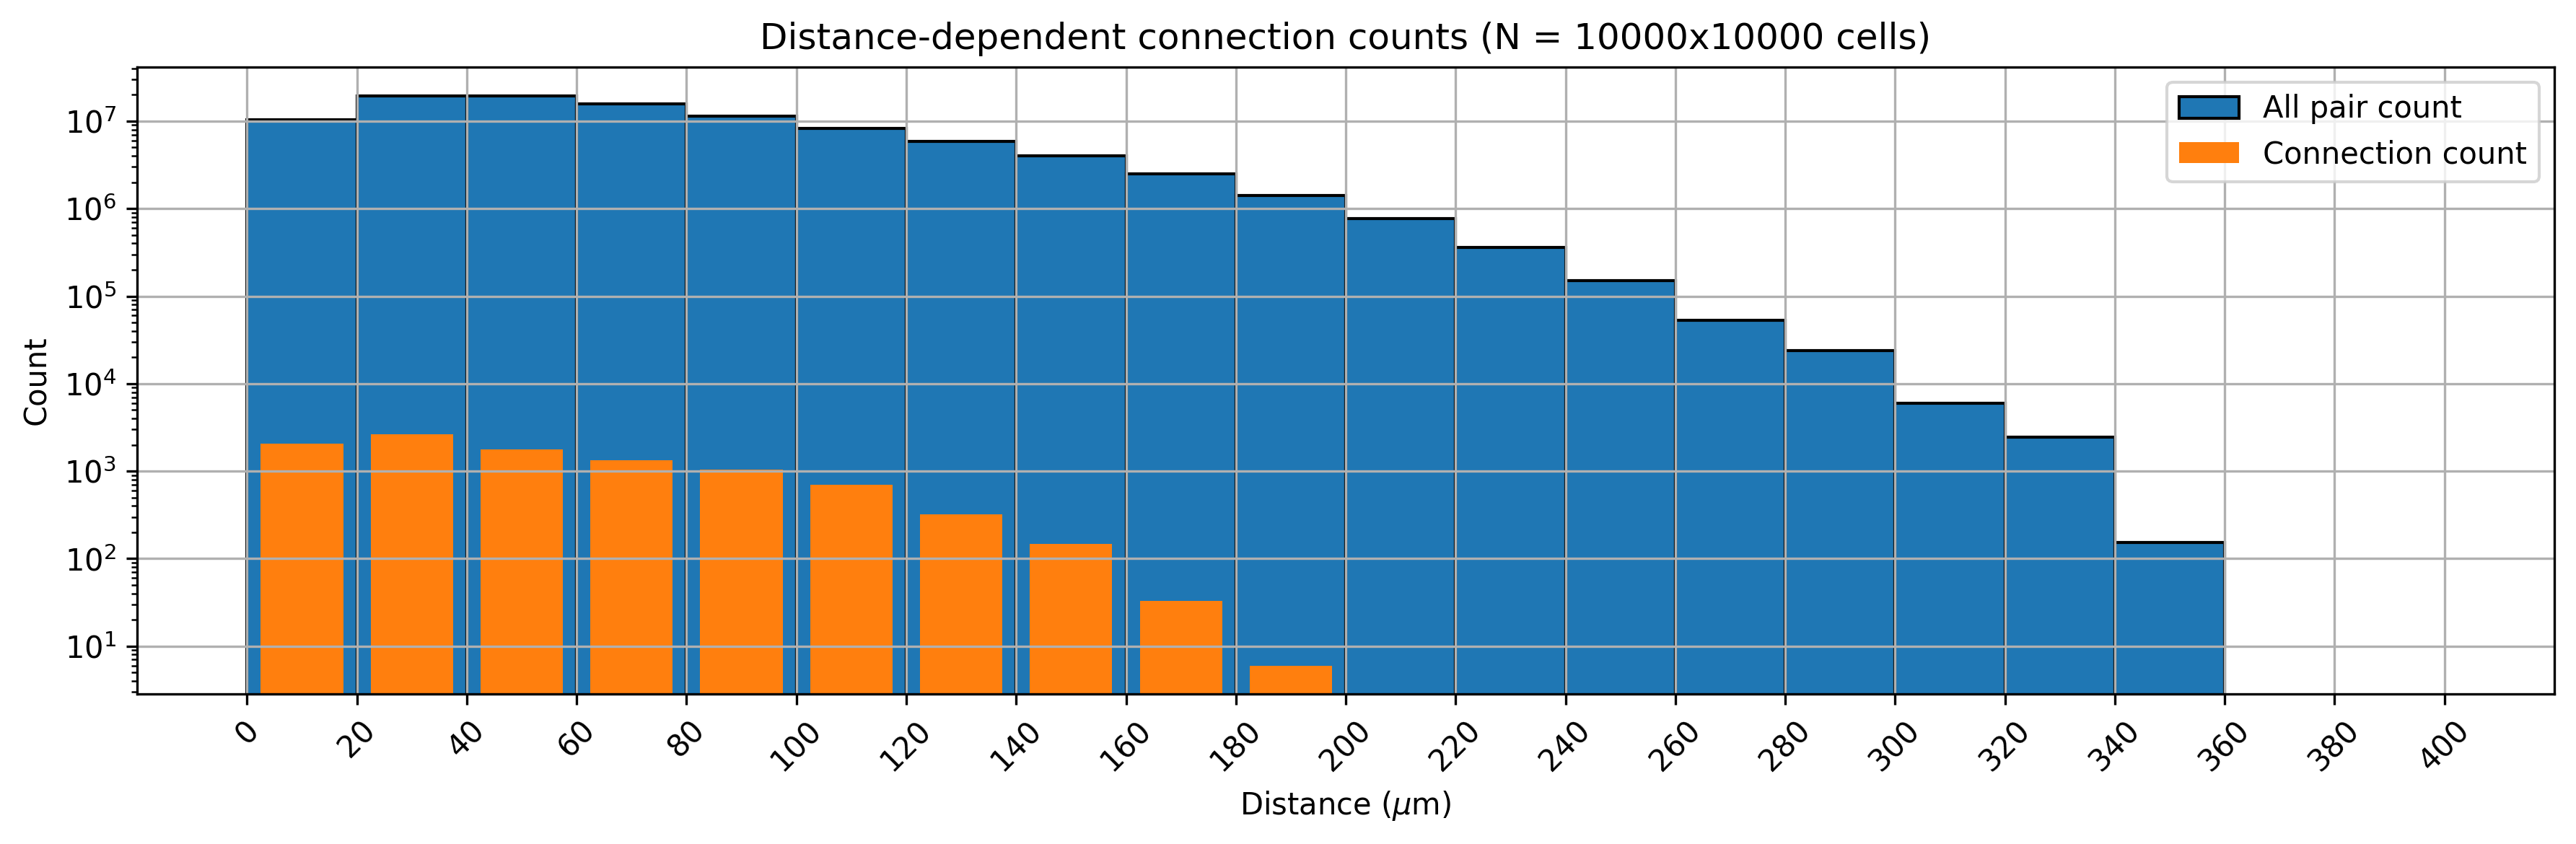

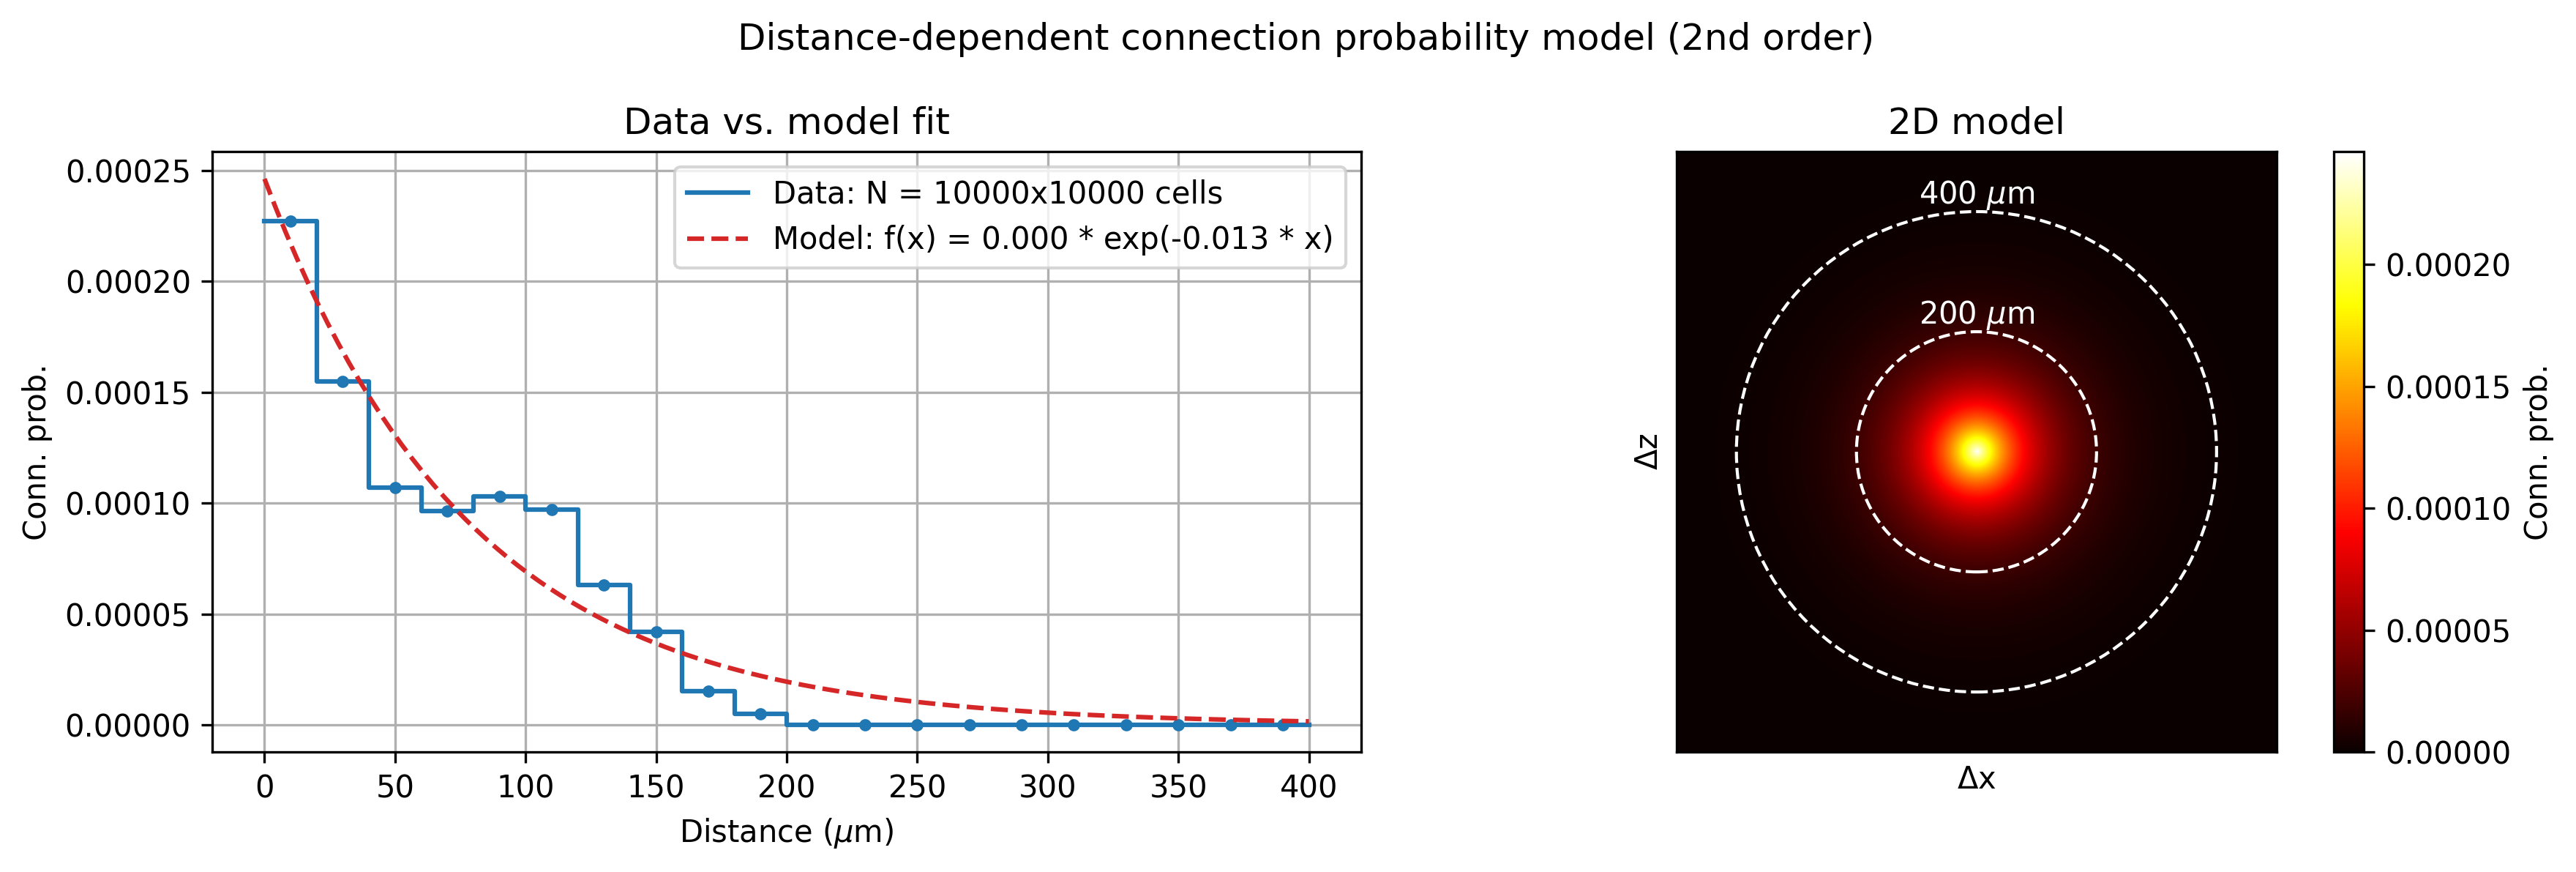

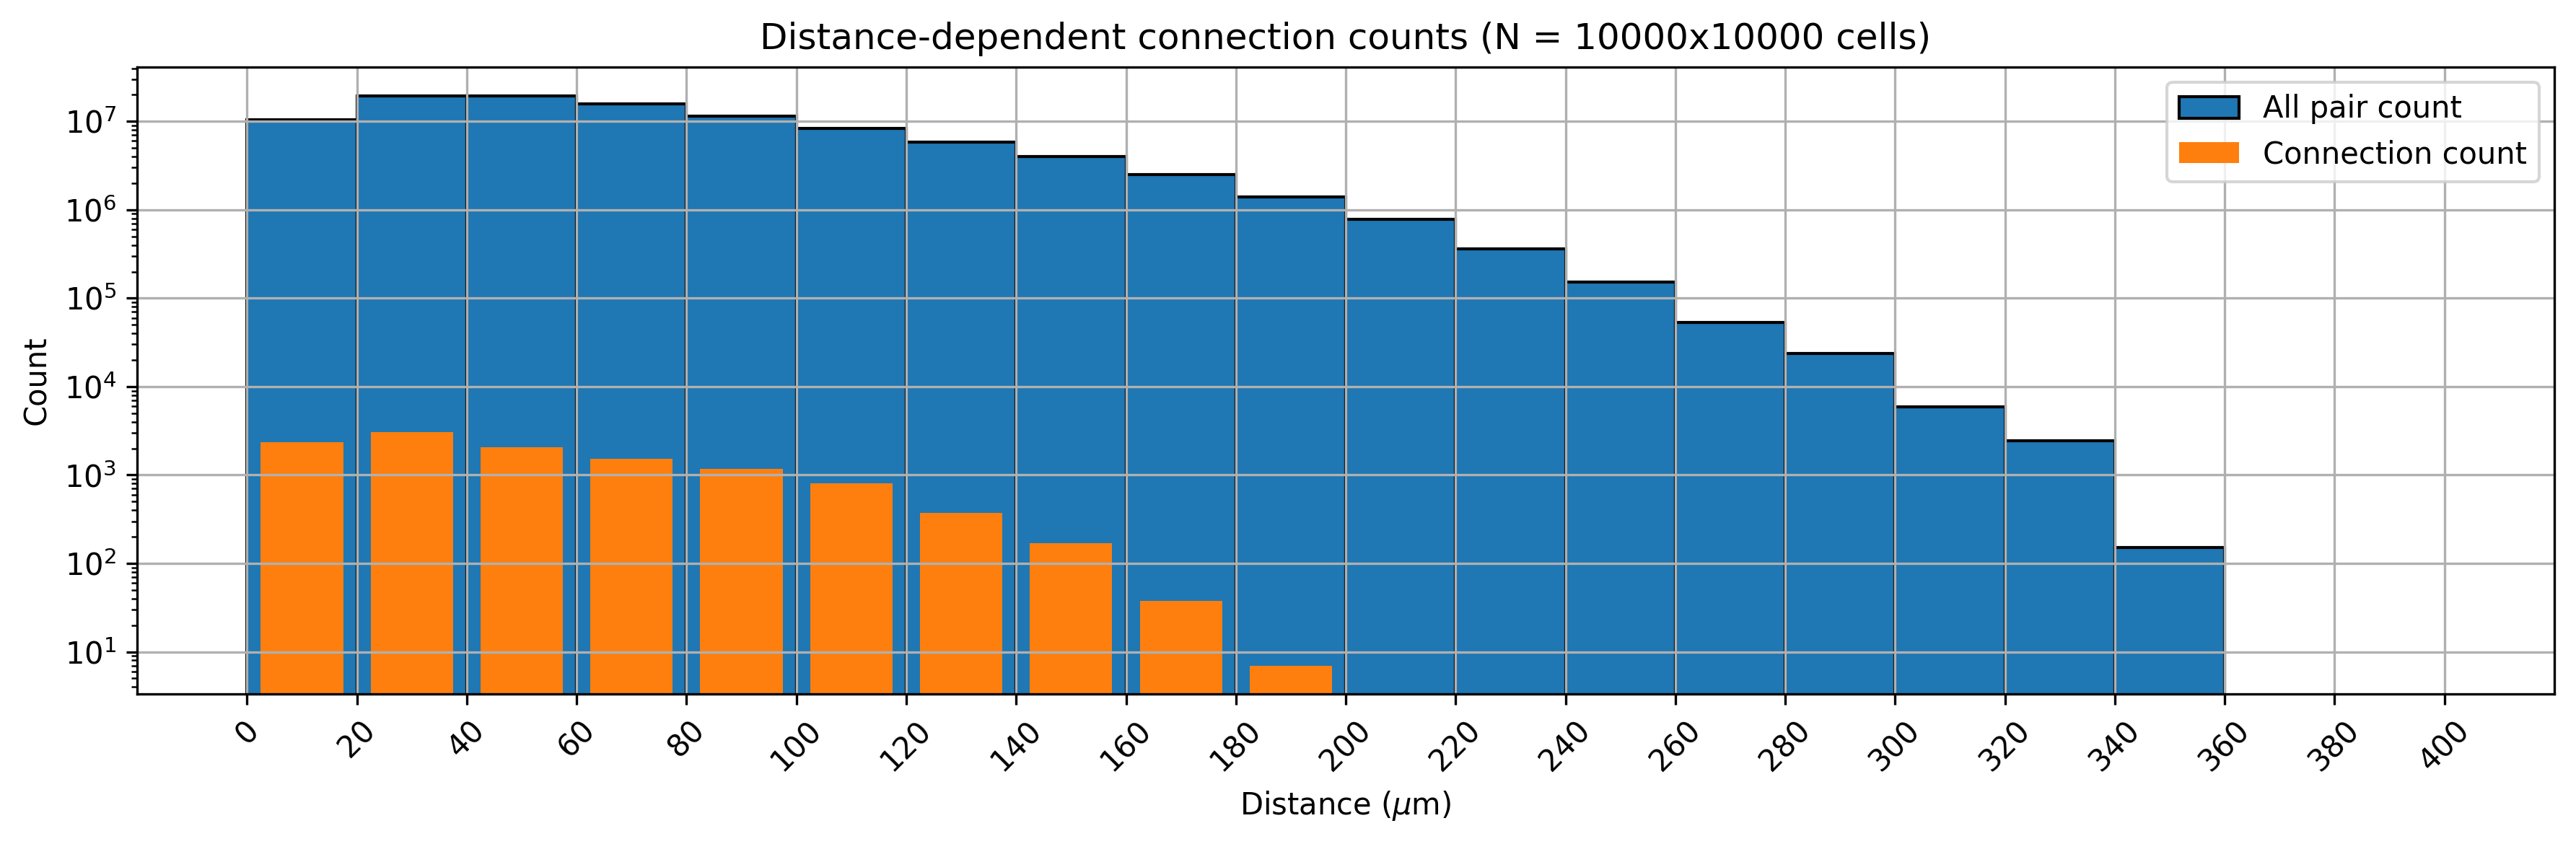

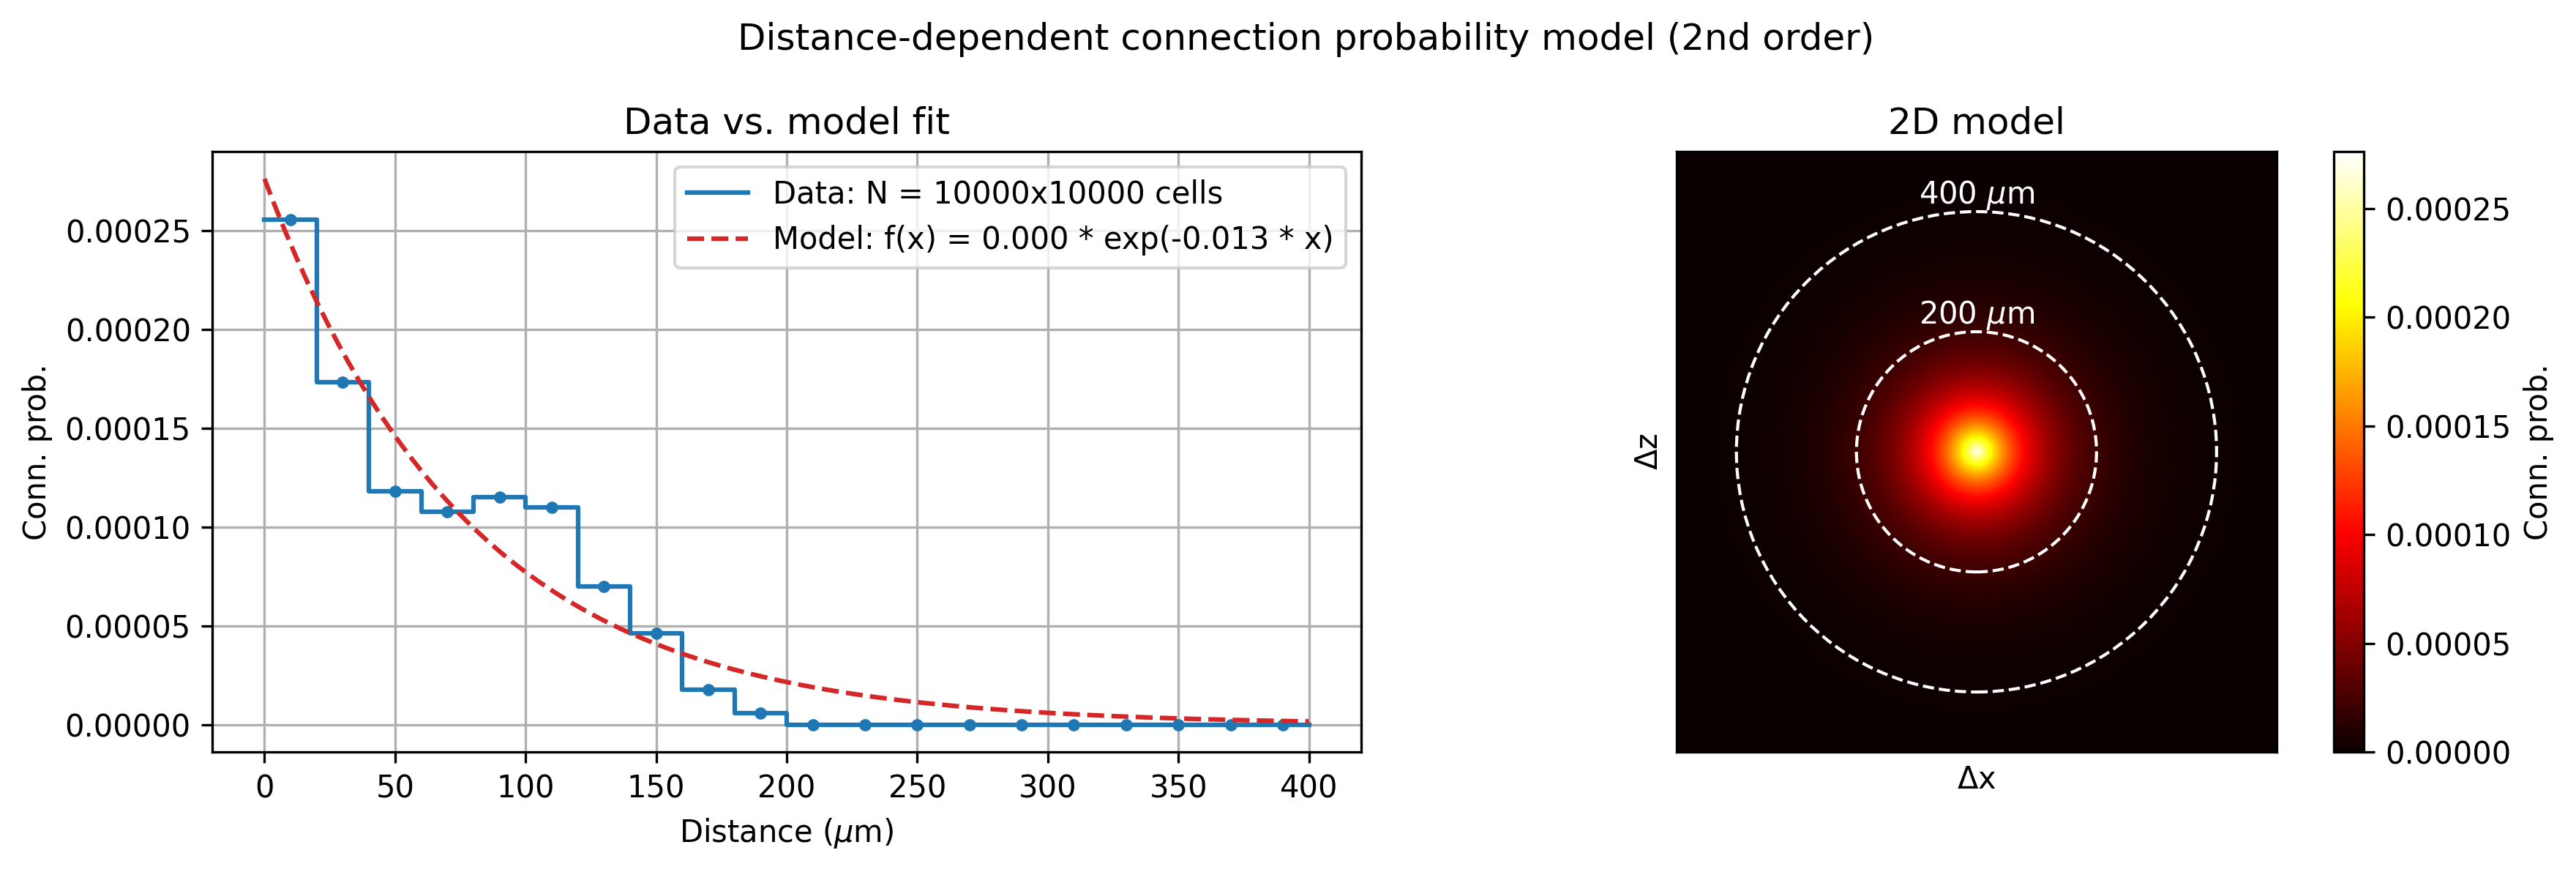

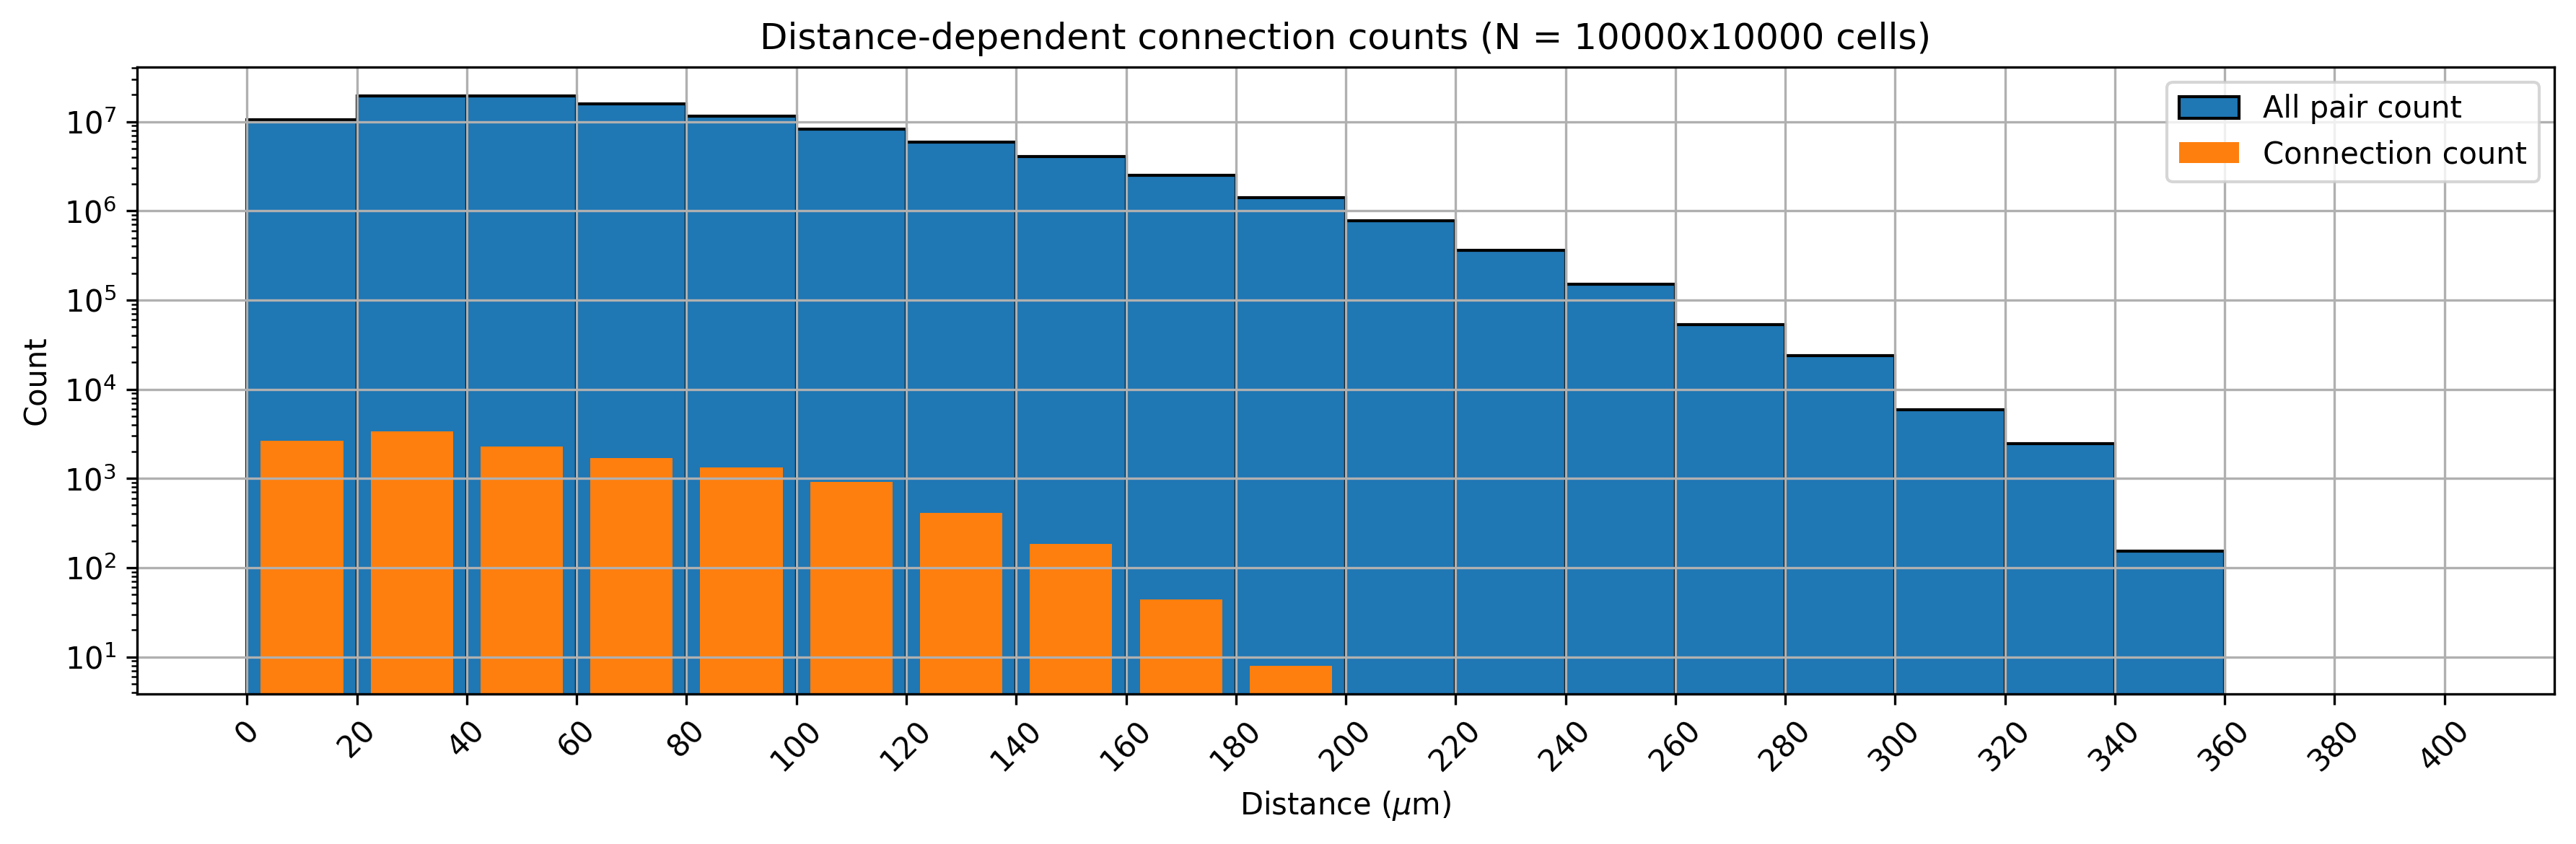

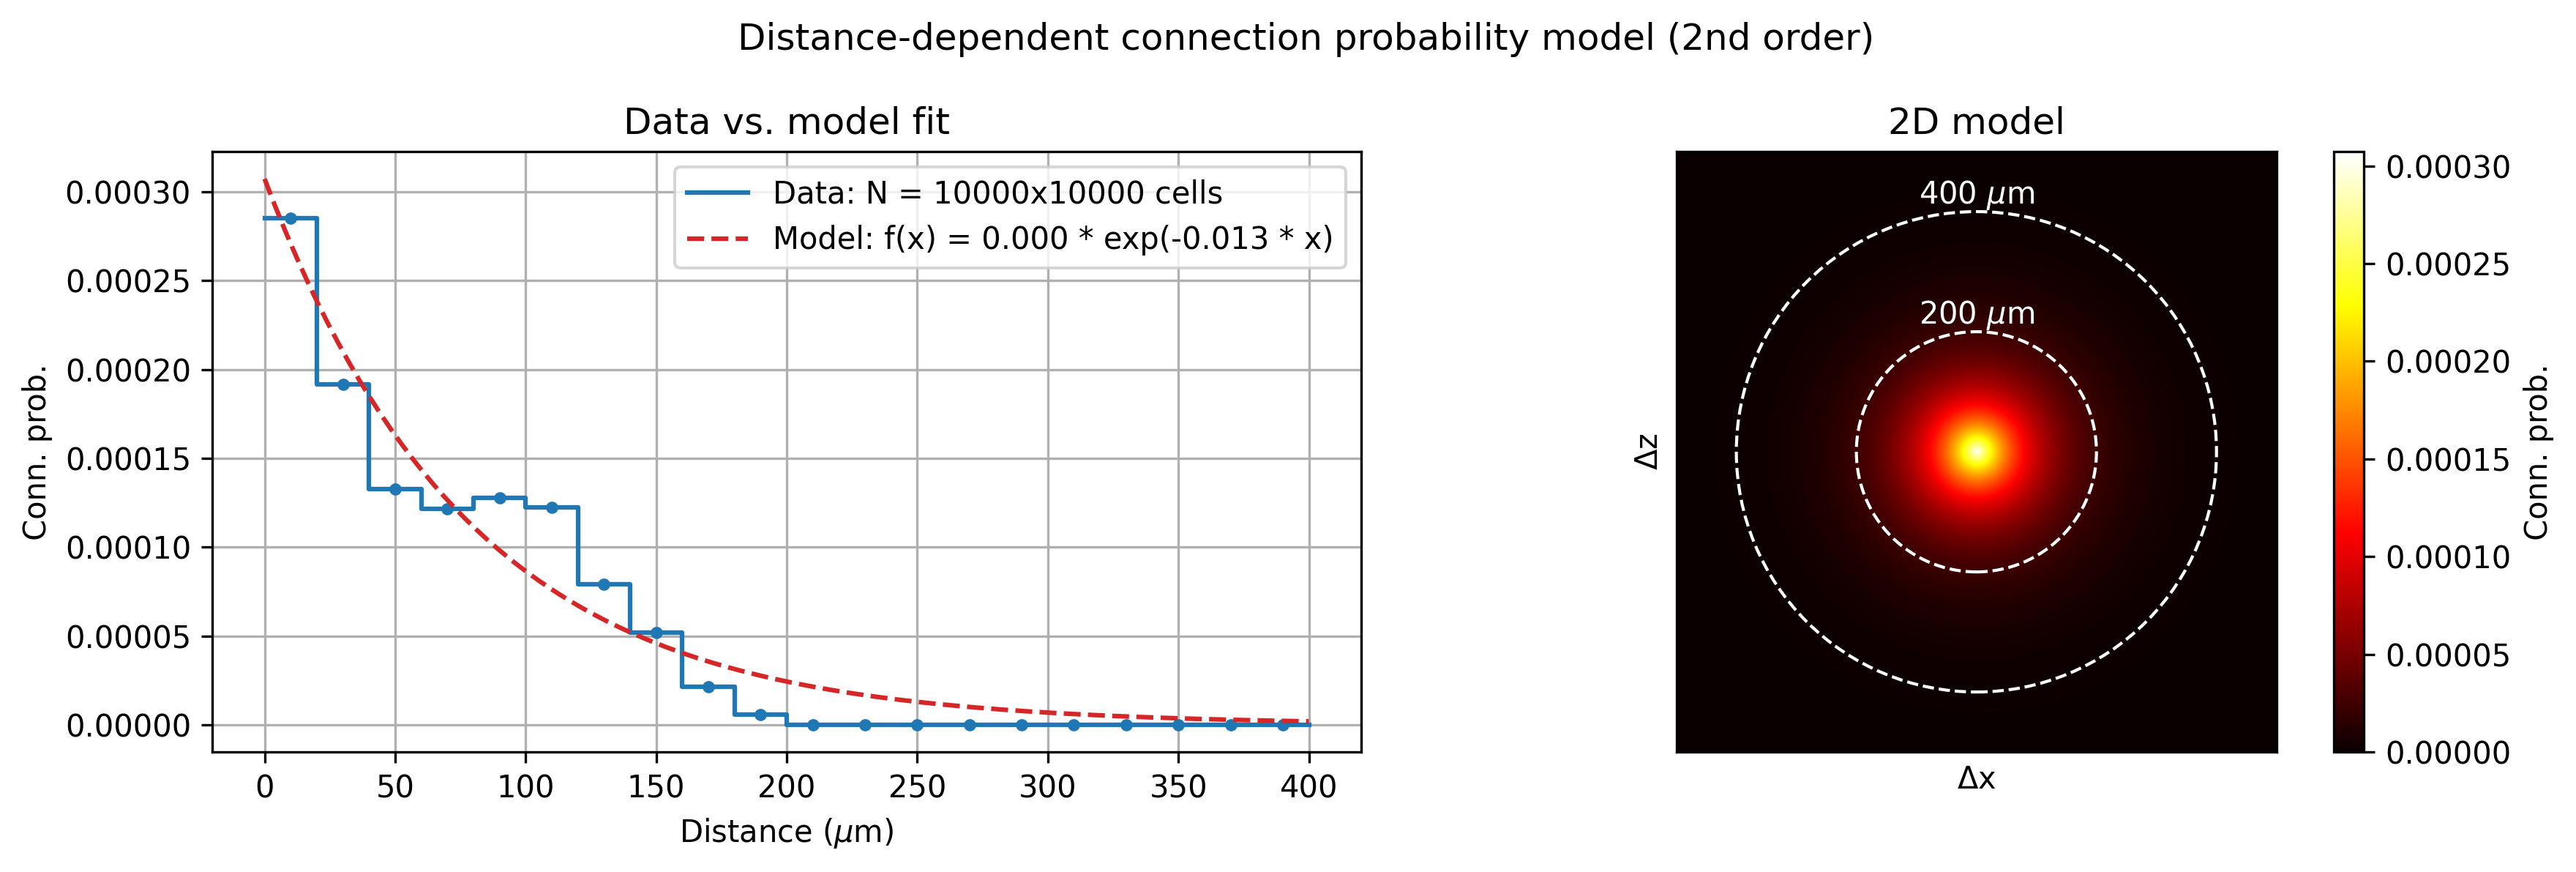

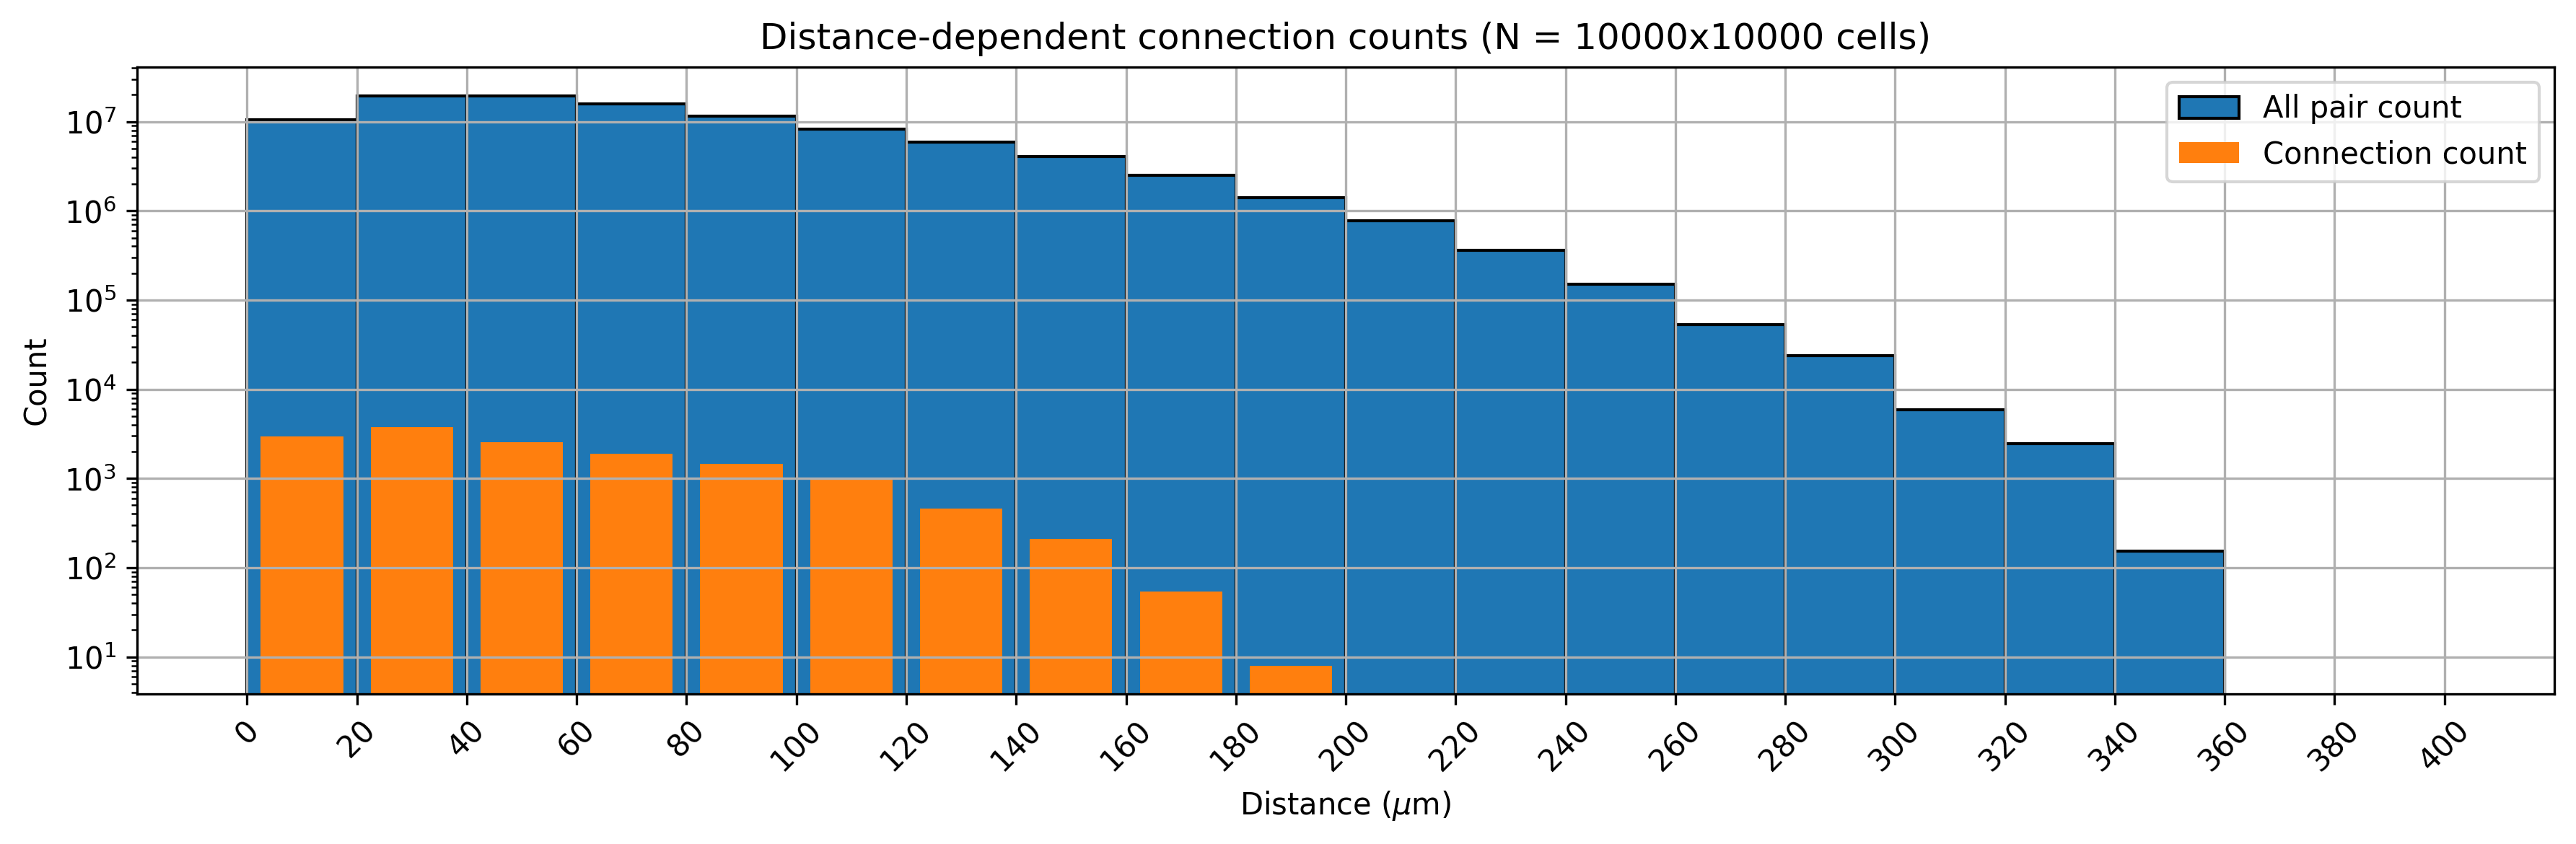

In [15]:
# Run model building on subgraphs
subgraph_pcts = [1] + np.arange(10, 101, 10).tolist()
for pct in subgraph_pcts:
    print(f'RUNNING subgraph modelling with {pct}%...')

    # Load connectivity
    ind_file = f'/gpfs/bbp.cscs.ch/project/proj102/scratch/filt_edge/long1/indices_temp{pct}.npy'
    ptr_file = f'/gpfs/bbp.cscs.ch/project/proj102/scratch/filt_edge/long1/indptr_temp{pct}.npy'
    ind_data = np.load(ind_file)
    ptr_data = np.load(ptr_file)
    adj_matrix = sps.csr_matrix((np.ones_like(ind_data), ind_data, ptr_data), dtype=bool)

    # Build model
    config_dict['model_name'] = f'{base_model_name}_{pct}pct'
    data_dict, model_dict = modelling.run_model_building(adj_matrix, nrn_table, **config_dict)


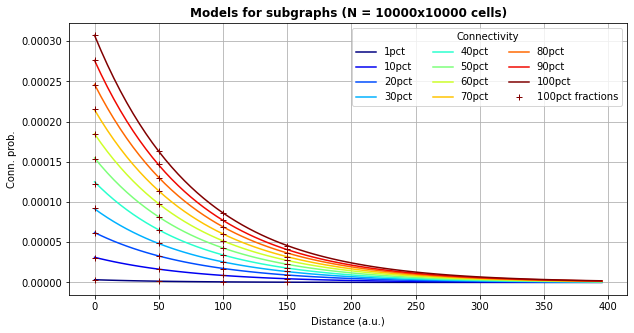

In [63]:
# Plot model comparison
d = np.arange(0, config_dict['max_range_um'], 5) # Distance in um
d_marks = np.arange(0, 151, 50)
subgraph_pcts = np.concatenate([[1], np.arange(10, 101, 10)])
pct_colors = plt.cm.jet(np.linspace(0, 1, len(subgraph_pcts)))
plt.figure(figsize=(10, 5))
for idx, pct in enumerate(subgraph_pcts):
    # Load model
    model_file = os.path.join(config_dict['model_dir'], f'{base_model_name}_{pct}pct__model.pickle')
    with open(model_file, 'rb') as f:
        model_dict = pickle.load(f)
    p_model = modelling.get_model_function(**model_dict) # Probability function

    # Plot probability
    plt.plot(d, p_model(d), color=pct_colors[idx, :], label=f'{pct}pct')

    # Mark fractions of max. prob.
    if pct == subgraph_pcts[-1]:
        for d_mark in d_marks:
            plt.plot(np.full_like(subgraph_pcts, d_mark), p_model(d_mark) * subgraph_pcts / 100, '+', color=pct_colors[idx, :], label=f'{subgraph_pcts[-1]}pct fractions' if d_mark == d_marks[0] else None)
plt.grid()
plt.xlabel('Distance (a.u.)')
plt.ylabel('Conn. prob.')
plt.title(f'Models for subgraphs (N = {config_dict["sample_size"]}x{config_dict["sample_size"]} cells)', fontweight='bold')
plt.legend(title='Connectivity', ncol=3)
plt.show()